In [1014]:
# critical
import argparse
import os
import random
import time
import math

# machine learning
from sklearn.decomposition import PCA

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

In [1015]:
# set random seed for reproducibility
manualSeed = 99
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  99


In [1016]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of classes in the conditional dcgan
num_classes = 3

# number of signals per iteration
batch_size = 32

# Number of training epochs
# num_epochs = int(32 * (6000/1684))
num_epochs = 32

# Learning rate for optimizers
lr_g = 0.00002
lr_d = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

In [1017]:
class GWDataset(Dataset):
    def __init__(self, signals_csv, parameters_csv):
        y = pd.read_csv(parameters_csv)
        self.data = pd.read_csv(signals_csv).astype('float32')
        # remove unusual parameters
        keep_signals_idx = np.array(y[y['beta1_IC_b'] > 0].index)
        y = y.iloc[keep_signals_idx,:]

        # process beta_ic_b parameter
        ranges = [0, 0.06, 0.17, 1]
        labels = [0, 1, 2]
        num_classes = len(labels)
        y = y['beta1_IC_b']
        y = pd.cut(y, bins=ranges, labels=labels).astype('int')
        y = y.values
        y = np.eye(num_classes)[y]
        y = np.reshape(y, (y.shape[0], y.shape[1], 1)).astype('float32')

        self.parameters = y
        self.original_parameters = self.parameters
        self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1])).astype('float32')

        # drop corresponding signals which have erroneous parameter values
        self.data = self.data.iloc[:,keep_signals_idx]
        self.data = self.data.values
        self.original_data = self.data
        self.augmented_data = np.empty(shape = (256, 0)).astype('float32')

        ### signal augmentation section ###
        total_noise_mean = 0
        total_noise_std = 0
        
        temp_data = np.empty(shape = (256, 0)).astype('float32')

        for i in range(0, self.data.shape[1]):
            signal = self.data[:, i]
            signal = signal.reshape(1, -1)

            background_noise_segment = signal[:, 0:int(len(signal[0]) - 256)]
            signal = signal[:, int(len(signal[0]) - 256):len(signal[0])]
            # middle_timestamps = len(signal[0]) // 2
            # signal = signal[:, middle_timestamps - 128: middle_timestamps + 128]

            temp_data = np.insert(temp_data, temp_data.shape[1], signal, axis=1)            

            background_noise_mean = background_noise_segment.mean()
            background_noise_std = background_noise_segment.std()

            total_noise_mean = total_noise_mean + background_noise_mean
            total_noise_std = total_noise_std + background_noise_std

        self.background_noise_mean = total_noise_mean / self.data.shape[1]
        self.background_noise_std = total_noise_std / self.data.shape[1]

        self.data = temp_data
        ### end signal augmentation section ###

    ### augmentation methods ###
    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 25, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(1, 0.2, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal
        return scaled_signal

    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203
        noise = np.random.normal(0, 1, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # take window size of 10% of the signal with a warping factor of 2 or 0.5 (from literature)
        warping_factor =  np.random.choice([0.5, 2])
        # warping_factor = 0.5

        window_size = math.floor(signal.shape[1] / 10)
        scaled_window_size = warping_factor * window_size

        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 203

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal

        return warped_signal

    ### critical functions ###
    def calc_stats(self):
        self.mean = self.data.mean()
        print('Signal Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Signal Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Signal Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal

    def augmentation(self, desired_augmented_data_count):
        while self.data.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            ### mixture augmentation only ###
            # find the class of signal_1 (assuming class is a column in self.parameters)
            class_of_signal_1 = self.parameters[idx_1, -1]
            # sample only from the same class for signal_2 and make sure it's not the same as signal_1
            candidate_indices = [x for x in range(0, self.data.shape[1]) if x != idx_1 and self.parameters[x, -1] == class_of_signal_1]
            idx_2 = np.random.choice(candidate_indices)
            signal_2 = self.data[:, idx_2]
            signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            # augmented_signal = self.window_warping_augmentation(signal_1)
            augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            self.augmented_data = np.insert(self.augmented_data, self.augmented_data.shape[1], augmented_signal, axis=1)
            self.data = np.insert(self.data, self.data.shape[1], augmented_signal, axis=1)

            # just copy parameters for now
            augmented_parameter = self.parameters[idx_1, :]

            self.augmented_parameters = np.insert(self.augmented_parameters, self.augmented_parameters.shape[0], augmented_parameter, axis=0)
            self.parameters = np.insert(self.parameters, self.parameters.shape[0], augmented_parameter, axis=0)

        print("Signal Dataset Size after Data Augmentation: ", self.data.shape)
        print("Parameter Dataset Size after Data Augmentation: ", self.parameters.shape)

    ### overloads ###
    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]

        signal_standardized = self.standardize(signal)

        return signal_standardized, parameter

In [1018]:
def plot_waveforms_standardised(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)

        parameters = real_parameter_batch[i, :].numpy()[0]

        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim_signal)

        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()

Signal Dataset Size after Data Augmentation:  (256, 6000)
Parameter Dataset Size after Data Augmentation:  (6000, 3, 1)
Signal Dataset mean:  -0.52744126
Signal Dataset std:  33.96478
Signal Dataset scaling factor (to match noise in generator):  5
torch.Size([32, 3, 1])
Signal Batch Size:  torch.Size([32, 1, 256])


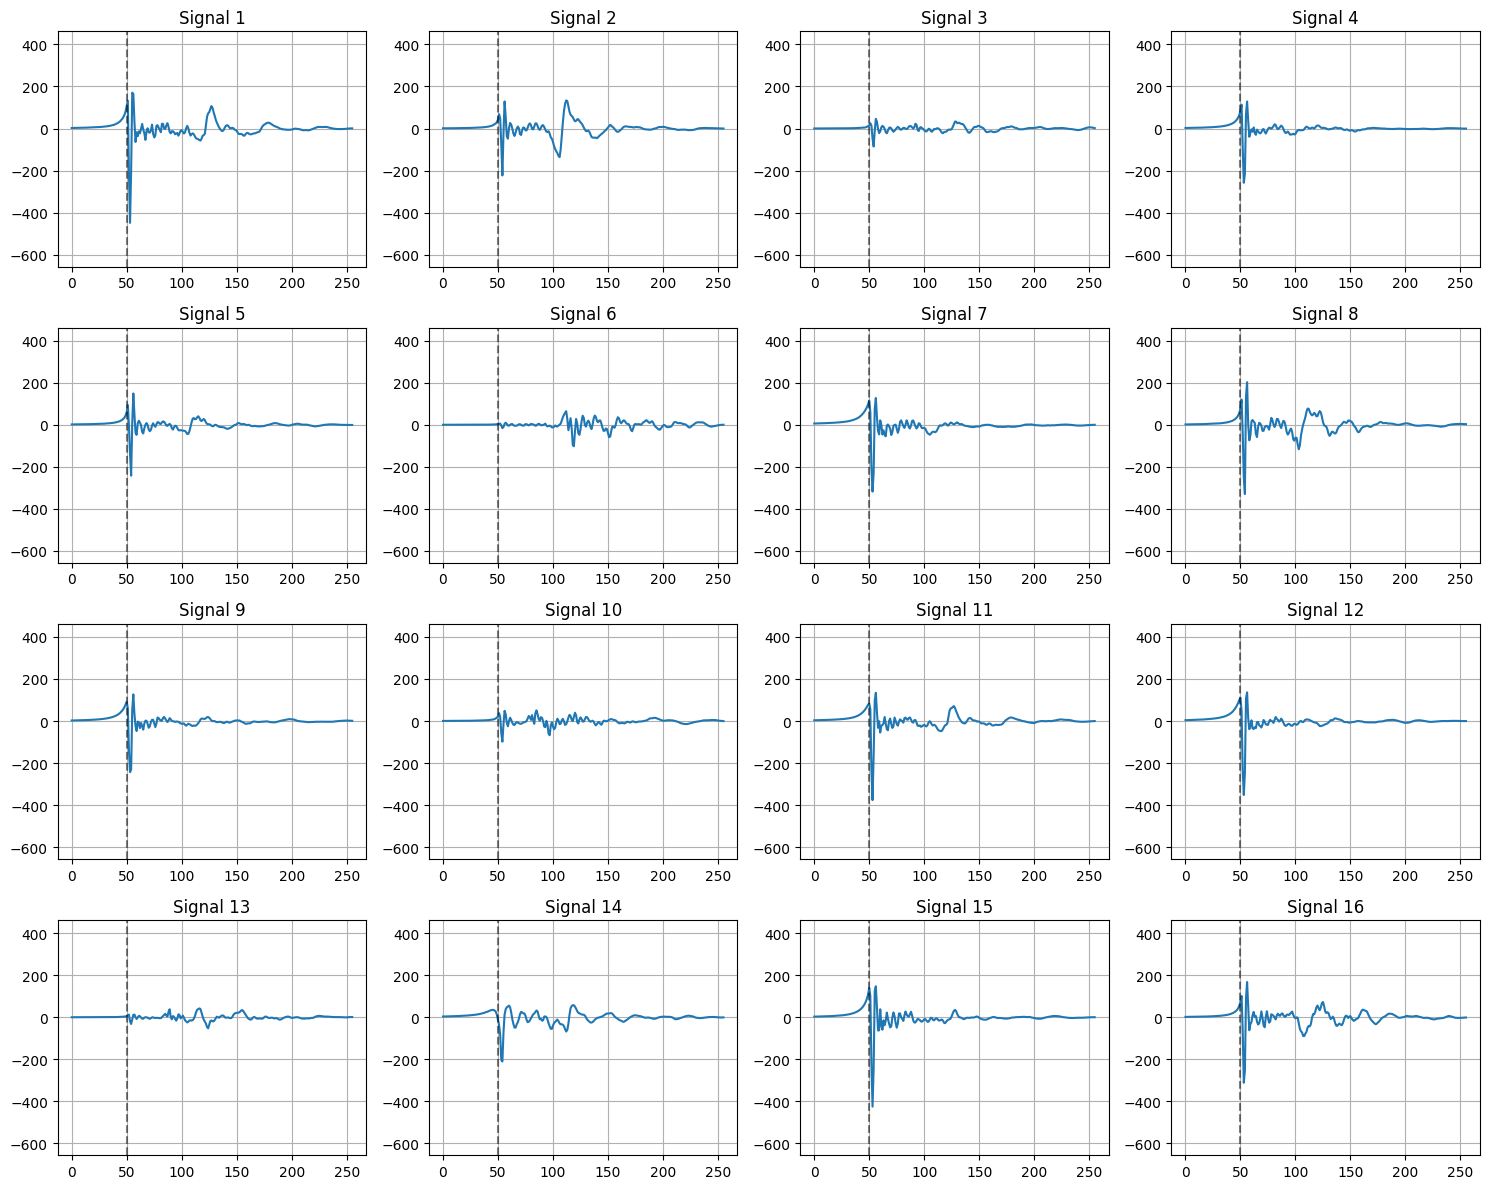

In [1019]:
dataset = GWDataset("../data/gw-raw-data/richers_1764.csv", "../data/gw-raw-data/richers_1764_parameters.csv")

common_ylim_signal = dataset.get_common()
dataset.augmentation(6000)
dataset.calc_stats()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_signals_batch, real_parameter_batch  = next(iter(dataloader))

print(real_parameter_batch.shape)

print("Signal Batch Size: ", real_signals_batch.shape)

common_ylim = (real_signals_batch[:,:,:].min(), real_signals_batch[:,:,:].max())
parameter_names = ['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']

plot_waveforms(real_signals_batch, real_parameter_batch)
# plot_waveforms_standardised(real_signals_batch, real_parameter_batch)

In [1020]:
dataset.__len__()

6000

### Weight Initialisation (Random Noise)

In [1021]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [1022]:
if gans_type == 'dcgans':
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 32, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z):
            z = self.main(z)
            return z
        
if gans_type == 'gans':
    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(nz, ngf),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf, ngf * 2),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 2, ngf * 4),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 4, ngf * 8),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 8, 512),
            )

        def forward(self, z):
            z = z.view(z.size(0), -1)  # Flatten the tensor
            z = self.main(z)
            z = z.view(z.size(0), 1, 512)
            return z

In [1023]:
netG = Generator().to(device)

netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=(nz, nc))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(100, 2048, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias

### Discriminator

In [1024]:
if (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=0, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                ### Can increase model complexity here ###
                # nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 32, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(1),
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            return x

elif (gans_type == "gans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(256, 128),
                # nn.BatchNorm1d(128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(128, 64),
                # nn.BatchNorm1d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(64, 32),
                # nn.BatchNorm1d(32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(32, 16),
                # nn.BatchNorm1d(16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(16, 1),
                nn.Sigmoid(),
            )

        def forward(self, x):
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = self.main(x)
            return x

In [1025]:
netD = Discriminator().to(device)

netD.apply(weights_init)

print(netD)

model = Discriminator()
summary(model, input_size=(nc, 256))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout1d(p=0.2, inplace=False

/Users/tarineccleston/Documents/software-ds/gw-generative-models/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Loss functions and Optimisers

In [1026]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# learning-rate decay scheduler
schedulerD = lr_scheduler.LinearLR(optimizerD, start_factor=1.0, end_factor=0.5, total_iters=32)
schedulerG = lr_scheduler.LinearLR(optimizerG, start_factor=1.0, end_factor=0.5, total_iters=32)

# establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

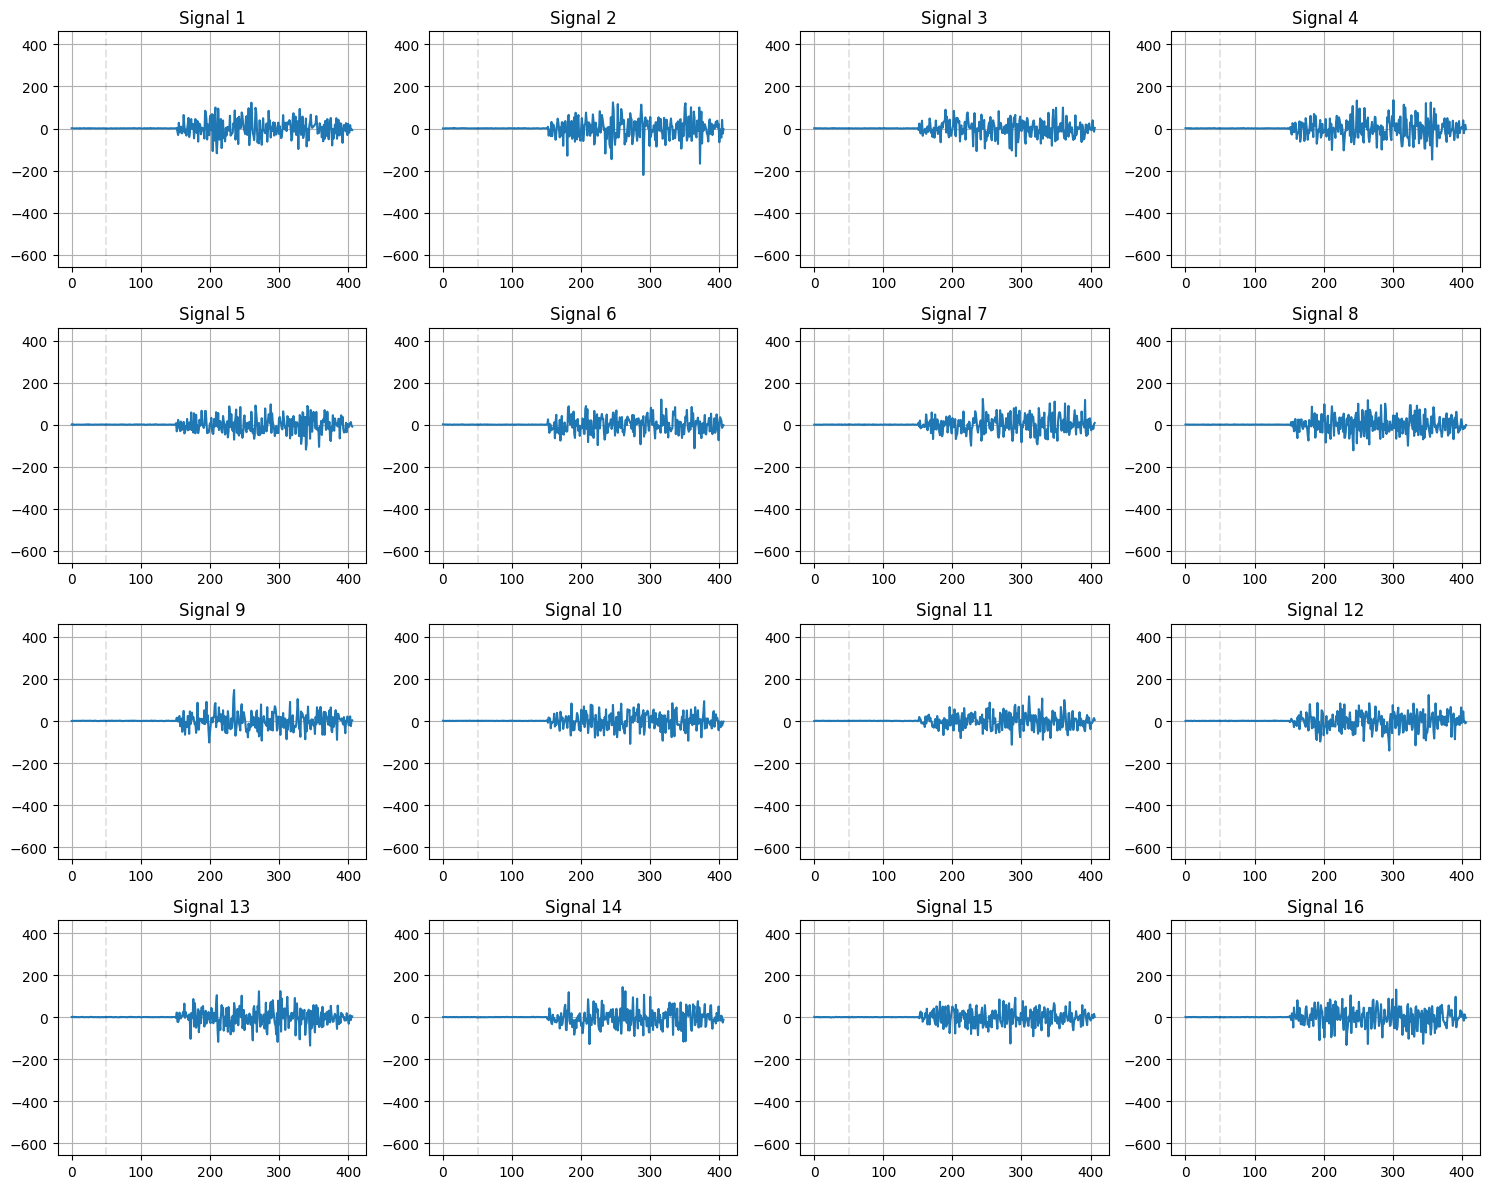

In [1027]:
# create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

# plot generated signals before training
with torch.no_grad():
    fake_signals = netG(fixed_noise).detach().cpu()
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))

    axes = axes.flatten()

    # plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(407)
        y = fake_signals[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        background_noise_generated = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int(407-256))
        y = np.concatenate((background_noise_generated, y))
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.1)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(common_ylim_signal)

    for i in range(512, 8*4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_0.png')
    plt.show()

### Training

Starting Training Loop...
[0/32][0/188]	Loss_D: 1.2597	Loss_G: 0.7719	D(x): 0.5617	D(G(z)): 0.4685 / 0.4748
[0/32][50/188]	Loss_D: 0.8226	Loss_G: 1.1004	D(x): 0.7616	D(G(z)): 0.3442 / 0.3529
[0/32][100/188]	Loss_D: 0.7891	Loss_G: 1.3780	D(x): 0.7929	D(G(z)): 0.2990 / 0.3188
[0/32][150/188]	Loss_D: 0.7103	Loss_G: 1.4512	D(x): 0.8248	D(G(z)): 0.2636 / 0.3052
Epoch 0: SGD Discriminator lr 0.0000200 -> 0.0000197
Epoch 0: SGD Generator lr 0.0000200 -> 0.0000197


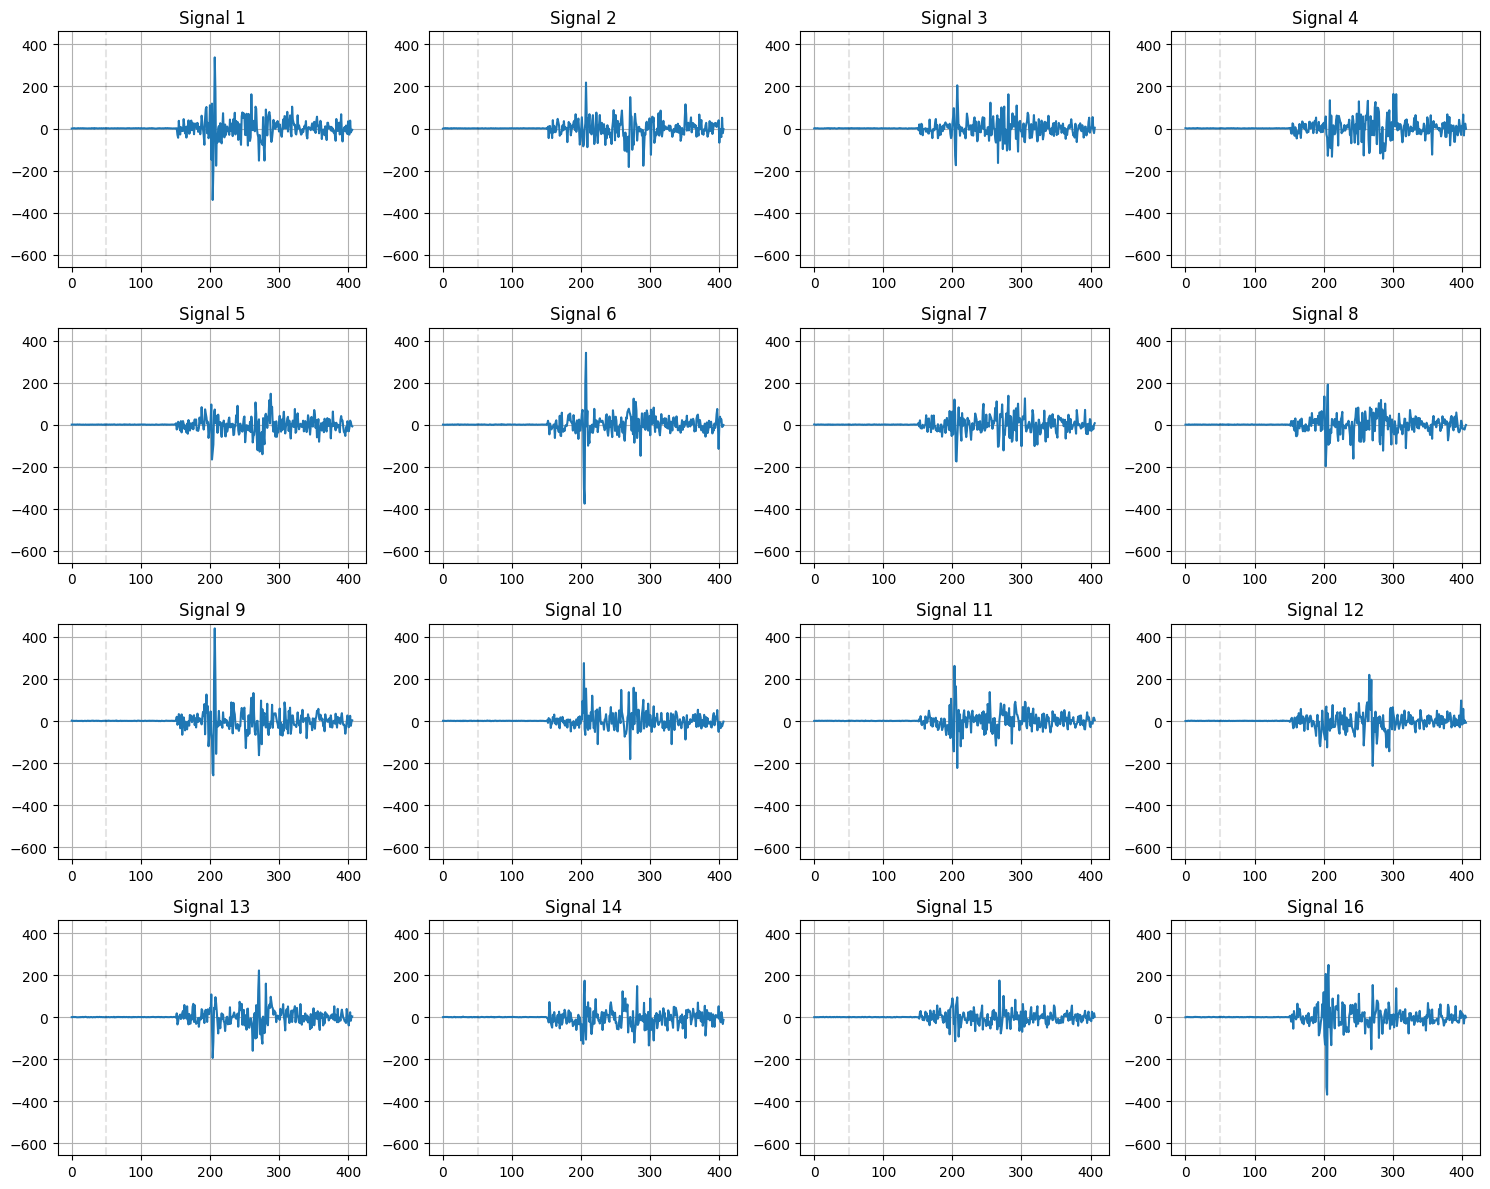

[1/32][0/188]	Loss_D: 0.7037	Loss_G: 1.7663	D(x): 0.8238	D(G(z)): 0.2564 / 0.2269
[1/32][50/188]	Loss_D: 0.8063	Loss_G: 1.5706	D(x): 0.8313	D(G(z)): 0.3105 / 0.2895
[1/32][100/188]	Loss_D: 0.6906	Loss_G: 1.8059	D(x): 0.8493	D(G(z)): 0.2638 / 0.2287
[1/32][150/188]	Loss_D: 0.7795	Loss_G: 1.7804	D(x): 0.7492	D(G(z)): 0.2193 / 0.2306
Epoch 1: SGD Discriminator lr 0.0000197 -> 0.0000194
Epoch 1: SGD Generator lr 0.0000197 -> 0.0000194


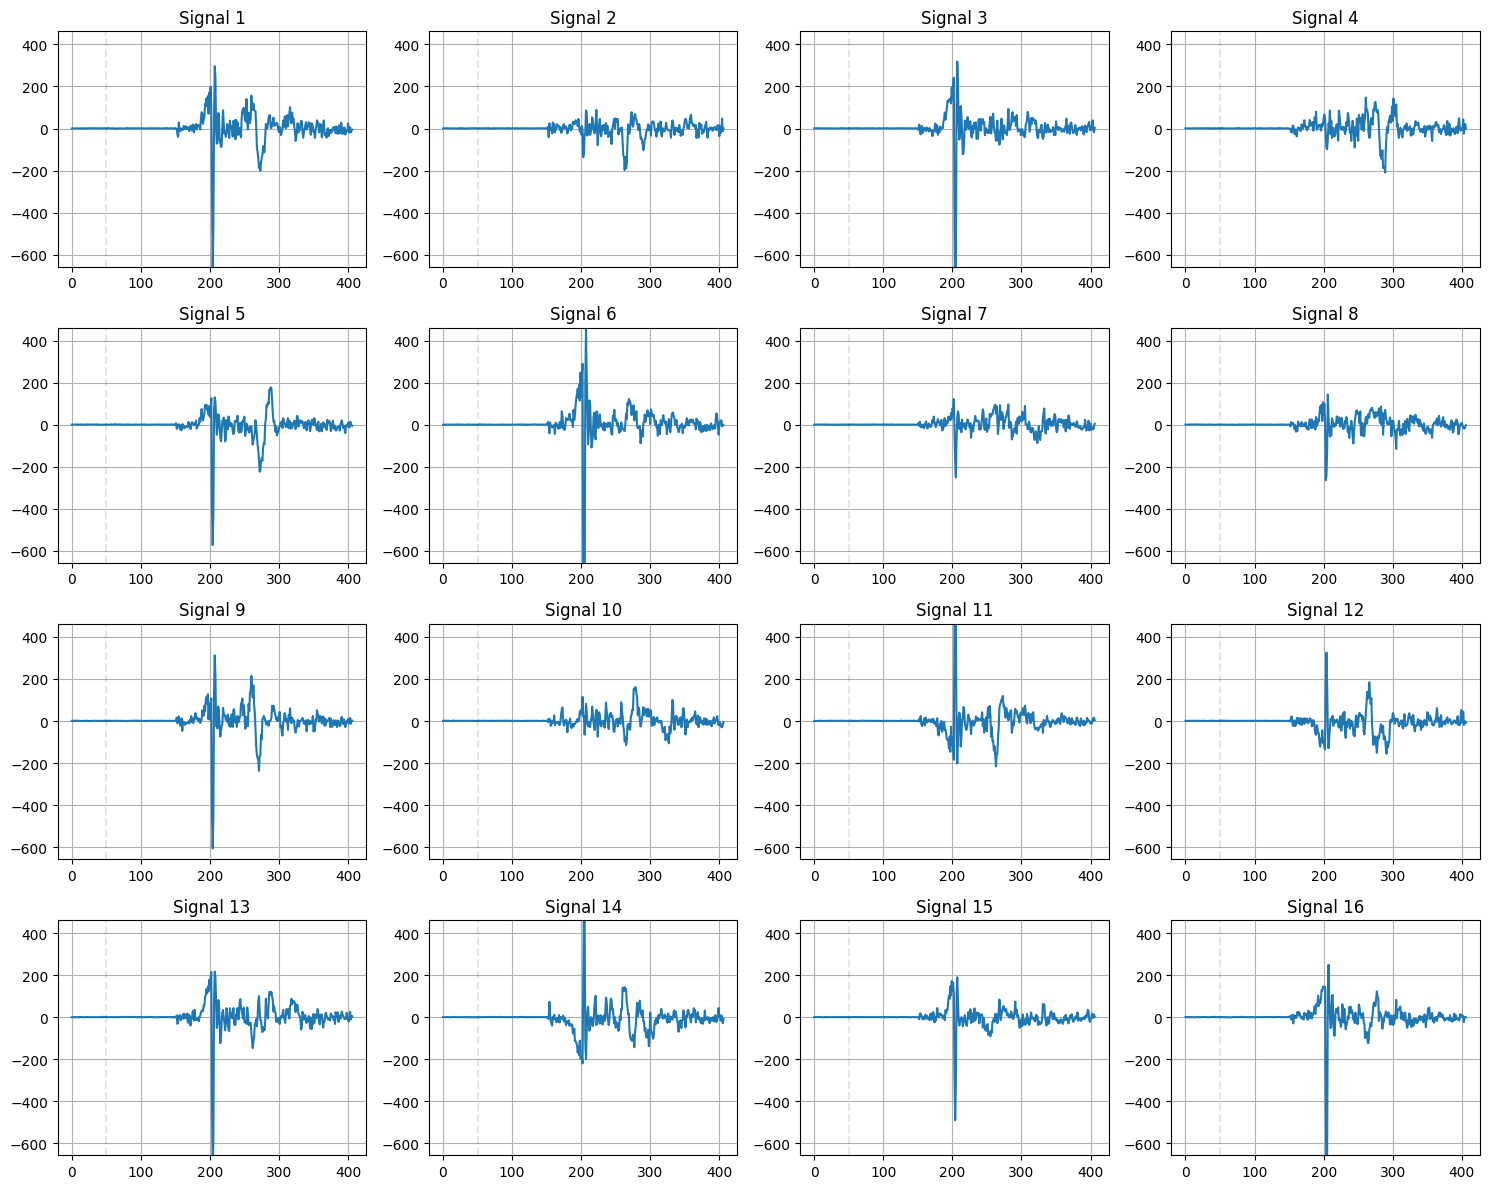

[2/32][0/188]	Loss_D: 0.7971	Loss_G: 1.7857	D(x): 0.7870	D(G(z)): 0.2567 / 0.2314
[2/32][50/188]	Loss_D: 0.5737	Loss_G: 1.5766	D(x): 0.8958	D(G(z)): 0.2275 / 0.2740
[2/32][100/188]	Loss_D: 0.7075	Loss_G: 1.6750	D(x): 0.8091	D(G(z)): 0.2408 / 0.2430
[2/32][150/188]	Loss_D: 0.7588	Loss_G: 1.6504	D(x): 0.8366	D(G(z)): 0.3320 / 0.2392
Epoch 2: SGD Discriminator lr 0.0000194 -> 0.0000191
Epoch 2: SGD Generator lr 0.0000194 -> 0.0000191


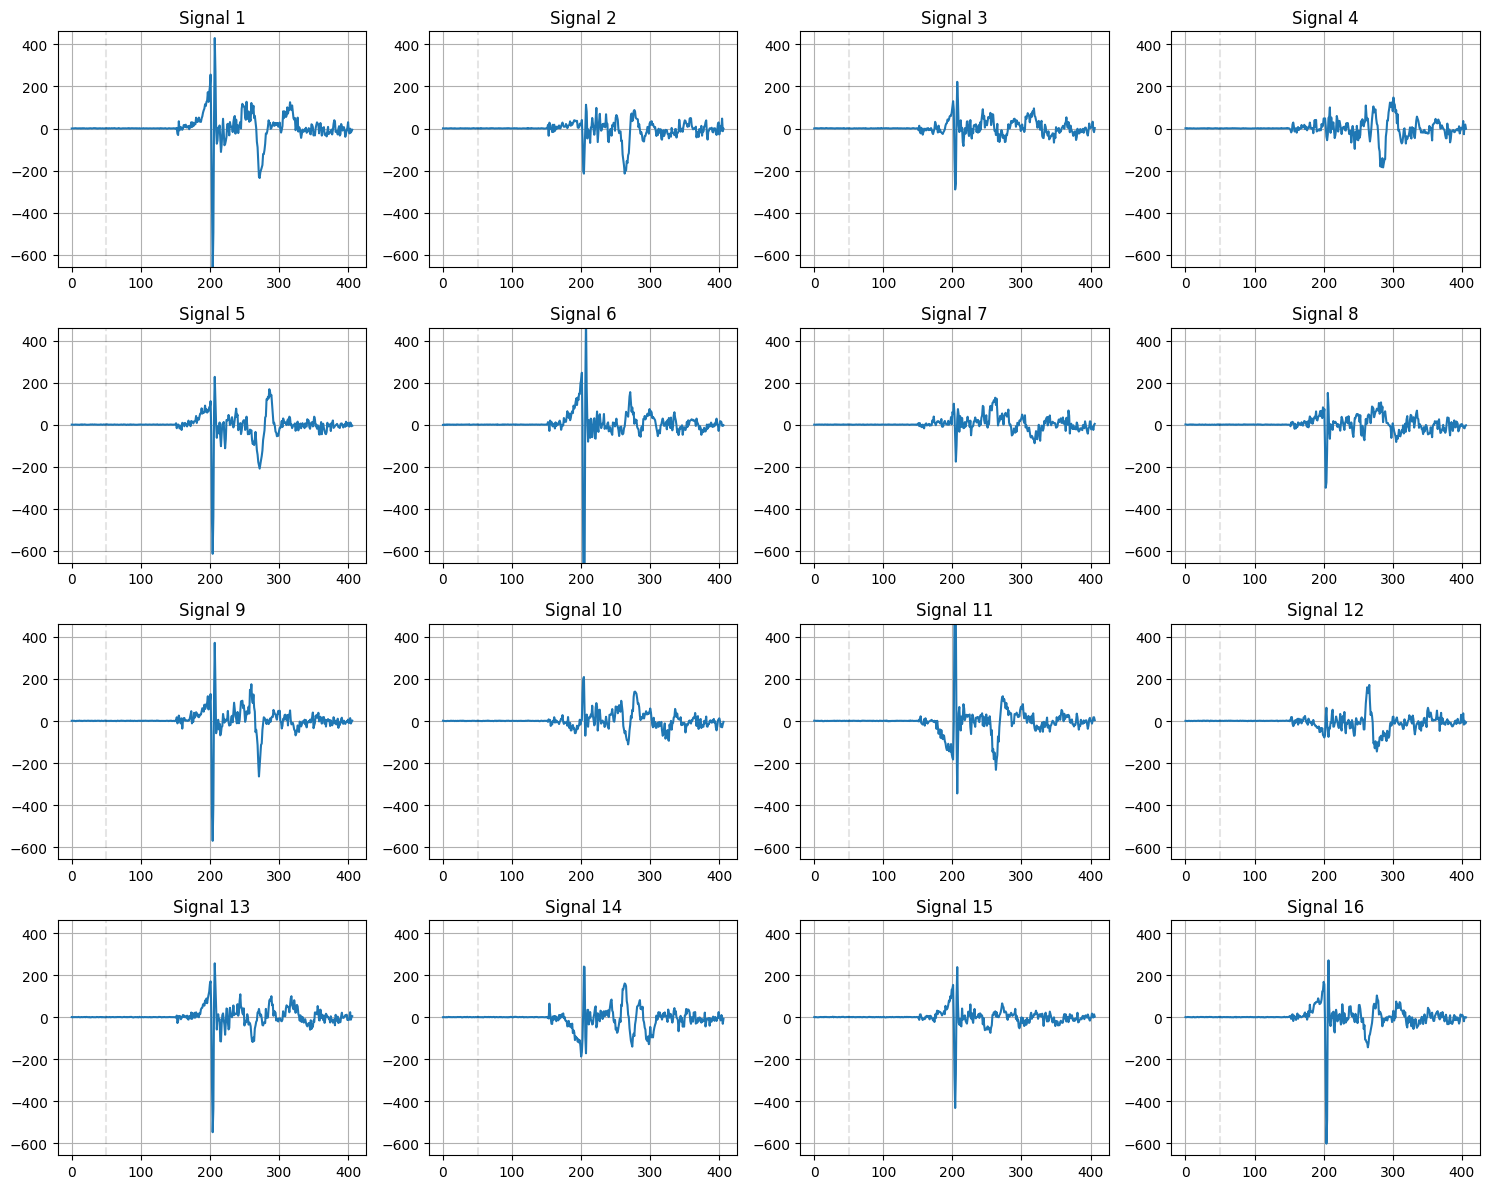

[3/32][0/188]	Loss_D: 0.7334	Loss_G: 1.5098	D(x): 0.8333	D(G(z)): 0.2818 / 0.2831
[3/32][50/188]	Loss_D: 0.6223	Loss_G: 1.9413	D(x): 0.8659	D(G(z)): 0.2104 / 0.1968
[3/32][100/188]	Loss_D: 0.7065	Loss_G: 2.1166	D(x): 0.8431	D(G(z)): 0.2117 / 0.1642
[3/32][150/188]	Loss_D: 0.7200	Loss_G: 1.5536	D(x): 0.8742	D(G(z)): 0.3166 / 0.2549
Epoch 3: SGD Discriminator lr 0.0000191 -> 0.0000188
Epoch 3: SGD Generator lr 0.0000191 -> 0.0000188


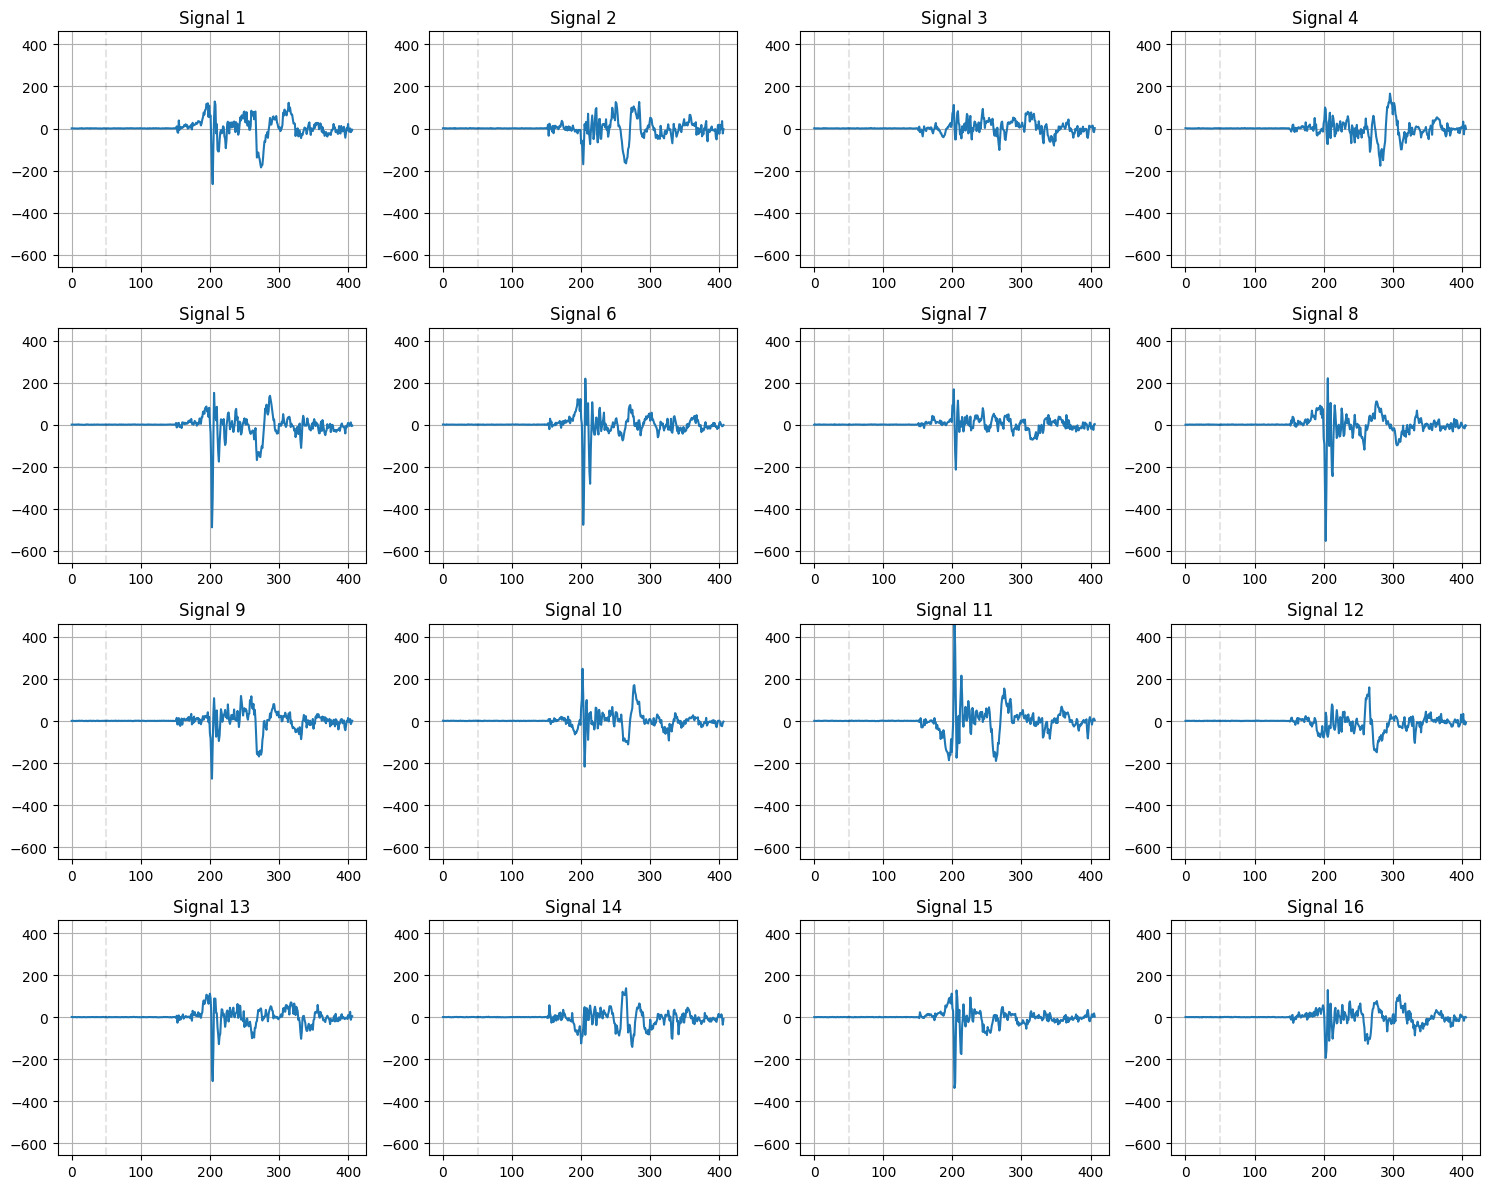

[4/32][0/188]	Loss_D: 0.6120	Loss_G: 1.6947	D(x): 0.8814	D(G(z)): 0.1470 / 0.2630
[4/32][50/188]	Loss_D: 0.6503	Loss_G: 1.8983	D(x): 0.8840	D(G(z)): 0.2441 / 0.2038
[4/32][100/188]	Loss_D: 0.6721	Loss_G: 1.8837	D(x): 0.8832	D(G(z)): 0.2478 / 0.2568
[4/32][150/188]	Loss_D: 0.7877	Loss_G: 1.6081	D(x): 0.8575	D(G(z)): 0.3209 / 0.2877
Epoch 4: SGD Discriminator lr 0.0000188 -> 0.0000184
Epoch 4: SGD Generator lr 0.0000188 -> 0.0000184


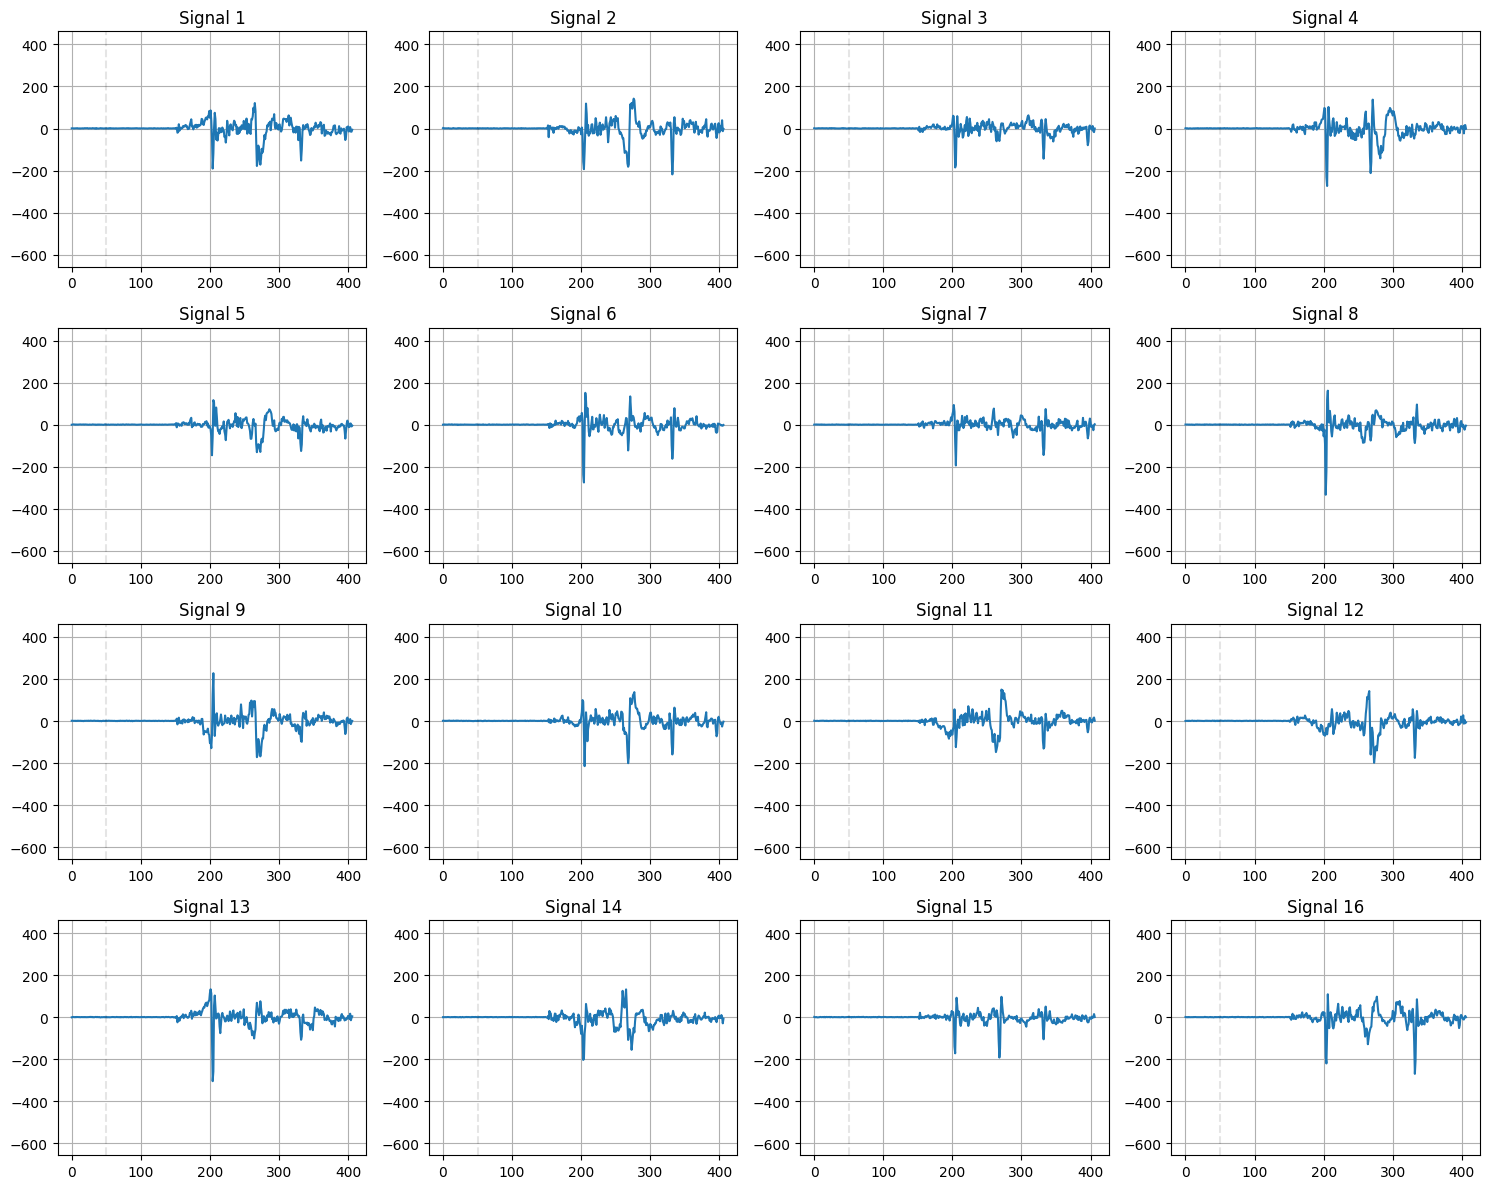

[5/32][0/188]	Loss_D: 0.8668	Loss_G: 2.0358	D(x): 0.7767	D(G(z)): 0.2664 / 0.2070
[5/32][50/188]	Loss_D: 0.6031	Loss_G: 1.9652	D(x): 0.8909	D(G(z)): 0.1858 / 0.2063
[5/32][100/188]	Loss_D: 0.6774	Loss_G: 1.7799	D(x): 0.8682	D(G(z)): 0.2316 / 0.2784
[5/32][150/188]	Loss_D: 0.6599	Loss_G: 2.3396	D(x): 0.8222	D(G(z)): 0.1404 / 0.1989
Epoch 5: SGD Discriminator lr 0.0000184 -> 0.0000181
Epoch 5: SGD Generator lr 0.0000184 -> 0.0000181


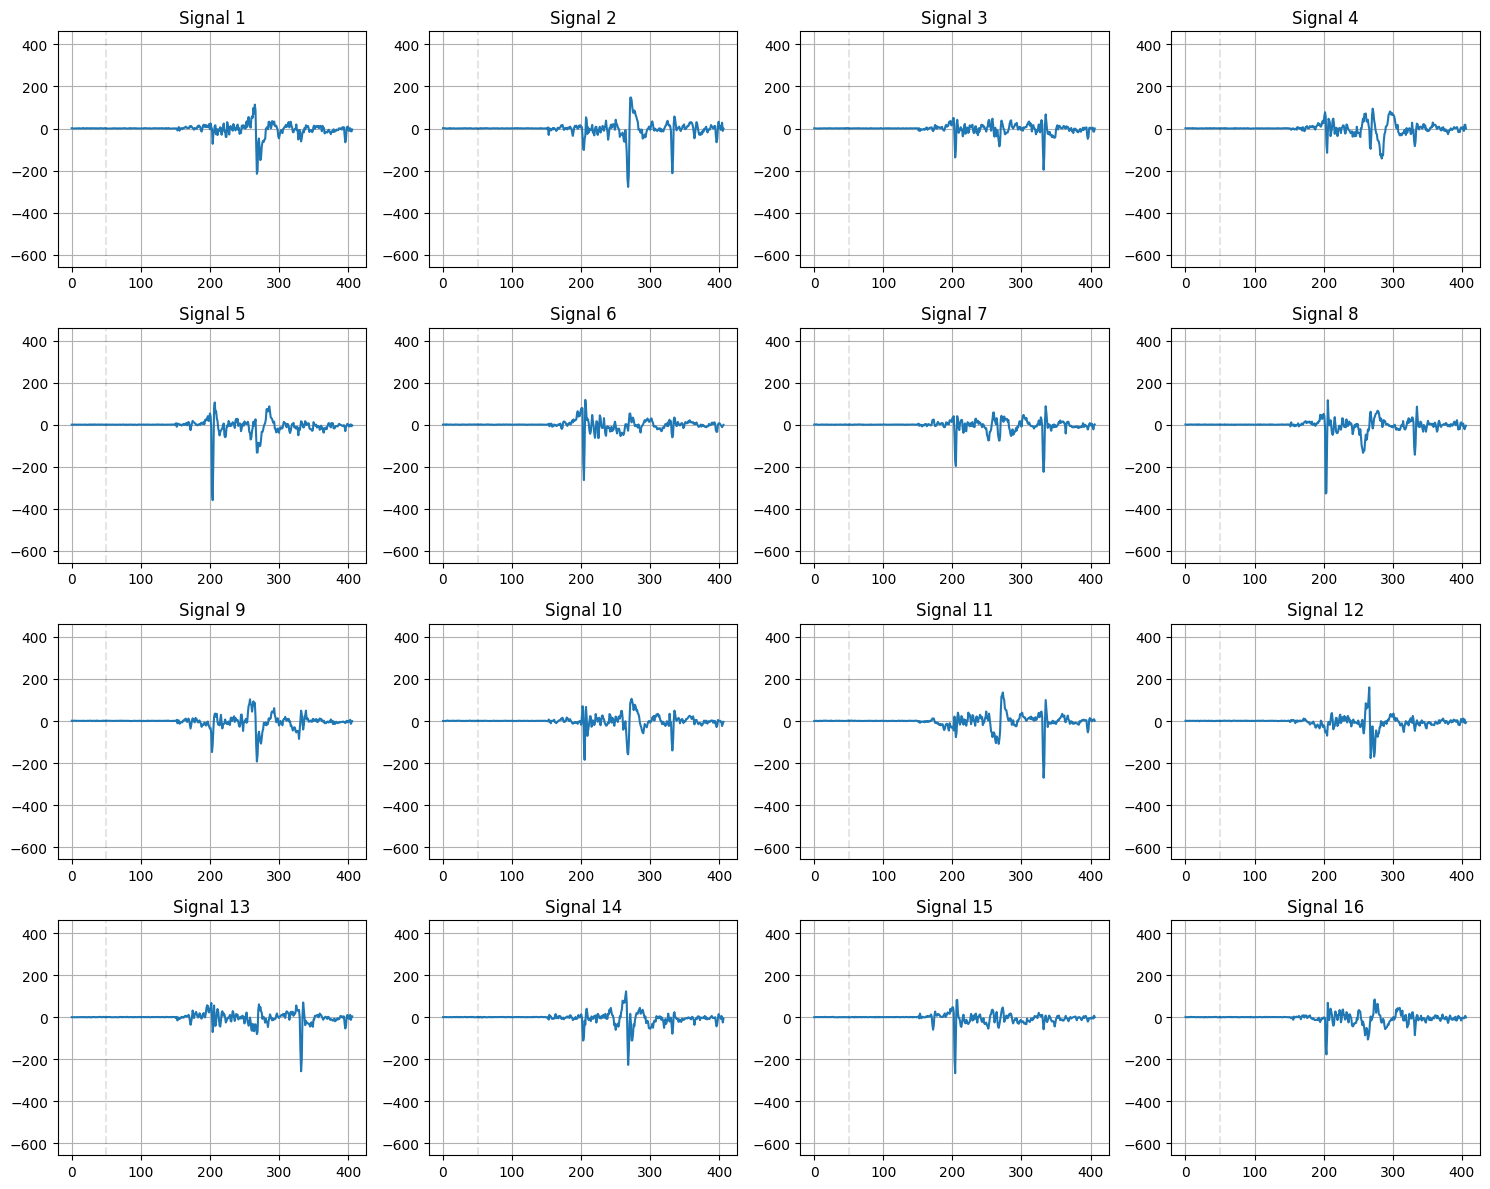

[6/32][0/188]	Loss_D: 0.7178	Loss_G: 1.7726	D(x): 0.8655	D(G(z)): 0.2318 / 0.2490
[6/32][50/188]	Loss_D: 0.8747	Loss_G: 1.3389	D(x): 0.8243	D(G(z)): 0.3720 / 0.3475
[6/32][100/188]	Loss_D: 0.6971	Loss_G: 1.8348	D(x): 0.8355	D(G(z)): 0.2350 / 0.2442
[6/32][150/188]	Loss_D: 0.7357	Loss_G: 2.1035	D(x): 0.8319	D(G(z)): 0.1708 / 0.1888
Epoch 6: SGD Discriminator lr 0.0000181 -> 0.0000178
Epoch 6: SGD Generator lr 0.0000181 -> 0.0000178


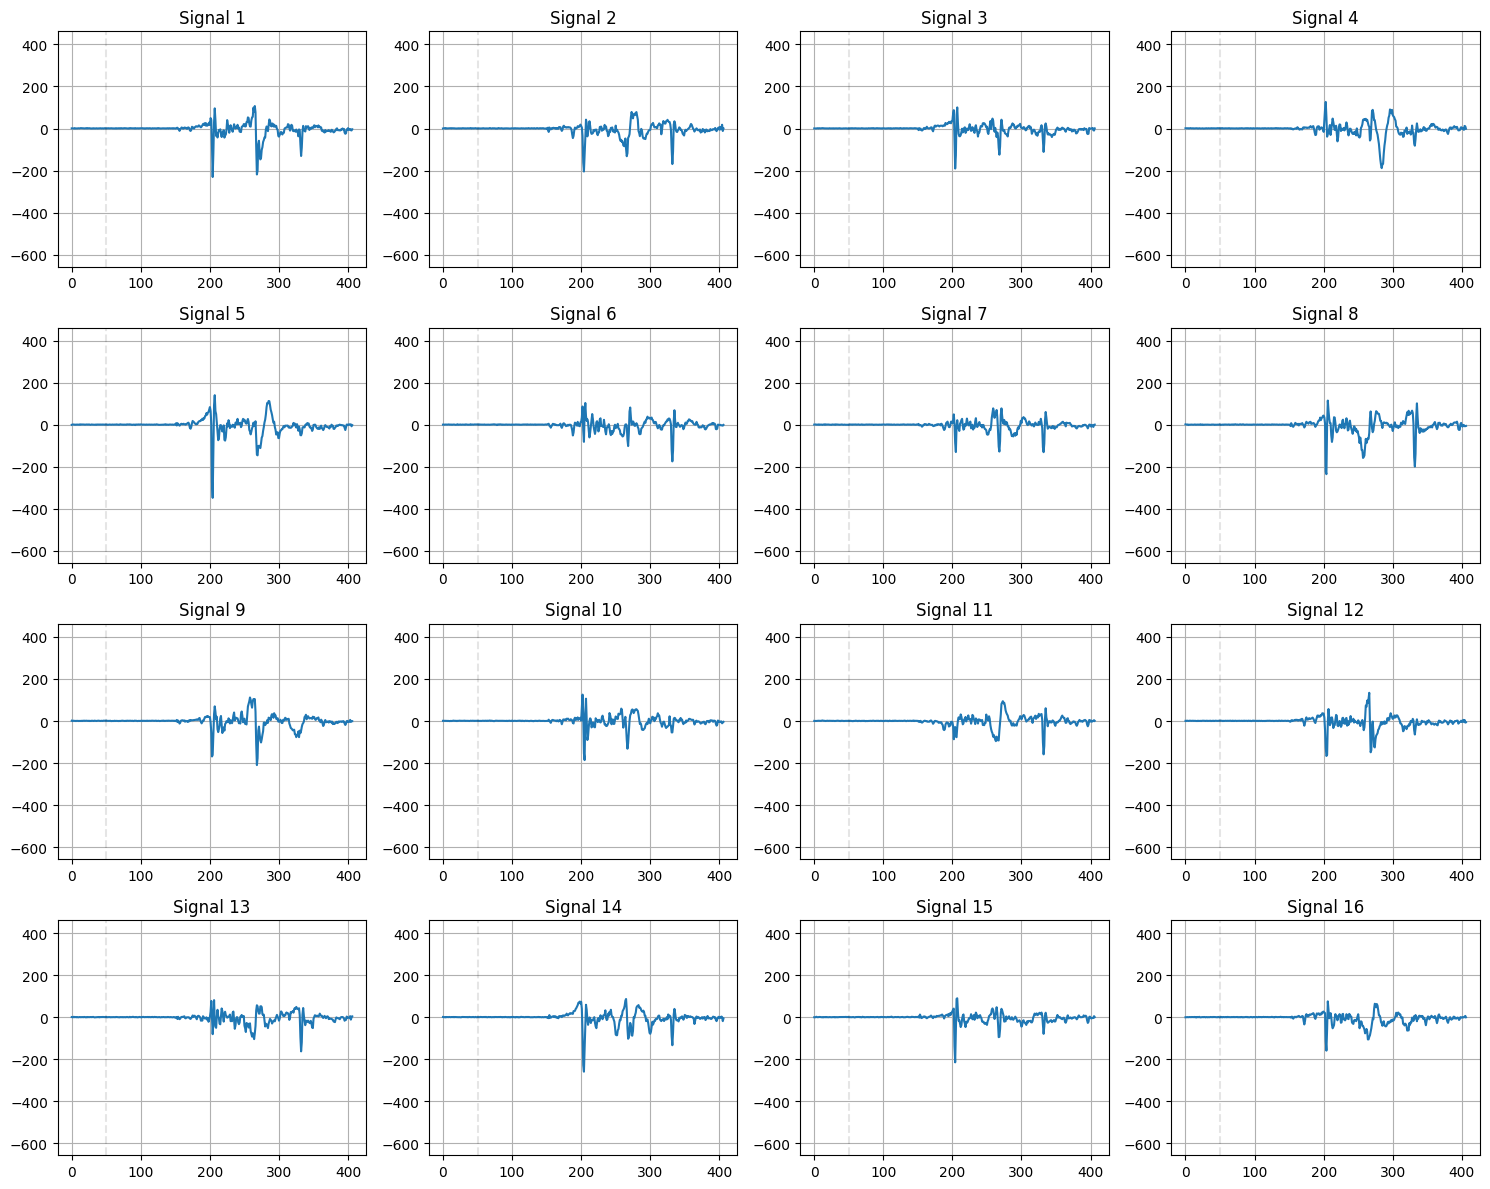

[7/32][0/188]	Loss_D: 0.7158	Loss_G: 1.3860	D(x): 0.8778	D(G(z)): 0.2854 / 0.3407
[7/32][50/188]	Loss_D: 0.6712	Loss_G: 1.5651	D(x): 0.8785	D(G(z)): 0.2620 / 0.2915
[7/32][100/188]	Loss_D: 0.6744	Loss_G: 1.5355	D(x): 0.8433	D(G(z)): 0.3082 / 0.2832
[7/32][150/188]	Loss_D: 0.7706	Loss_G: 2.3084	D(x): 0.7753	D(G(z)): 0.2287 / 0.1803
Epoch 7: SGD Discriminator lr 0.0000178 -> 0.0000175
Epoch 7: SGD Generator lr 0.0000178 -> 0.0000175


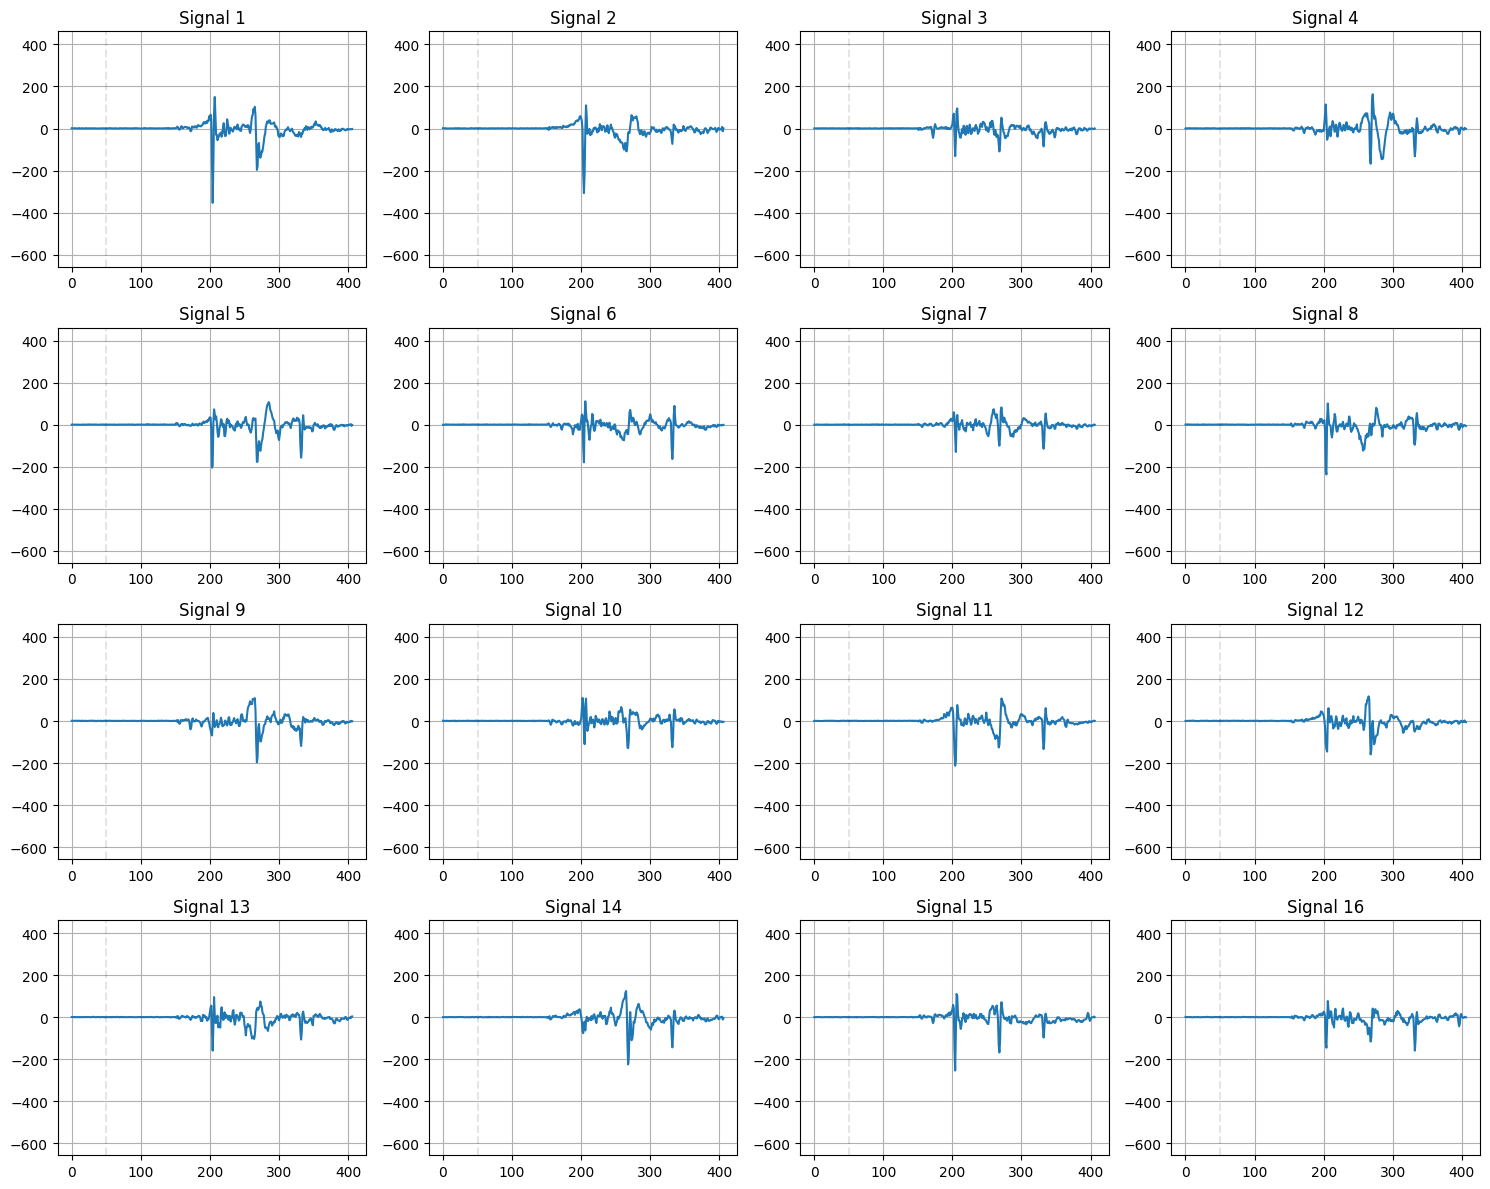

[8/32][0/188]	Loss_D: 0.7599	Loss_G: 2.0887	D(x): 0.8301	D(G(z)): 0.2727 / 0.1844
[8/32][50/188]	Loss_D: 0.7147	Loss_G: 1.7736	D(x): 0.8547	D(G(z)): 0.2874 / 0.2396
[8/32][100/188]	Loss_D: 0.6480	Loss_G: 1.7965	D(x): 0.8731	D(G(z)): 0.1860 / 0.2432
[8/32][150/188]	Loss_D: 0.7150	Loss_G: 1.8988	D(x): 0.8314	D(G(z)): 0.2224 / 0.2348
Epoch 8: SGD Discriminator lr 0.0000175 -> 0.0000172
Epoch 8: SGD Generator lr 0.0000175 -> 0.0000172


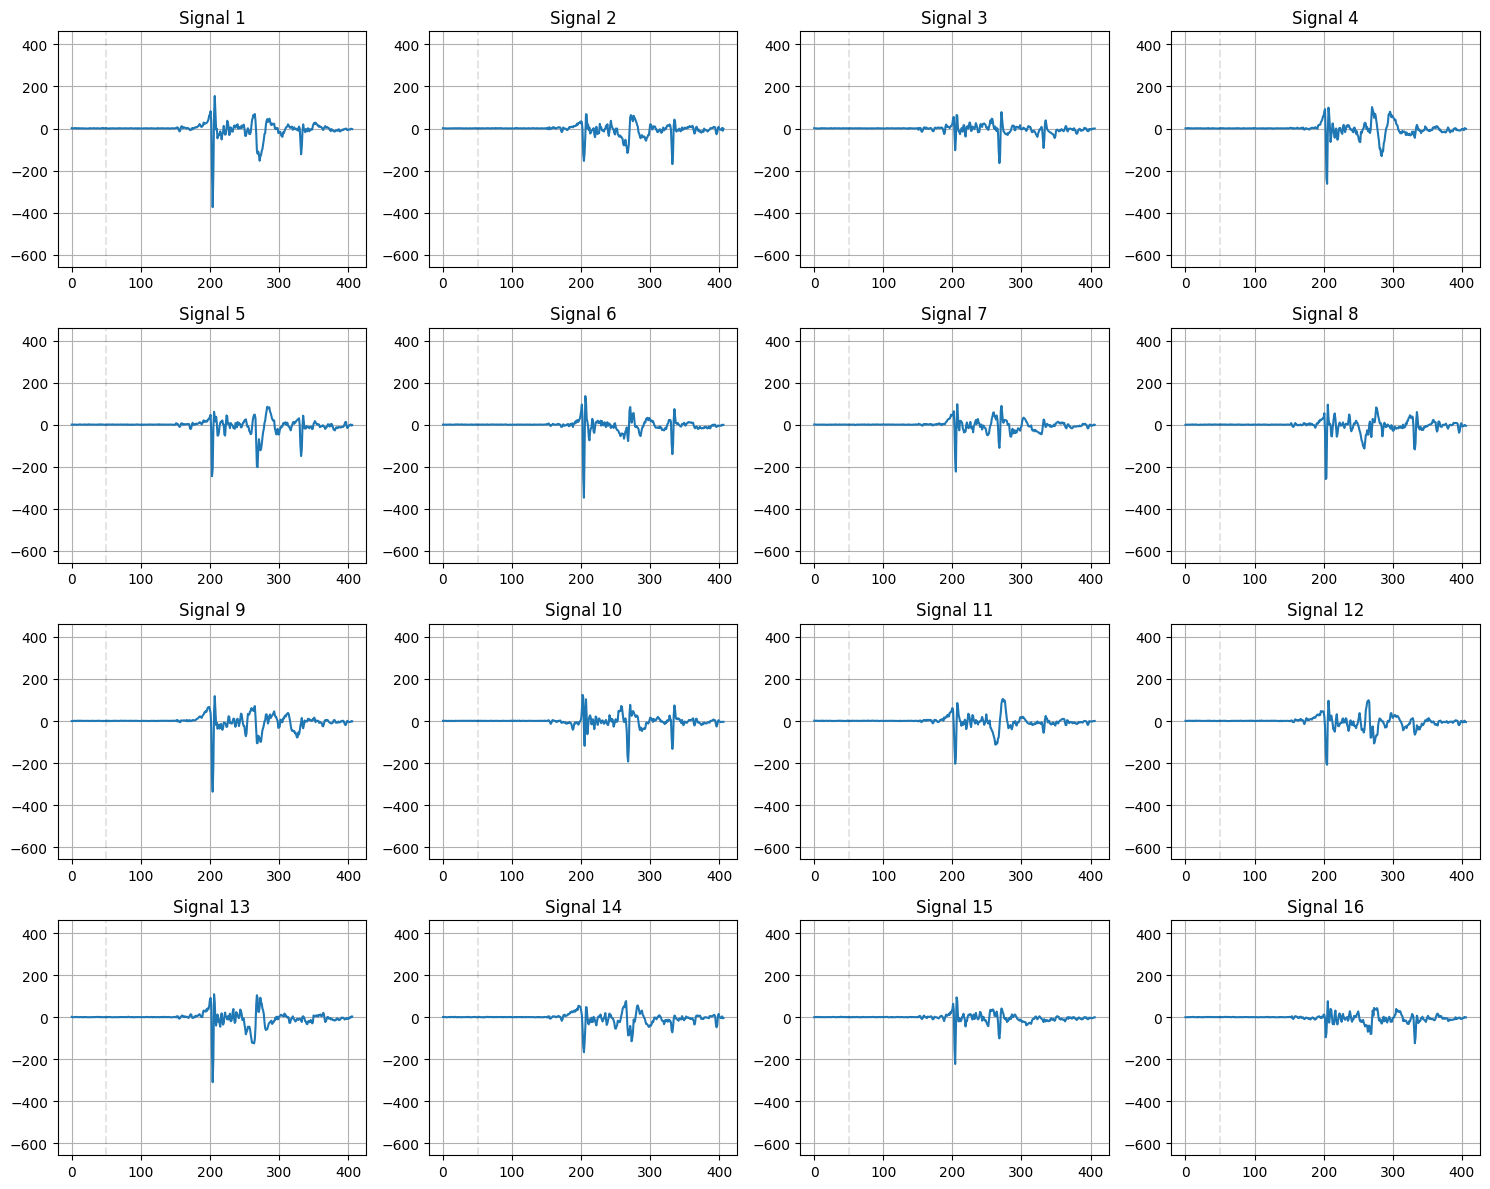

[9/32][0/188]	Loss_D: 0.6310	Loss_G: 2.6382	D(x): 0.8572	D(G(z)): 0.1590 / 0.1753
[9/32][50/188]	Loss_D: 0.7958	Loss_G: 1.9047	D(x): 0.7963	D(G(z)): 0.2558 / 0.2179
[9/32][100/188]	Loss_D: 0.7958	Loss_G: 1.6672	D(x): 0.8200	D(G(z)): 0.3134 / 0.2590
[9/32][150/188]	Loss_D: 0.6381	Loss_G: 1.6611	D(x): 0.8448	D(G(z)): 0.2018 / 0.2485
Epoch 9: SGD Discriminator lr 0.0000172 -> 0.0000169
Epoch 9: SGD Generator lr 0.0000172 -> 0.0000169


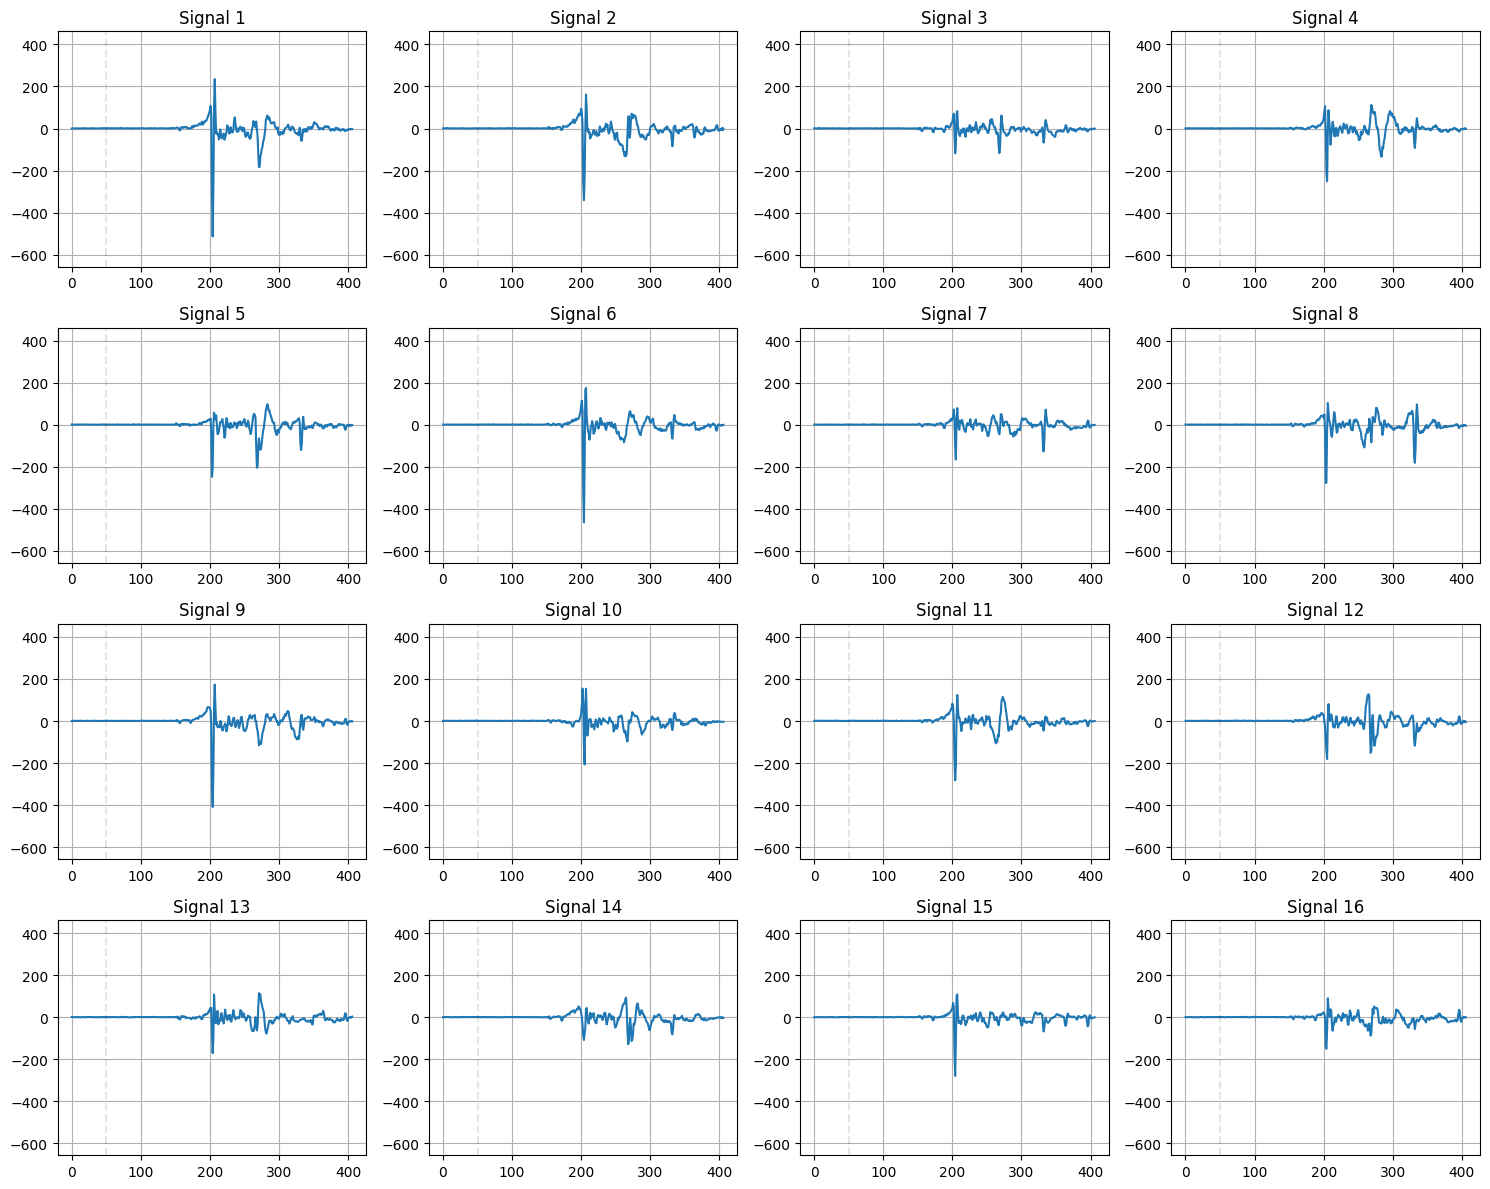

[10/32][0/188]	Loss_D: 0.6287	Loss_G: 2.1779	D(x): 0.8747	D(G(z)): 0.2088 / 0.1901
[10/32][50/188]	Loss_D: 0.6739	Loss_G: 1.7429	D(x): 0.8492	D(G(z)): 0.2482 / 0.2428
[10/32][100/188]	Loss_D: 0.6197	Loss_G: 1.6621	D(x): 0.9165	D(G(z)): 0.2433 / 0.2642
[10/32][150/188]	Loss_D: 0.6903	Loss_G: 1.5677	D(x): 0.8991	D(G(z)): 0.2270 / 0.2767
Epoch 10: SGD Discriminator lr 0.0000169 -> 0.0000166
Epoch 10: SGD Generator lr 0.0000169 -> 0.0000166


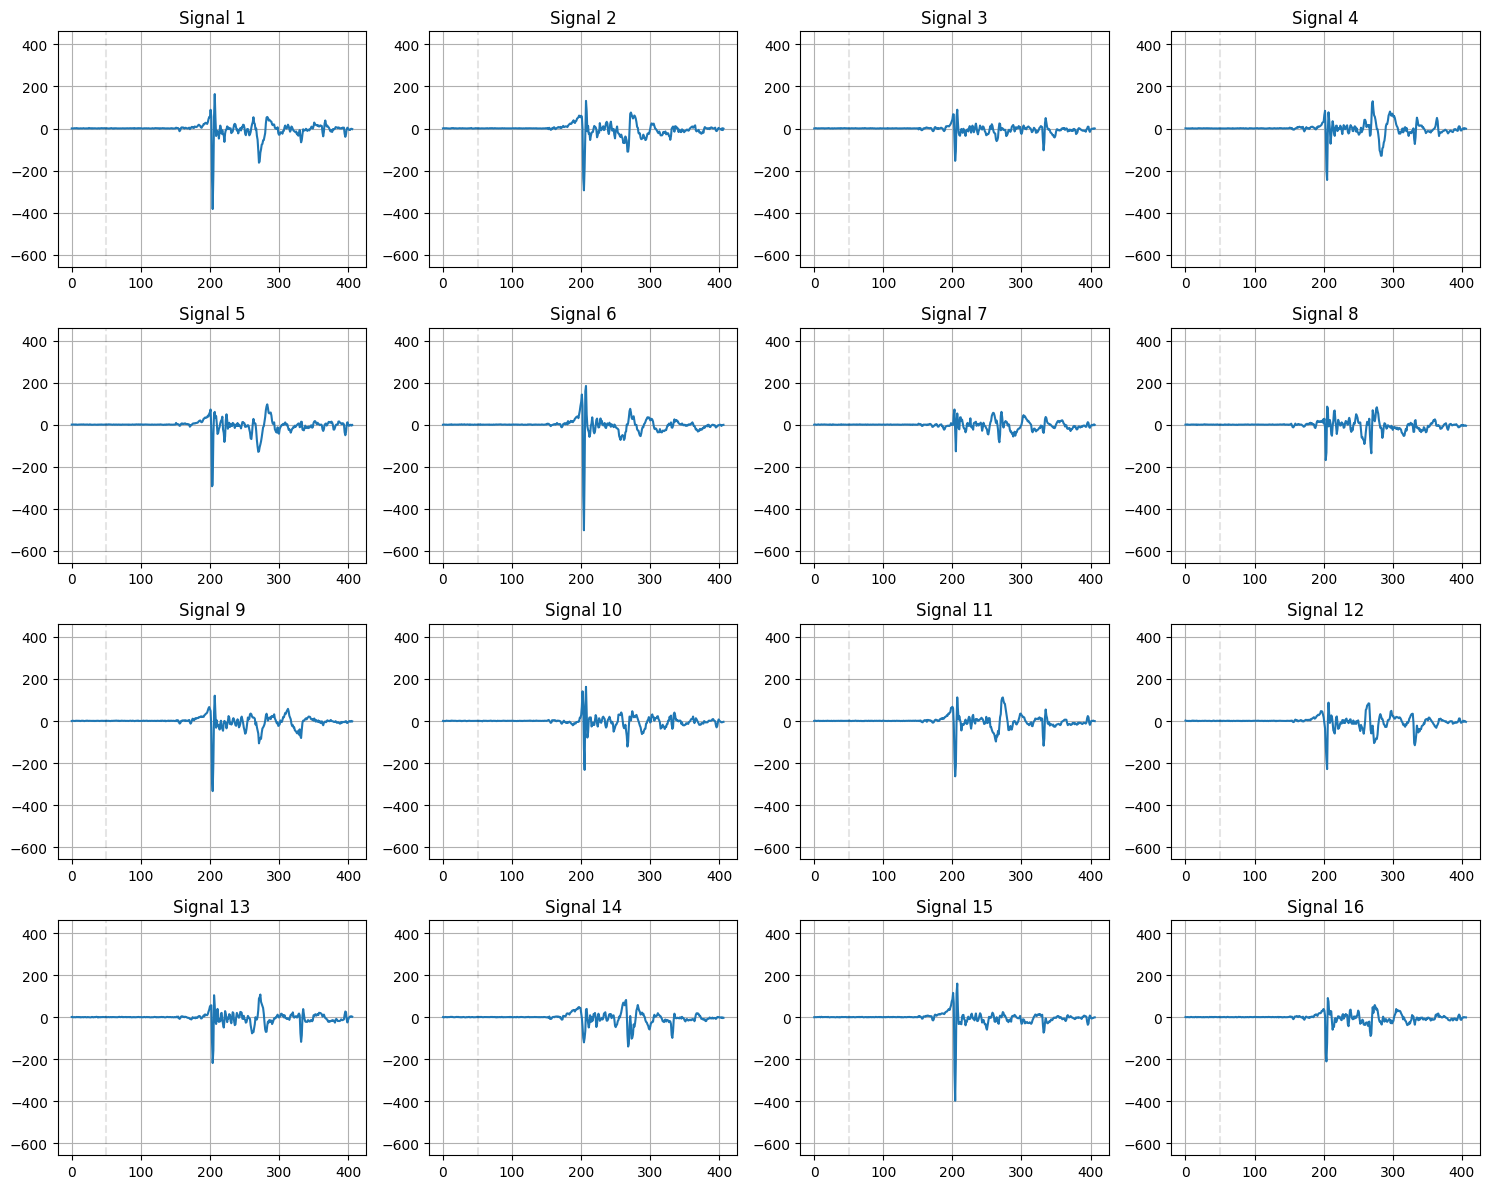

[11/32][0/188]	Loss_D: 0.6134	Loss_G: 1.4821	D(x): 0.9039	D(G(z)): 0.2294 / 0.2882
[11/32][50/188]	Loss_D: 0.6352	Loss_G: 1.7903	D(x): 0.8881	D(G(z)): 0.2516 / 0.2432
[11/32][100/188]	Loss_D: 0.6978	Loss_G: 1.6003	D(x): 0.8161	D(G(z)): 0.2013 / 0.2532
[11/32][150/188]	Loss_D: 0.8266	Loss_G: 1.9709	D(x): 0.7755	D(G(z)): 0.2133 / 0.2275
Epoch 11: SGD Discriminator lr 0.0000166 -> 0.0000162
Epoch 11: SGD Generator lr 0.0000166 -> 0.0000162


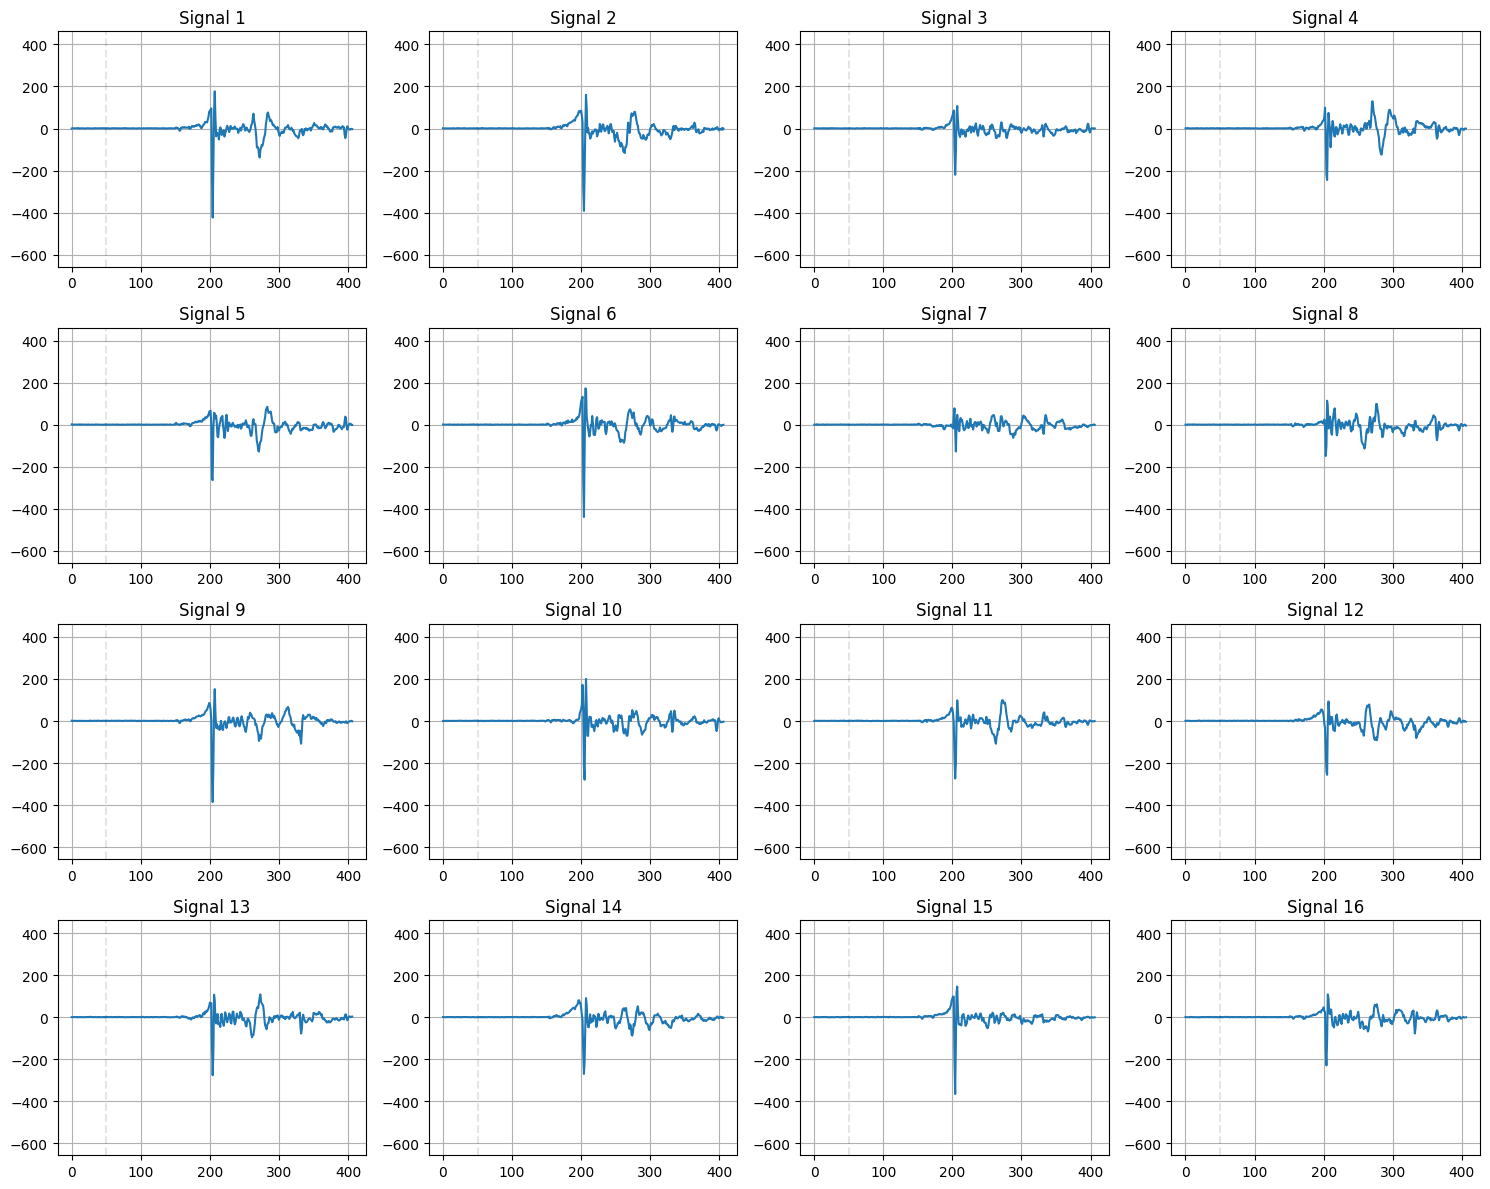

[12/32][0/188]	Loss_D: 0.7063	Loss_G: 1.8764	D(x): 0.8398	D(G(z)): 0.2732 / 0.2035
[12/32][50/188]	Loss_D: 0.6755	Loss_G: 1.9980	D(x): 0.8654	D(G(z)): 0.2410 / 0.1913
[12/32][100/188]	Loss_D: 0.7072	Loss_G: 1.7667	D(x): 0.8275	D(G(z)): 0.2320 / 0.2317
[12/32][150/188]	Loss_D: 0.6962	Loss_G: 1.8877	D(x): 0.8417	D(G(z)): 0.2625 / 0.2129
Epoch 12: SGD Discriminator lr 0.0000162 -> 0.0000159
Epoch 12: SGD Generator lr 0.0000162 -> 0.0000159


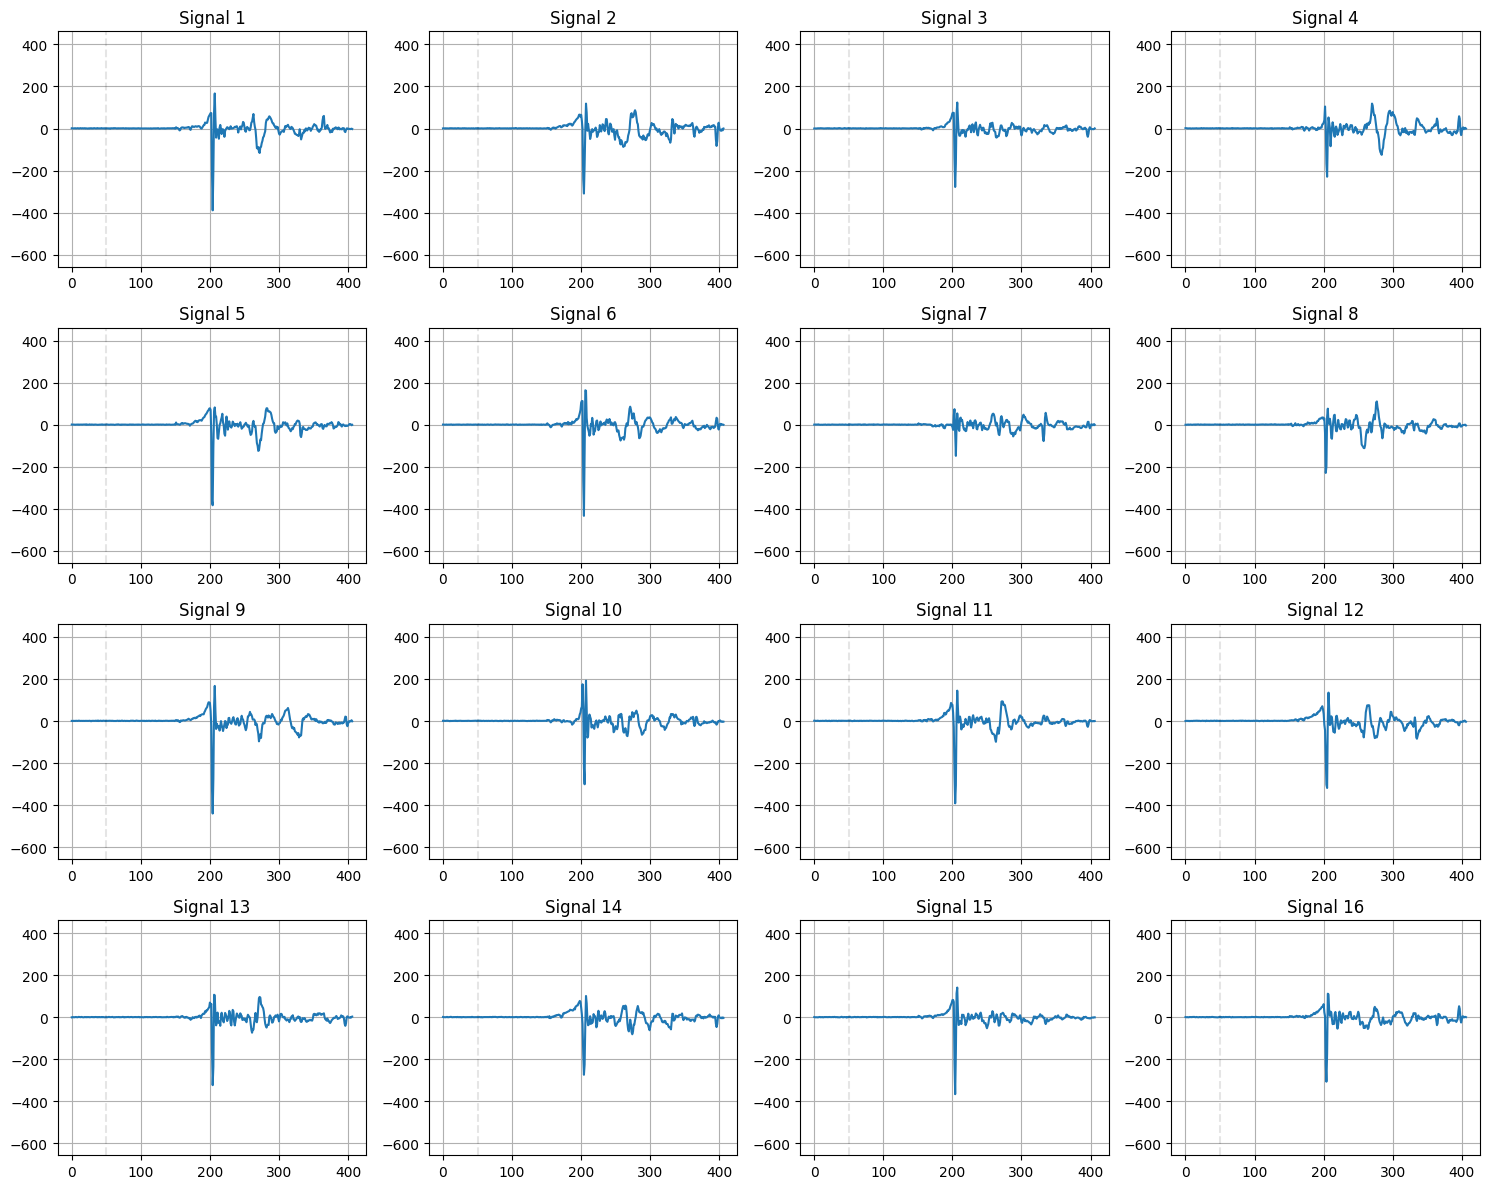

[13/32][0/188]	Loss_D: 0.6485	Loss_G: 1.3369	D(x): 0.8756	D(G(z)): 0.2440 / 0.3181
[13/32][50/188]	Loss_D: 0.7306	Loss_G: 1.5120	D(x): 0.8438	D(G(z)): 0.3268 / 0.2786
[13/32][100/188]	Loss_D: 0.6817	Loss_G: 1.8388	D(x): 0.8041	D(G(z)): 0.1882 / 0.2363
[13/32][150/188]	Loss_D: 0.7312	Loss_G: 1.5447	D(x): 0.8125	D(G(z)): 0.1612 / 0.2729
Epoch 13: SGD Discriminator lr 0.0000159 -> 0.0000156
Epoch 13: SGD Generator lr 0.0000159 -> 0.0000156


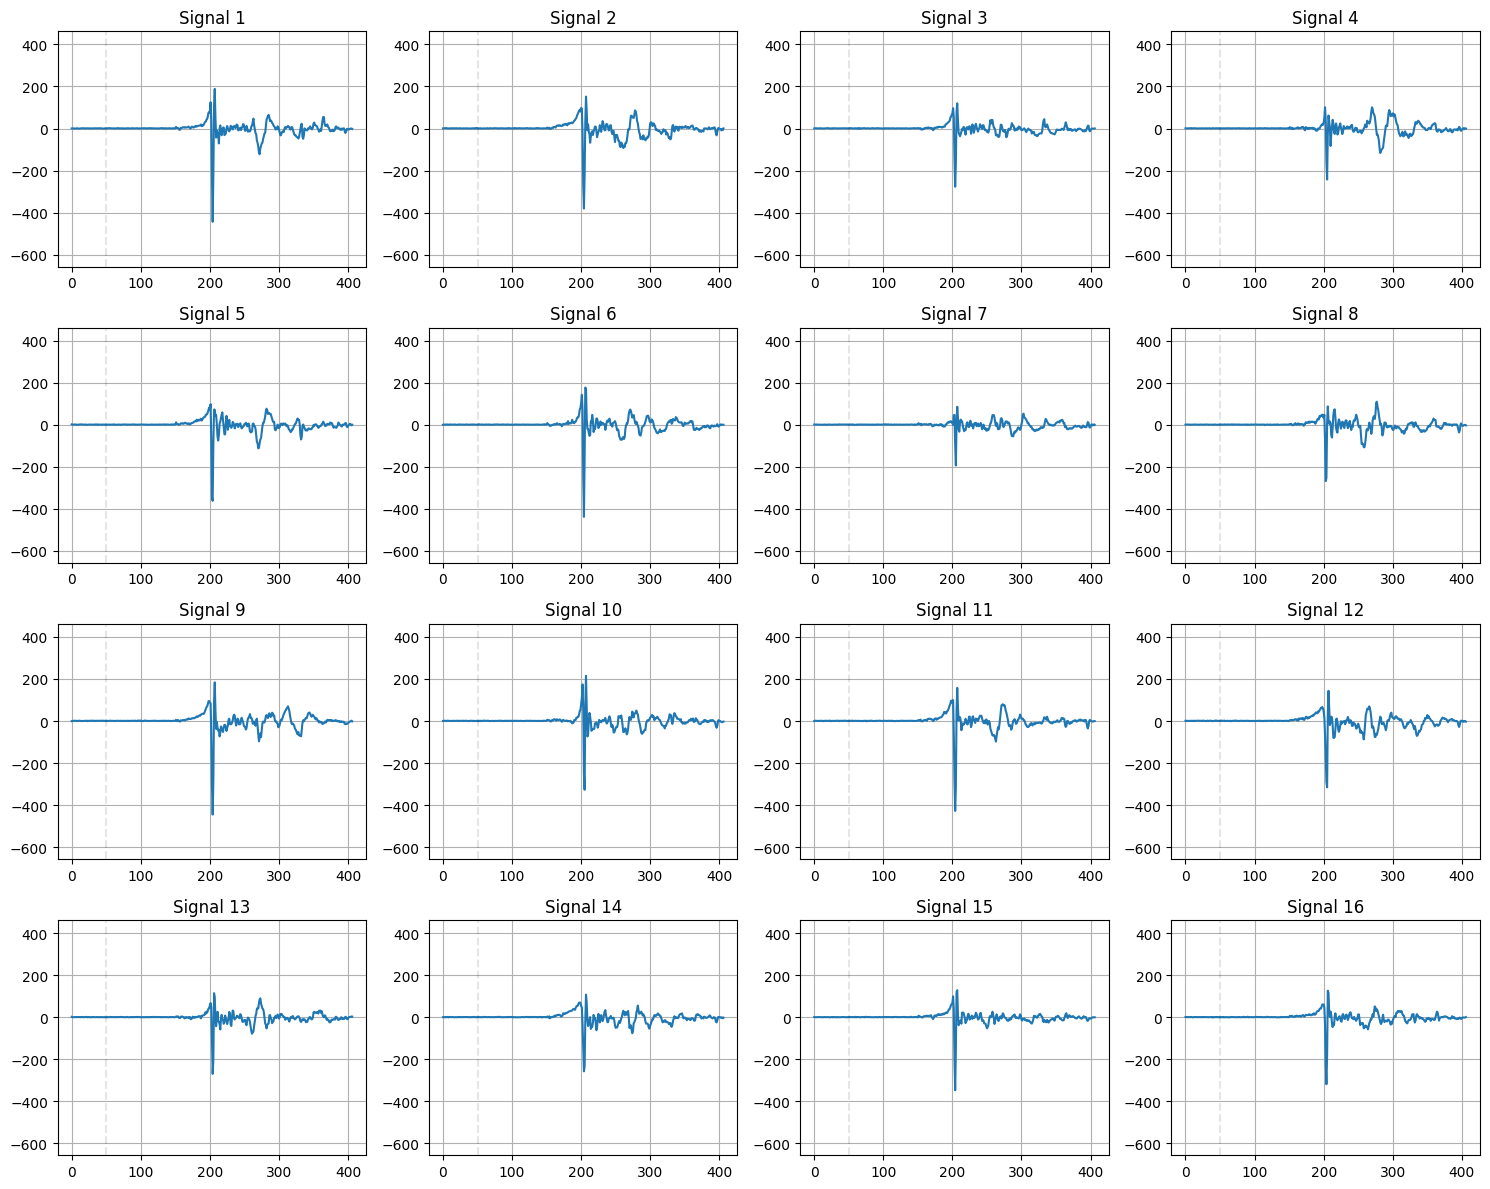

[14/32][0/188]	Loss_D: 0.7048	Loss_G: 1.4978	D(x): 0.8327	D(G(z)): 0.2653 / 0.2798
[14/32][50/188]	Loss_D: 0.6576	Loss_G: 1.5137	D(x): 0.8981	D(G(z)): 0.2935 / 0.2725
[14/32][100/188]	Loss_D: 0.8810	Loss_G: 1.8332	D(x): 0.7539	D(G(z)): 0.2690 / 0.2260
[14/32][150/188]	Loss_D: 0.6921	Loss_G: 1.8059	D(x): 0.8843	D(G(z)): 0.2845 / 0.2599
Epoch 14: SGD Discriminator lr 0.0000156 -> 0.0000153
Epoch 14: SGD Generator lr 0.0000156 -> 0.0000153


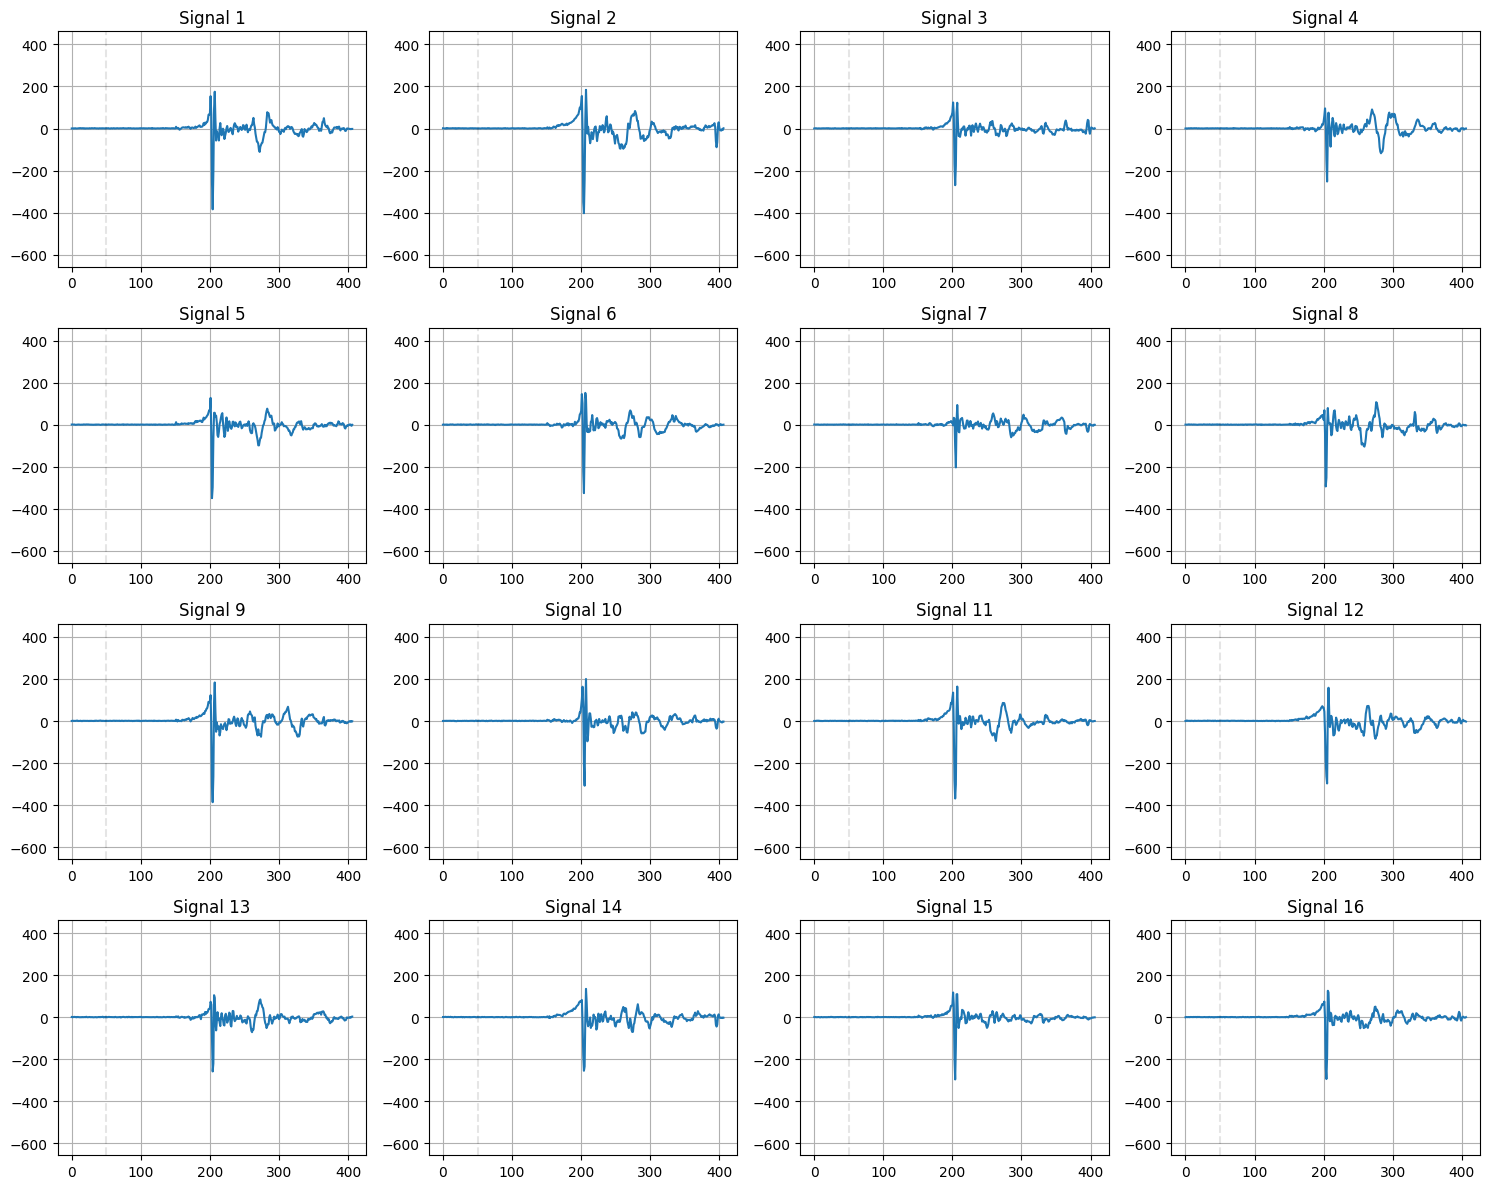

[15/32][0/188]	Loss_D: 0.6896	Loss_G: 1.9014	D(x): 0.8335	D(G(z)): 0.1826 / 0.2346
[15/32][50/188]	Loss_D: 0.7818	Loss_G: 2.3751	D(x): 0.8335	D(G(z)): 0.2645 / 0.1443
[15/32][100/188]	Loss_D: 0.7417	Loss_G: 1.4802	D(x): 0.8236	D(G(z)): 0.2624 / 0.3031
[15/32][150/188]	Loss_D: 0.6728	Loss_G: 1.5095	D(x): 0.8940	D(G(z)): 0.2861 / 0.2796
Epoch 15: SGD Discriminator lr 0.0000153 -> 0.0000150
Epoch 15: SGD Generator lr 0.0000153 -> 0.0000150


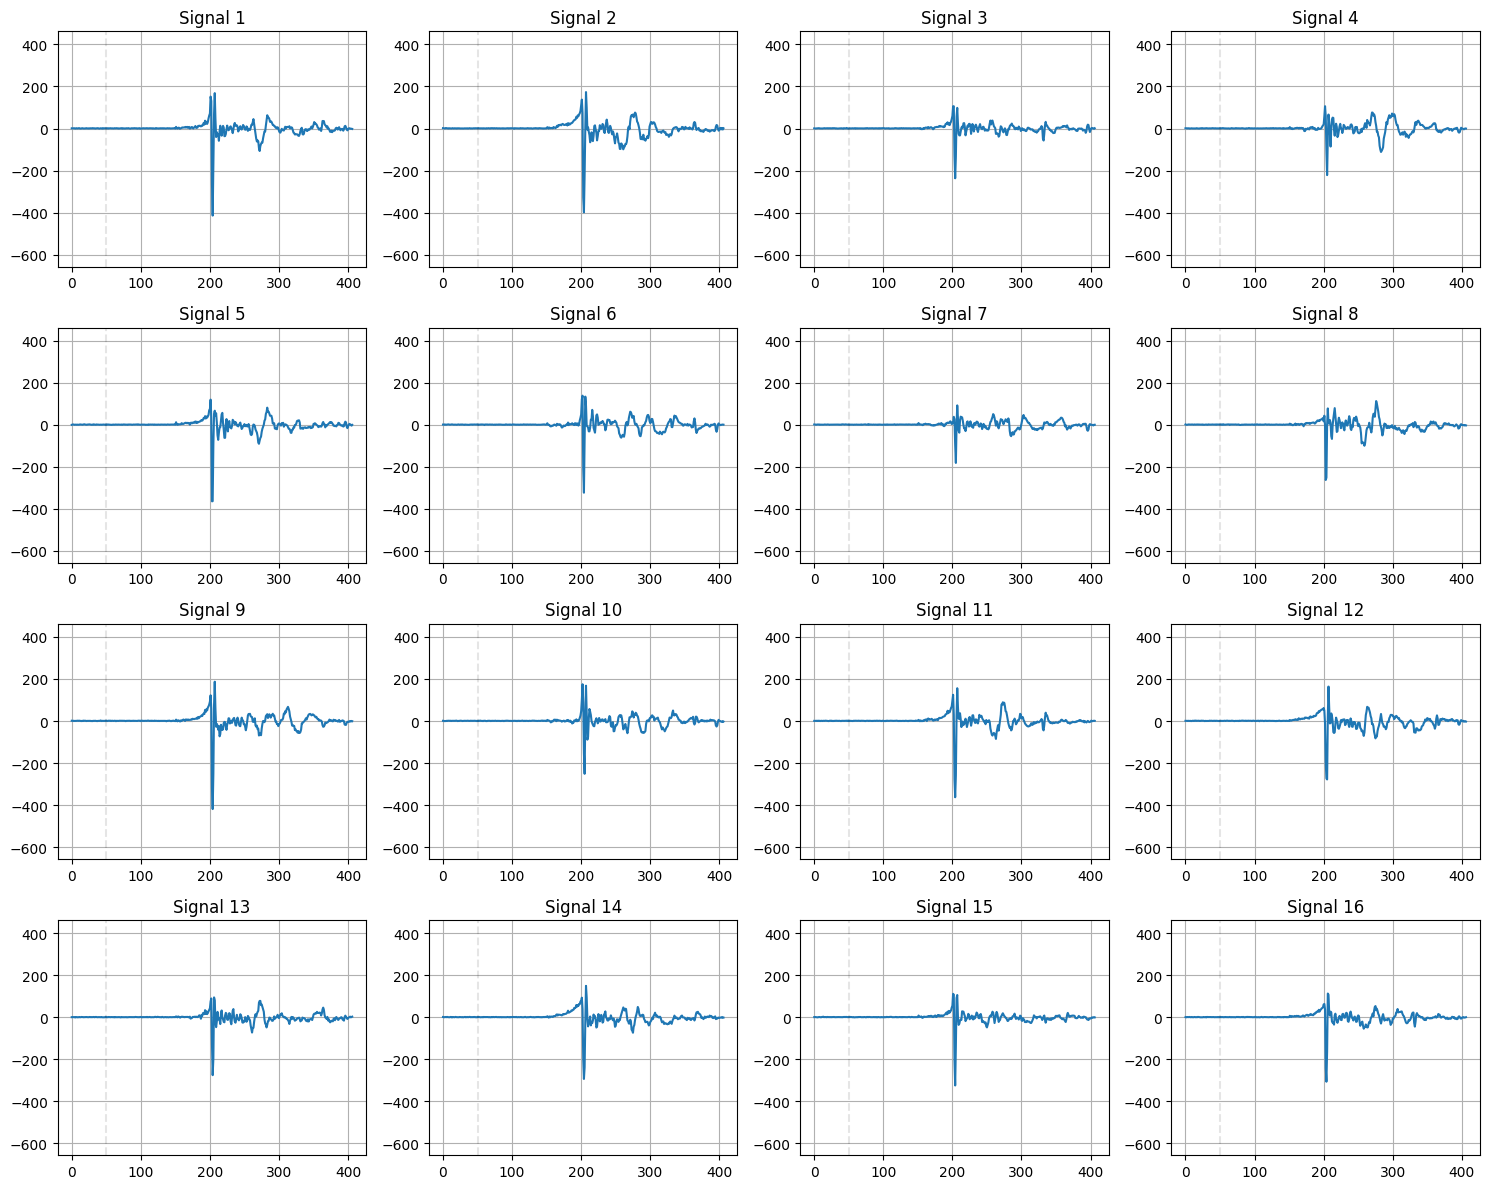

[16/32][0/188]	Loss_D: 0.7338	Loss_G: 2.2170	D(x): 0.8138	D(G(z)): 0.2188 / 0.1847
[16/32][50/188]	Loss_D: 0.8661	Loss_G: 1.4975	D(x): 0.8081	D(G(z)): 0.3184 / 0.2803
[16/32][100/188]	Loss_D: 0.7804	Loss_G: 1.7205	D(x): 0.8106	D(G(z)): 0.2837 / 0.2725
[16/32][150/188]	Loss_D: 0.6277	Loss_G: 2.0643	D(x): 0.8389	D(G(z)): 0.1679 / 0.2127
Epoch 16: SGD Discriminator lr 0.0000150 -> 0.0000147
Epoch 16: SGD Generator lr 0.0000150 -> 0.0000147


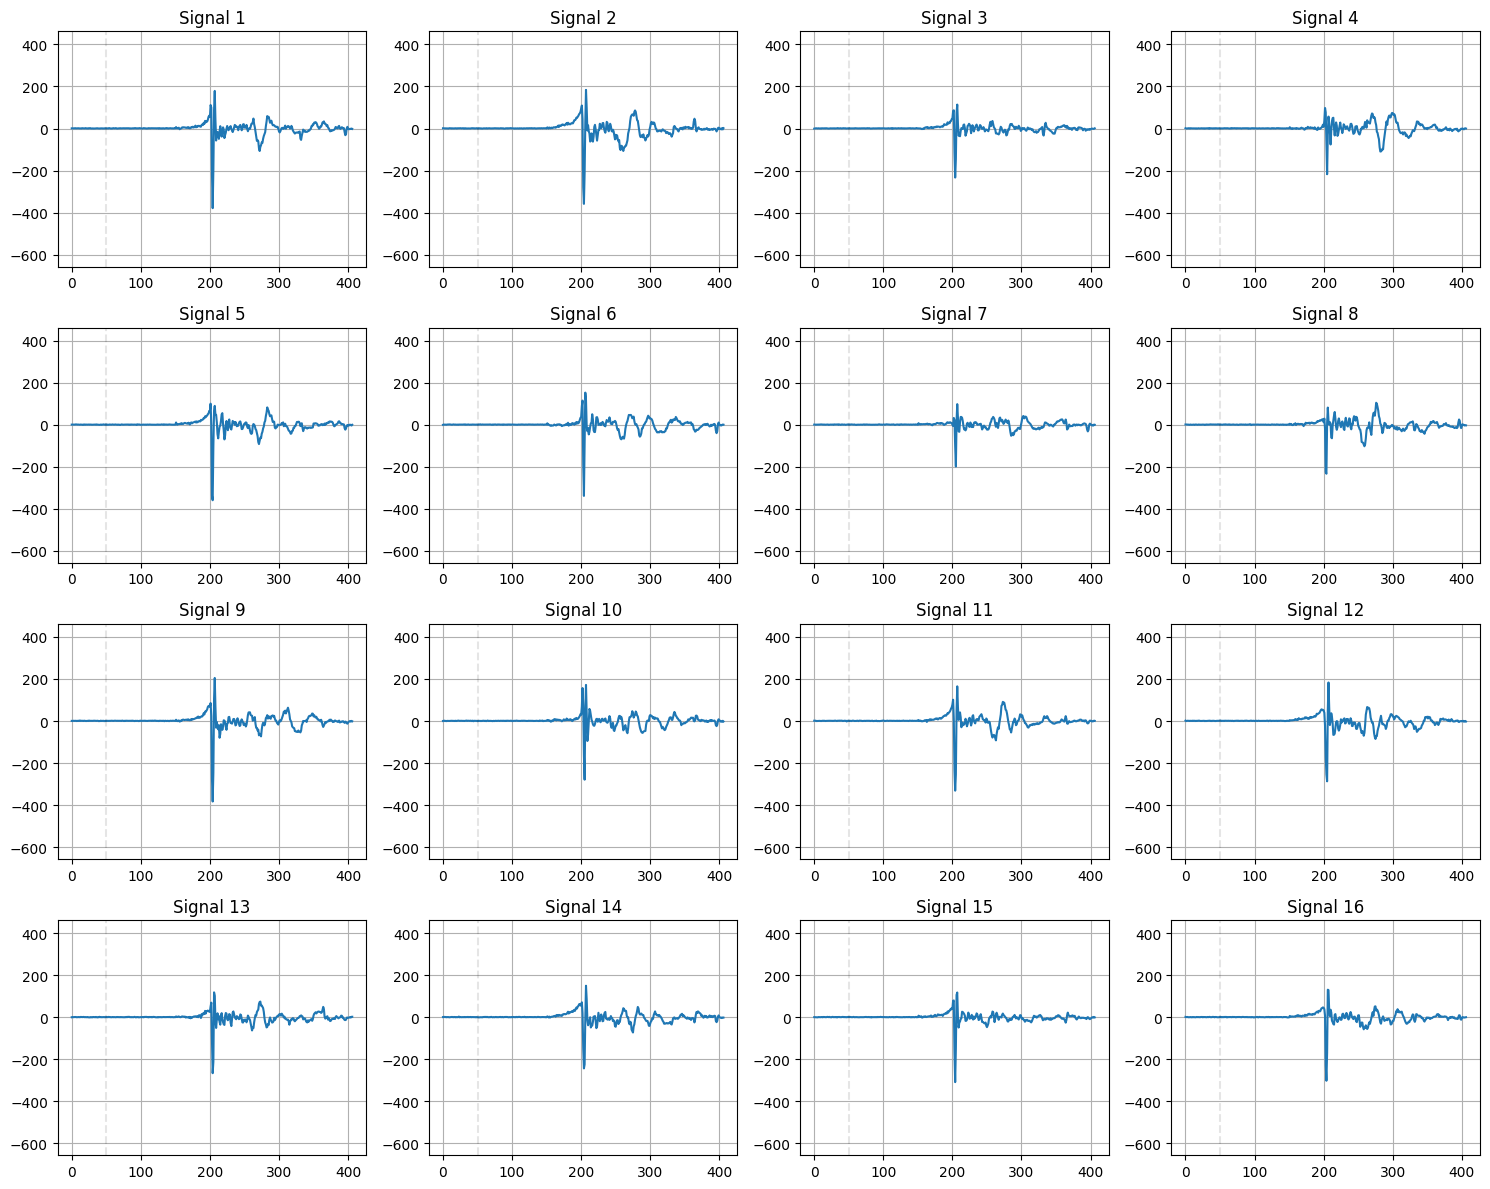

[17/32][0/188]	Loss_D: 0.7071	Loss_G: 1.6631	D(x): 0.8392	D(G(z)): 0.2730 / 0.2728
[17/32][50/188]	Loss_D: 0.7207	Loss_G: 1.8610	D(x): 0.8263	D(G(z)): 0.2539 / 0.2149
[17/32][100/188]	Loss_D: 0.7622	Loss_G: 1.5860	D(x): 0.8291	D(G(z)): 0.3288 / 0.2664
[17/32][150/188]	Loss_D: 0.6872	Loss_G: 2.1752	D(x): 0.8521	D(G(z)): 0.1647 / 0.1993
Epoch 17: SGD Discriminator lr 0.0000147 -> 0.0000144
Epoch 17: SGD Generator lr 0.0000147 -> 0.0000144


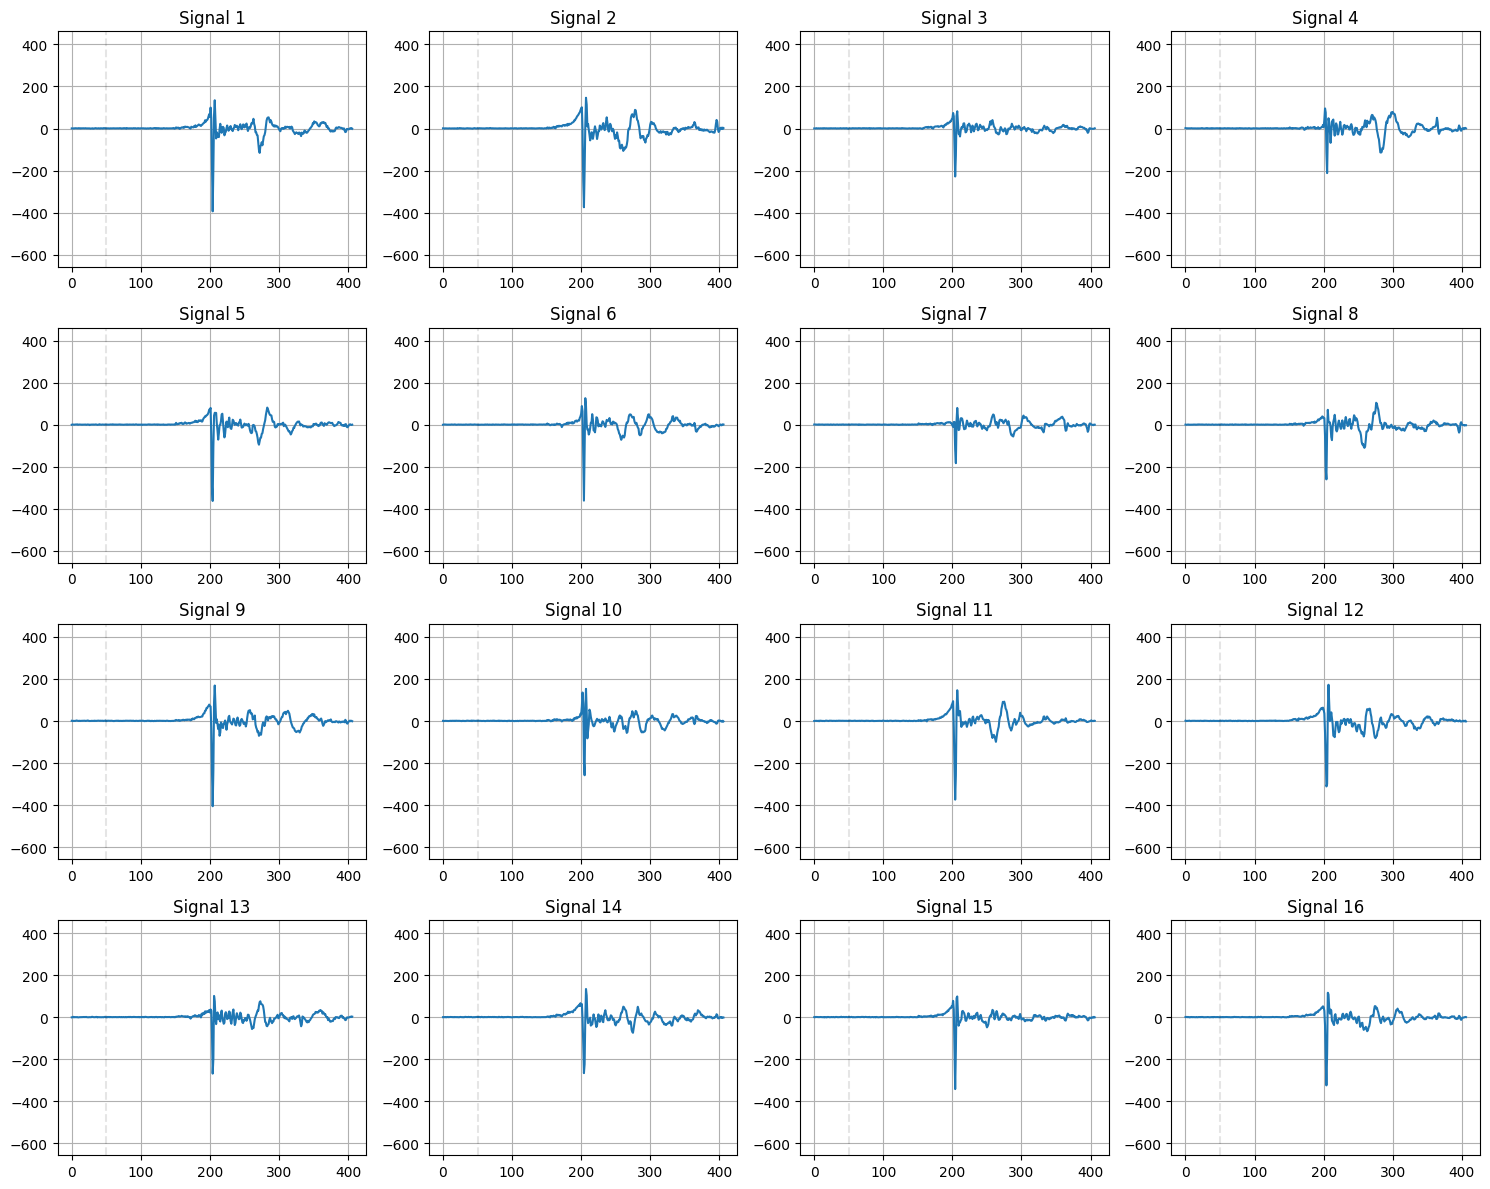

[18/32][0/188]	Loss_D: 0.5888	Loss_G: 1.8261	D(x): 0.9146	D(G(z)): 0.2327 / 0.2133
[18/32][50/188]	Loss_D: 0.5694	Loss_G: 1.8558	D(x): 0.9527	D(G(z)): 0.2613 / 0.2285
[18/32][100/188]	Loss_D: 0.7643	Loss_G: 1.6571	D(x): 0.7994	D(G(z)): 0.2675 / 0.2542
[18/32][150/188]	Loss_D: 0.6246	Loss_G: 1.9792	D(x): 0.9111	D(G(z)): 0.2927 / 0.1933
Epoch 18: SGD Discriminator lr 0.0000144 -> 0.0000141
Epoch 18: SGD Generator lr 0.0000144 -> 0.0000141


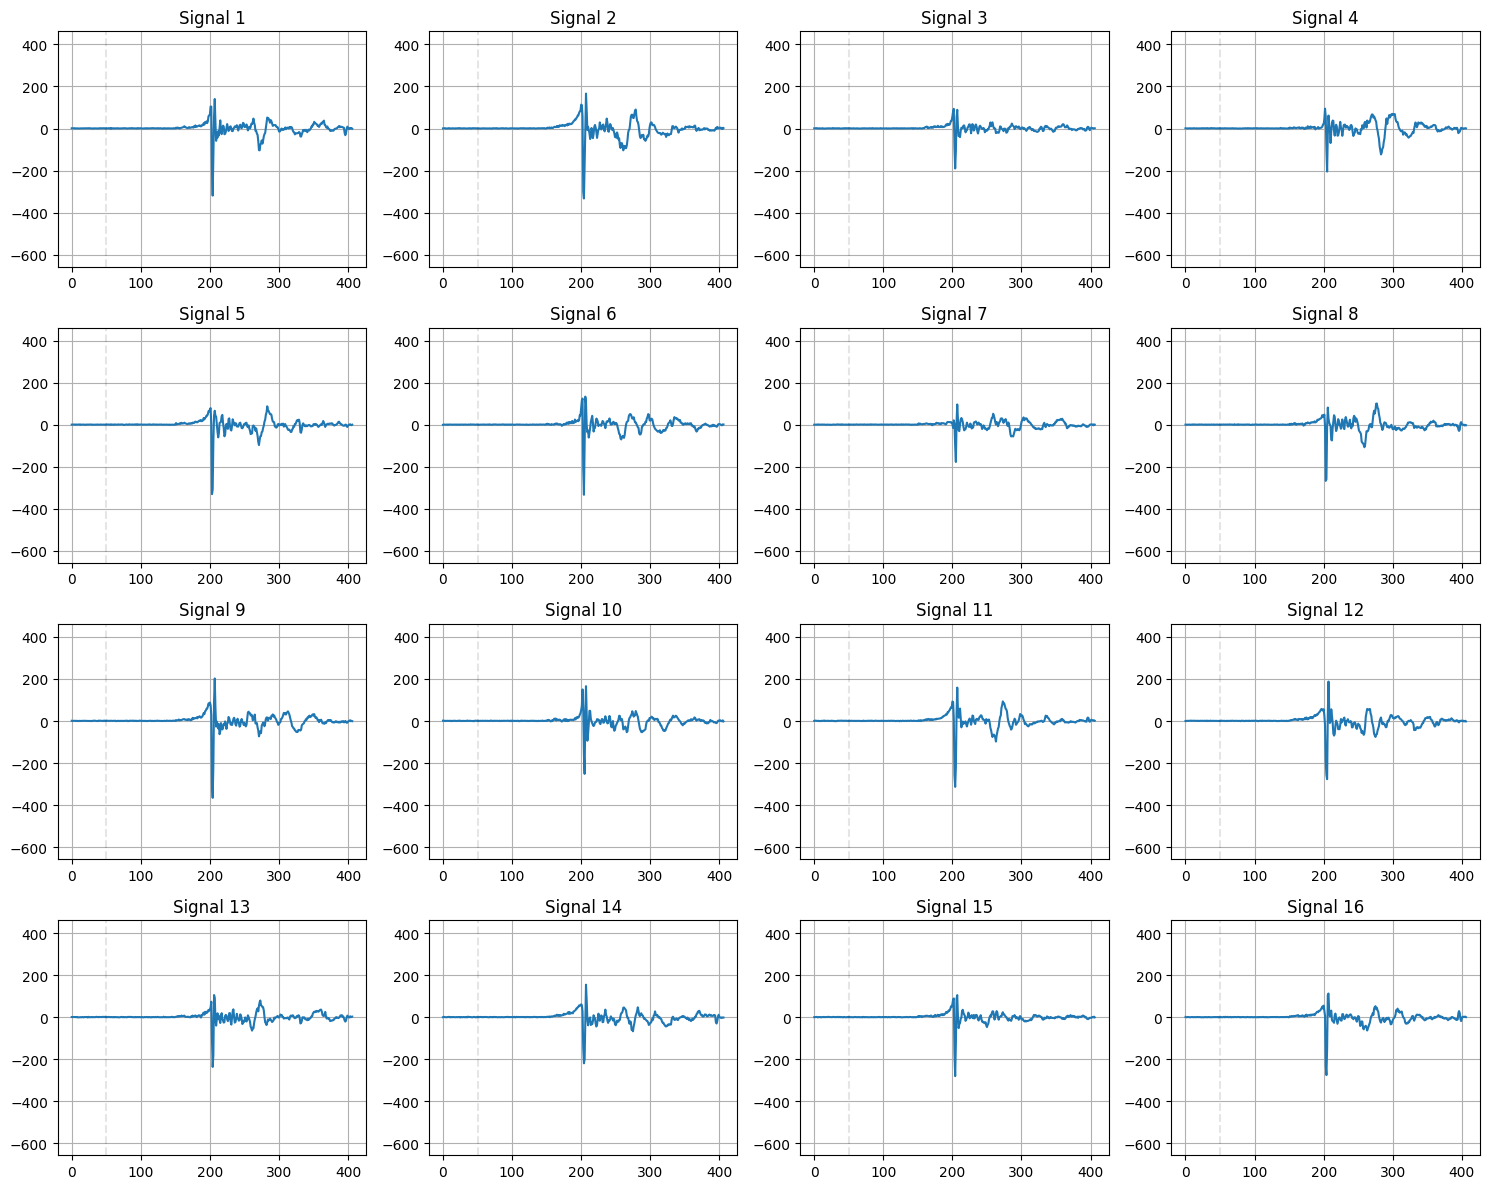

[19/32][0/188]	Loss_D: 0.6442	Loss_G: 2.0396	D(x): 0.8518	D(G(z)): 0.1707 / 0.1974
[19/32][50/188]	Loss_D: 0.8440	Loss_G: 1.5650	D(x): 0.7819	D(G(z)): 0.3369 / 0.2835
[19/32][100/188]	Loss_D: 0.6456	Loss_G: 1.6841	D(x): 0.8221	D(G(z)): 0.2222 / 0.2542
[19/32][150/188]	Loss_D: 0.6410	Loss_G: 1.9078	D(x): 0.8871	D(G(z)): 0.2383 / 0.2248
Epoch 19: SGD Discriminator lr 0.0000141 -> 0.0000137
Epoch 19: SGD Generator lr 0.0000141 -> 0.0000137


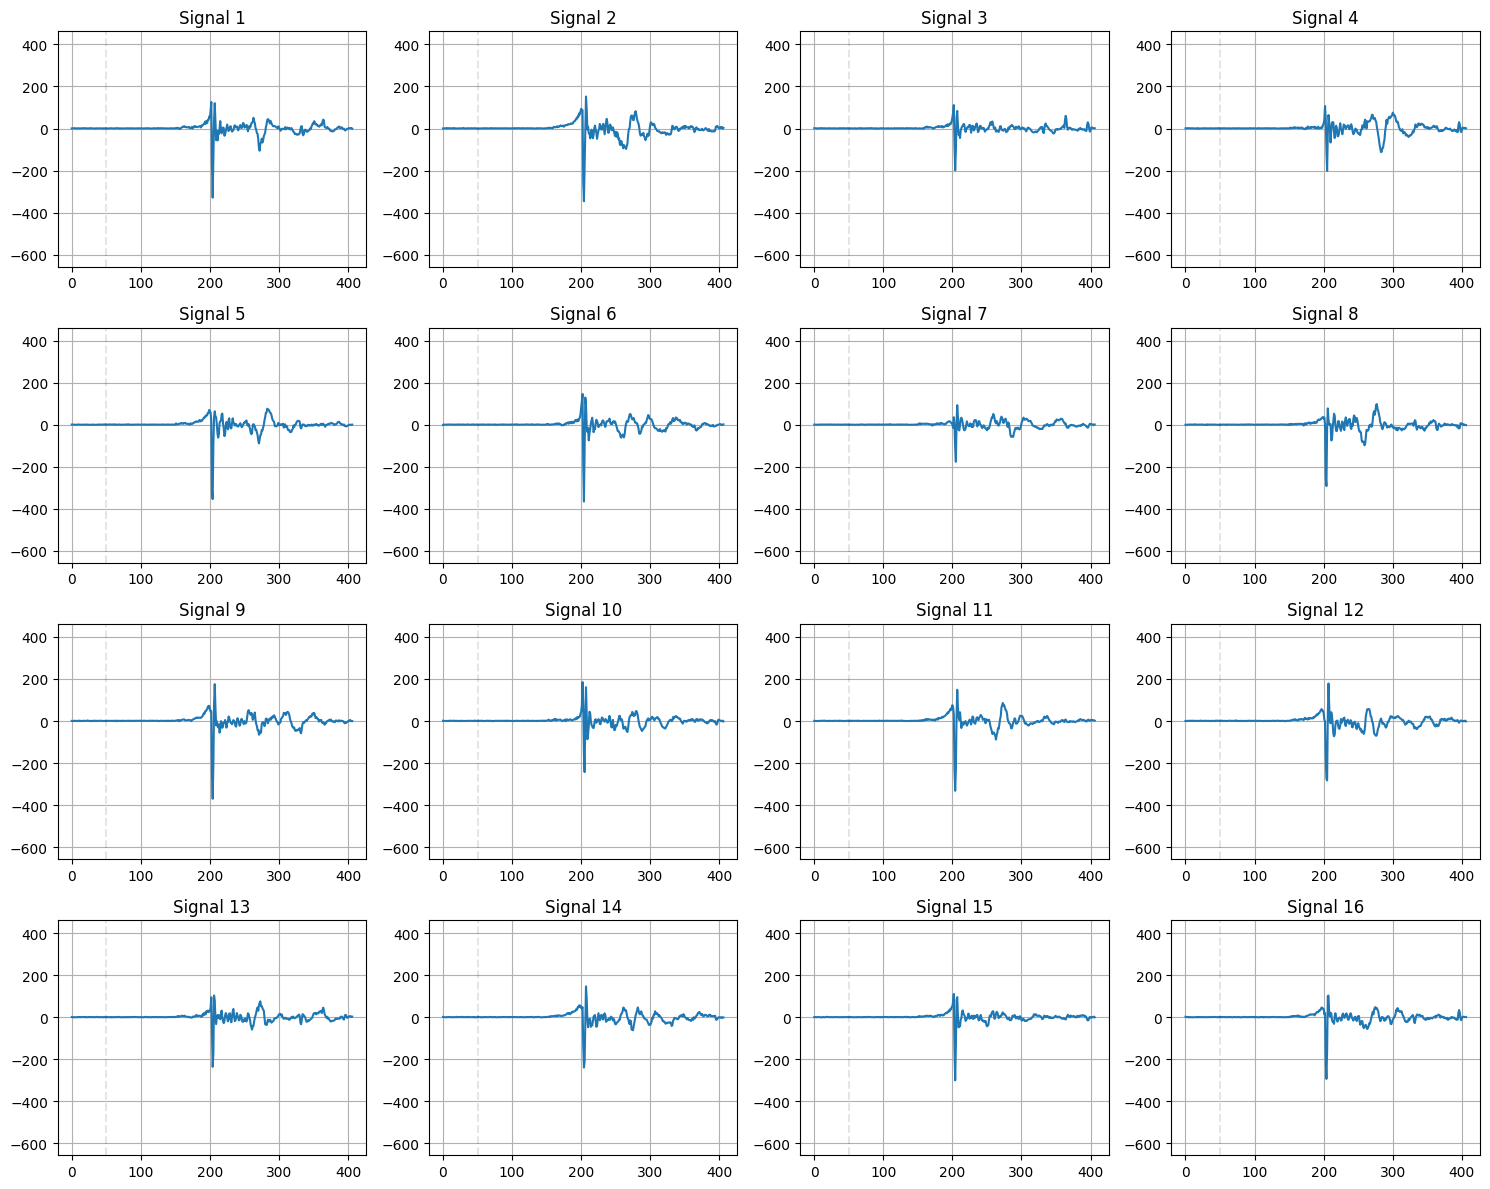

[20/32][0/188]	Loss_D: 0.6599	Loss_G: 1.7268	D(x): 0.8907	D(G(z)): 0.2122 / 0.2487
[20/32][50/188]	Loss_D: 0.7481	Loss_G: 1.5876	D(x): 0.8411	D(G(z)): 0.2323 / 0.2731
[20/32][100/188]	Loss_D: 0.7204	Loss_G: 2.3947	D(x): 0.8374	D(G(z)): 0.1846 / 0.1827
[20/32][150/188]	Loss_D: 0.6825	Loss_G: 1.6386	D(x): 0.8776	D(G(z)): 0.2913 / 0.2869
Epoch 20: SGD Discriminator lr 0.0000137 -> 0.0000134
Epoch 20: SGD Generator lr 0.0000137 -> 0.0000134


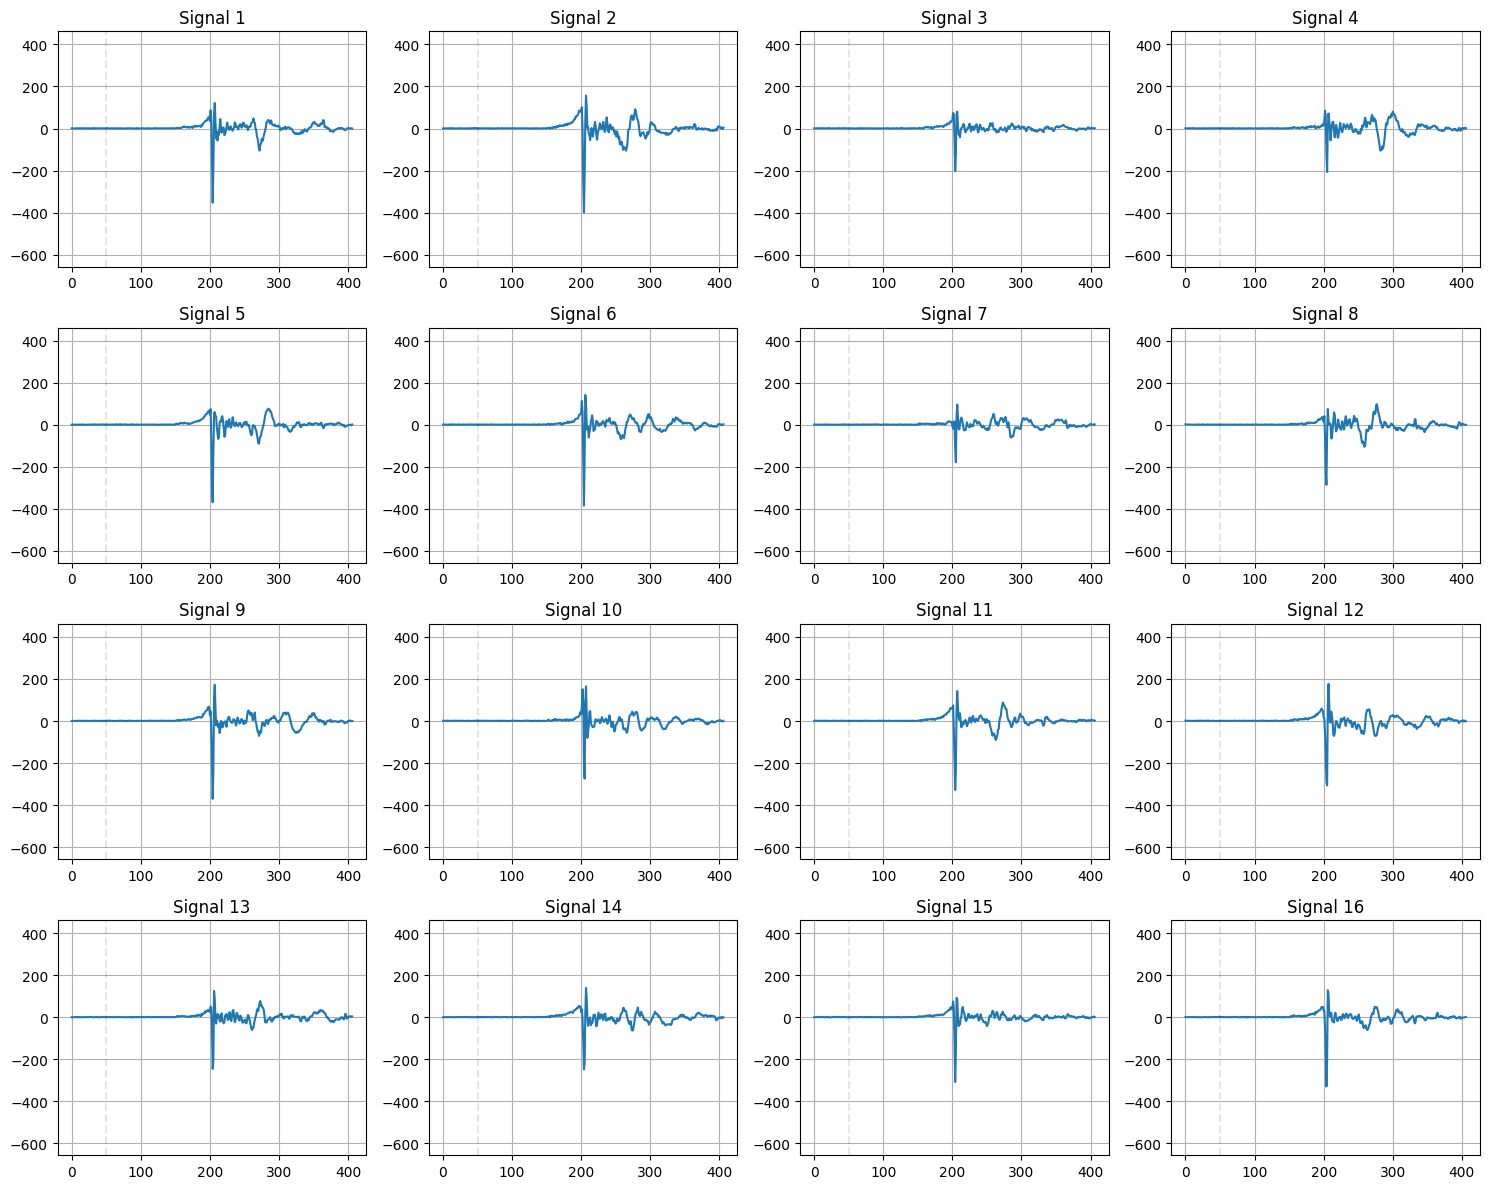

[21/32][0/188]	Loss_D: 0.7244	Loss_G: 1.9084	D(x): 0.8638	D(G(z)): 0.2815 / 0.2431
[21/32][50/188]	Loss_D: 0.6398	Loss_G: 1.9696	D(x): 0.8483	D(G(z)): 0.2016 / 0.2287
[21/32][100/188]	Loss_D: 0.5947	Loss_G: 1.8862	D(x): 0.8832	D(G(z)): 0.1849 / 0.2148
[21/32][150/188]	Loss_D: 0.7165	Loss_G: 1.9345	D(x): 0.8299	D(G(z)): 0.2278 / 0.2190
Epoch 21: SGD Discriminator lr 0.0000134 -> 0.0000131
Epoch 21: SGD Generator lr 0.0000134 -> 0.0000131


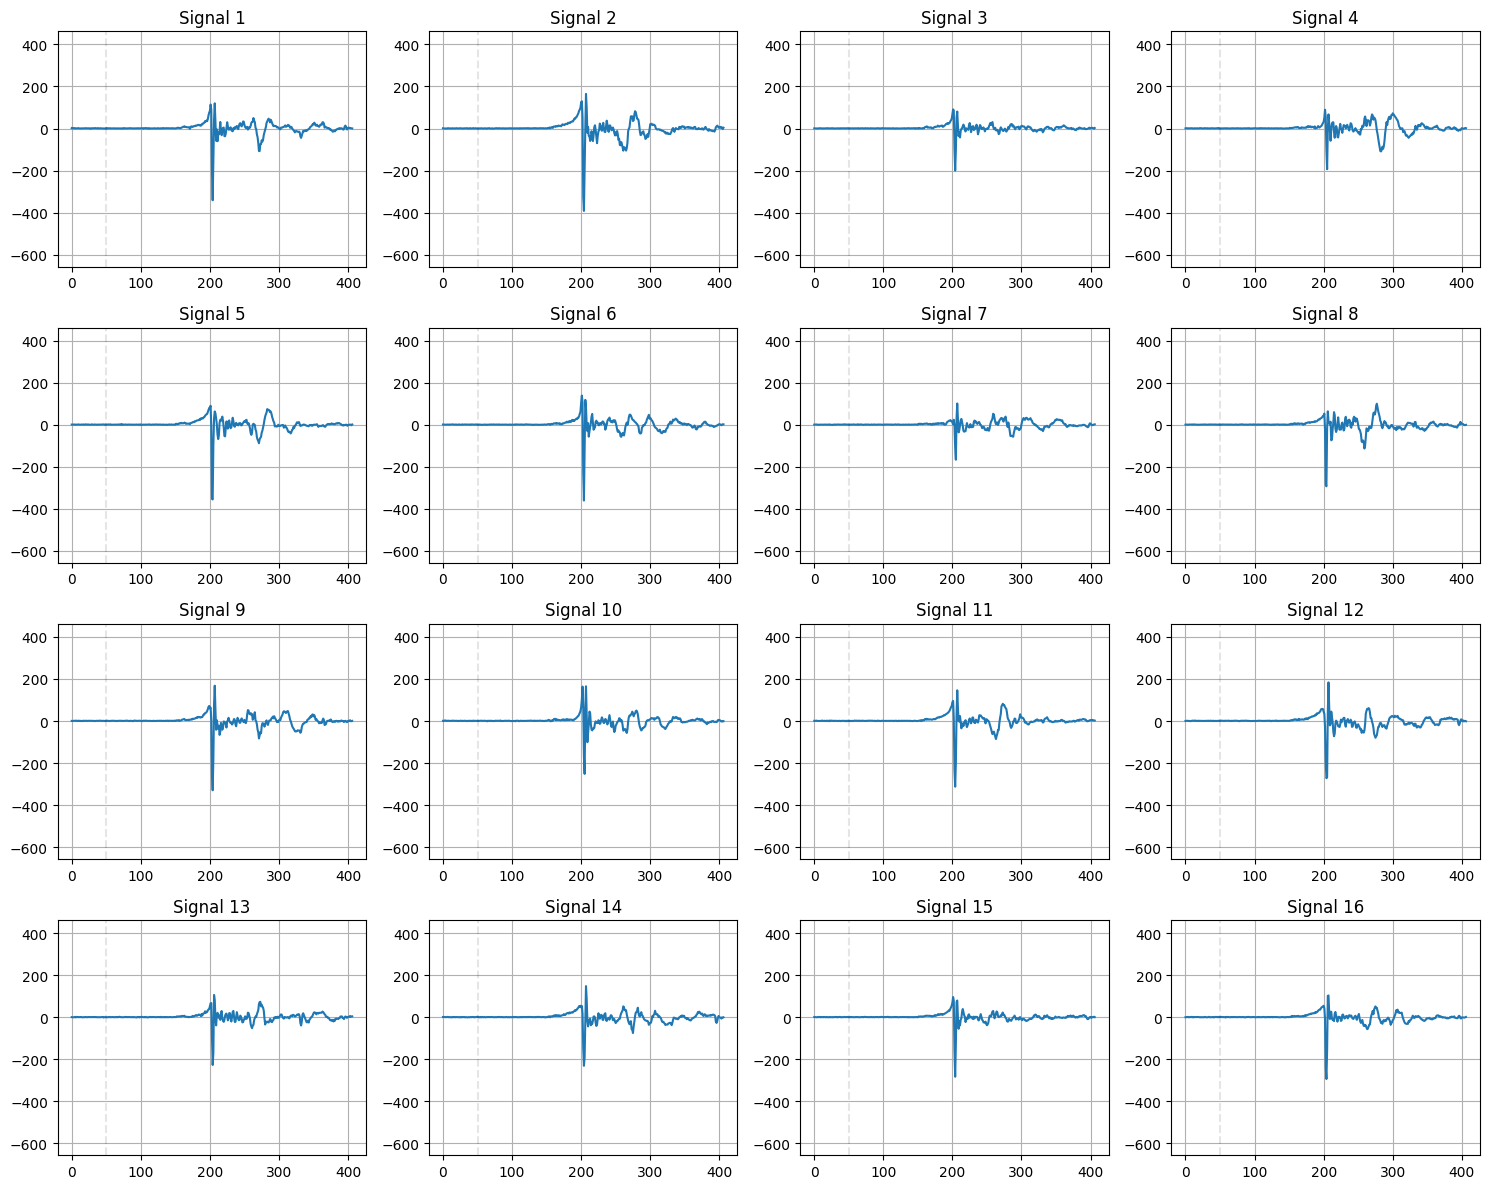

[22/32][0/188]	Loss_D: 0.6622	Loss_G: 1.4019	D(x): 0.8954	D(G(z)): 0.2358 / 0.3046
[22/32][50/188]	Loss_D: 0.7574	Loss_G: 2.1539	D(x): 0.8344	D(G(z)): 0.2113 / 0.1796
[22/32][100/188]	Loss_D: 0.7798	Loss_G: 1.5308	D(x): 0.8318	D(G(z)): 0.3727 / 0.2825
[22/32][150/188]	Loss_D: 0.6165	Loss_G: 1.8270	D(x): 0.8731	D(G(z)): 0.2521 / 0.2319
Epoch 22: SGD Discriminator lr 0.0000131 -> 0.0000128
Epoch 22: SGD Generator lr 0.0000131 -> 0.0000128


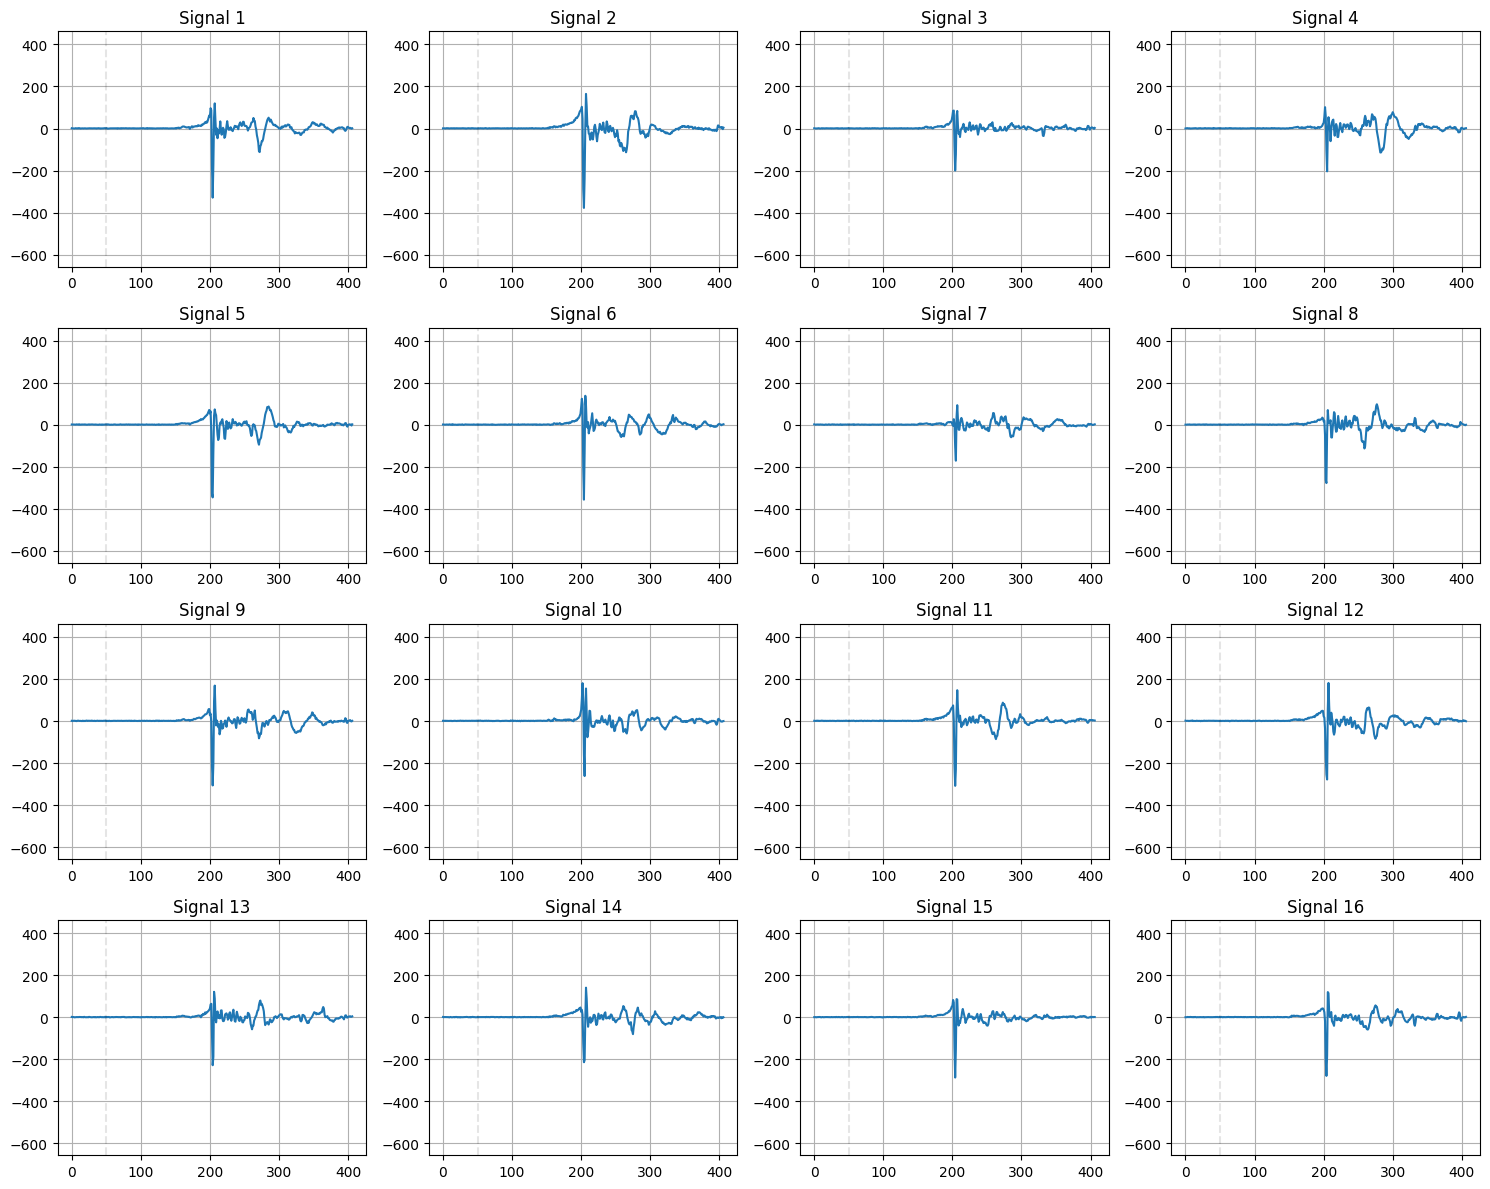

[23/32][0/188]	Loss_D: 0.6916	Loss_G: 1.8826	D(x): 0.8590	D(G(z)): 0.2840 / 0.2234
[23/32][50/188]	Loss_D: 0.6465	Loss_G: 2.2248	D(x): 0.8774	D(G(z)): 0.1824 / 0.1625
[23/32][100/188]	Loss_D: 0.6912	Loss_G: 2.2228	D(x): 0.8697	D(G(z)): 0.2295 / 0.1738
[23/32][150/188]	Loss_D: 0.6958	Loss_G: 1.8217	D(x): 0.8738	D(G(z)): 0.2354 / 0.2488
Epoch 23: SGD Discriminator lr 0.0000128 -> 0.0000125
Epoch 23: SGD Generator lr 0.0000128 -> 0.0000125


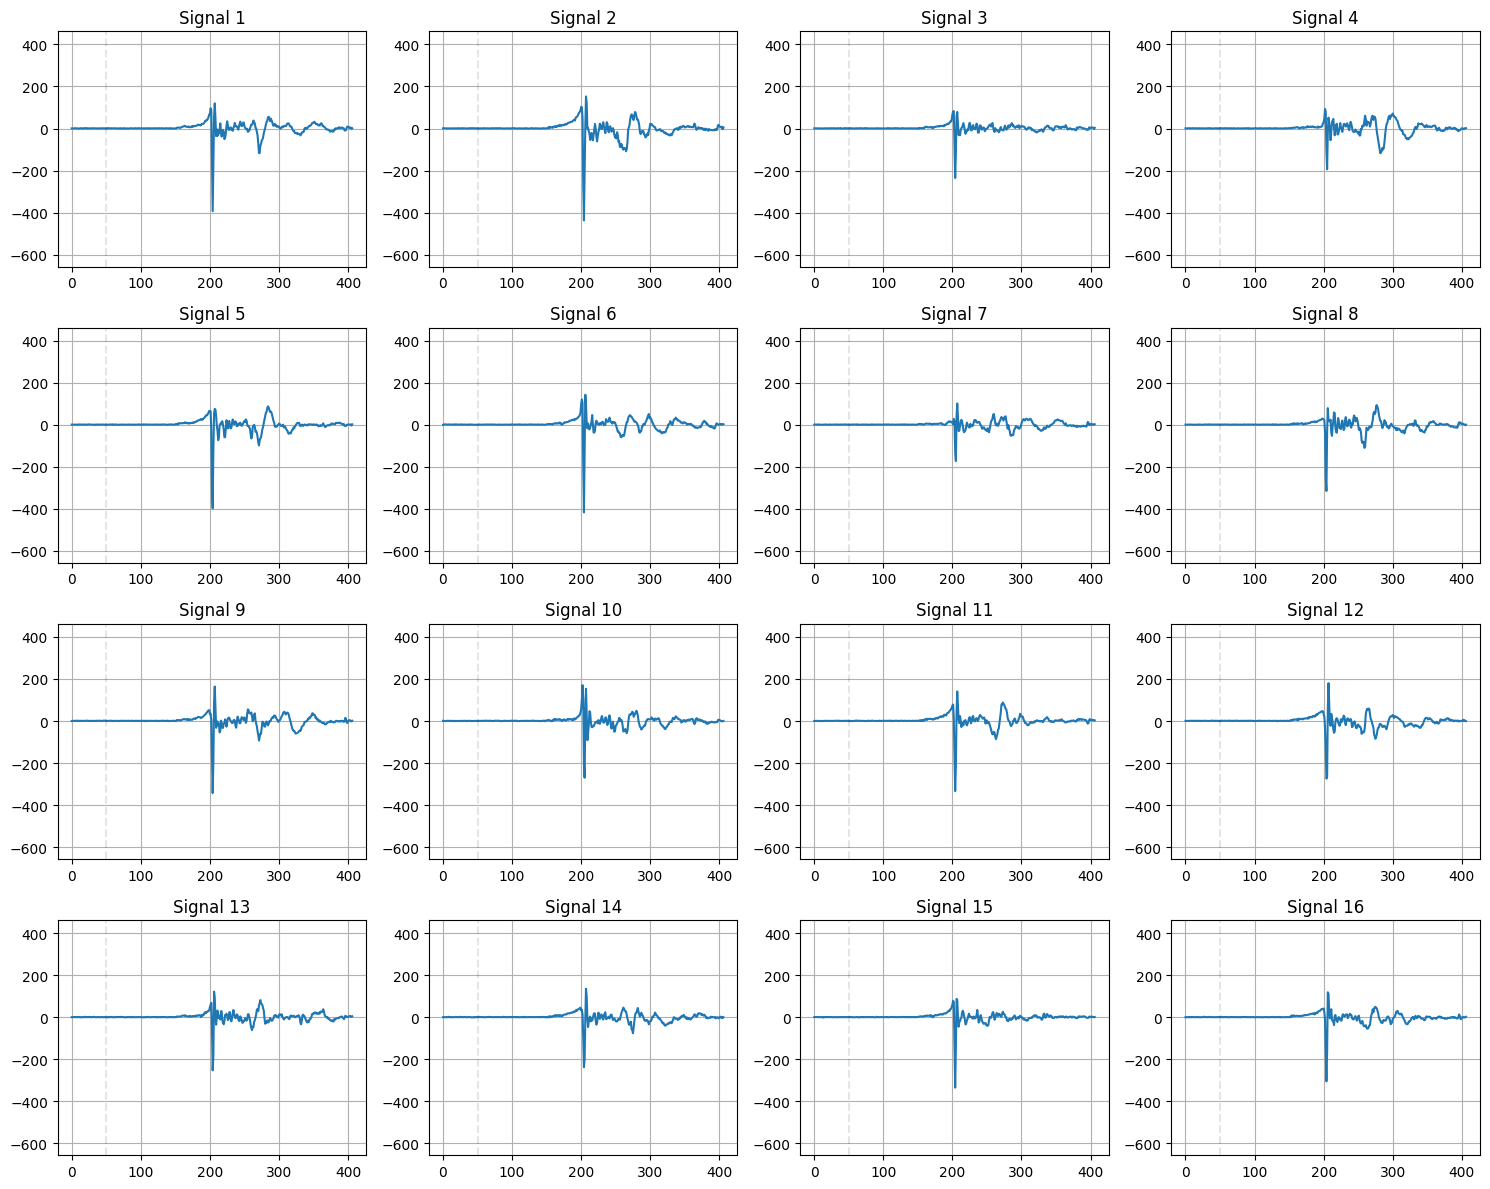

[24/32][0/188]	Loss_D: 0.7329	Loss_G: 1.8978	D(x): 0.8540	D(G(z)): 0.2119 / 0.2453
[24/32][50/188]	Loss_D: 0.6927	Loss_G: 2.2420	D(x): 0.8610	D(G(z)): 0.1585 / 0.1603
[24/32][100/188]	Loss_D: 0.8203	Loss_G: 1.4825	D(x): 0.7884	D(G(z)): 0.3094 / 0.2888
[24/32][150/188]	Loss_D: 0.6540	Loss_G: 1.7620	D(x): 0.8577	D(G(z)): 0.2024 / 0.2564
Epoch 24: SGD Discriminator lr 0.0000125 -> 0.0000122
Epoch 24: SGD Generator lr 0.0000125 -> 0.0000122


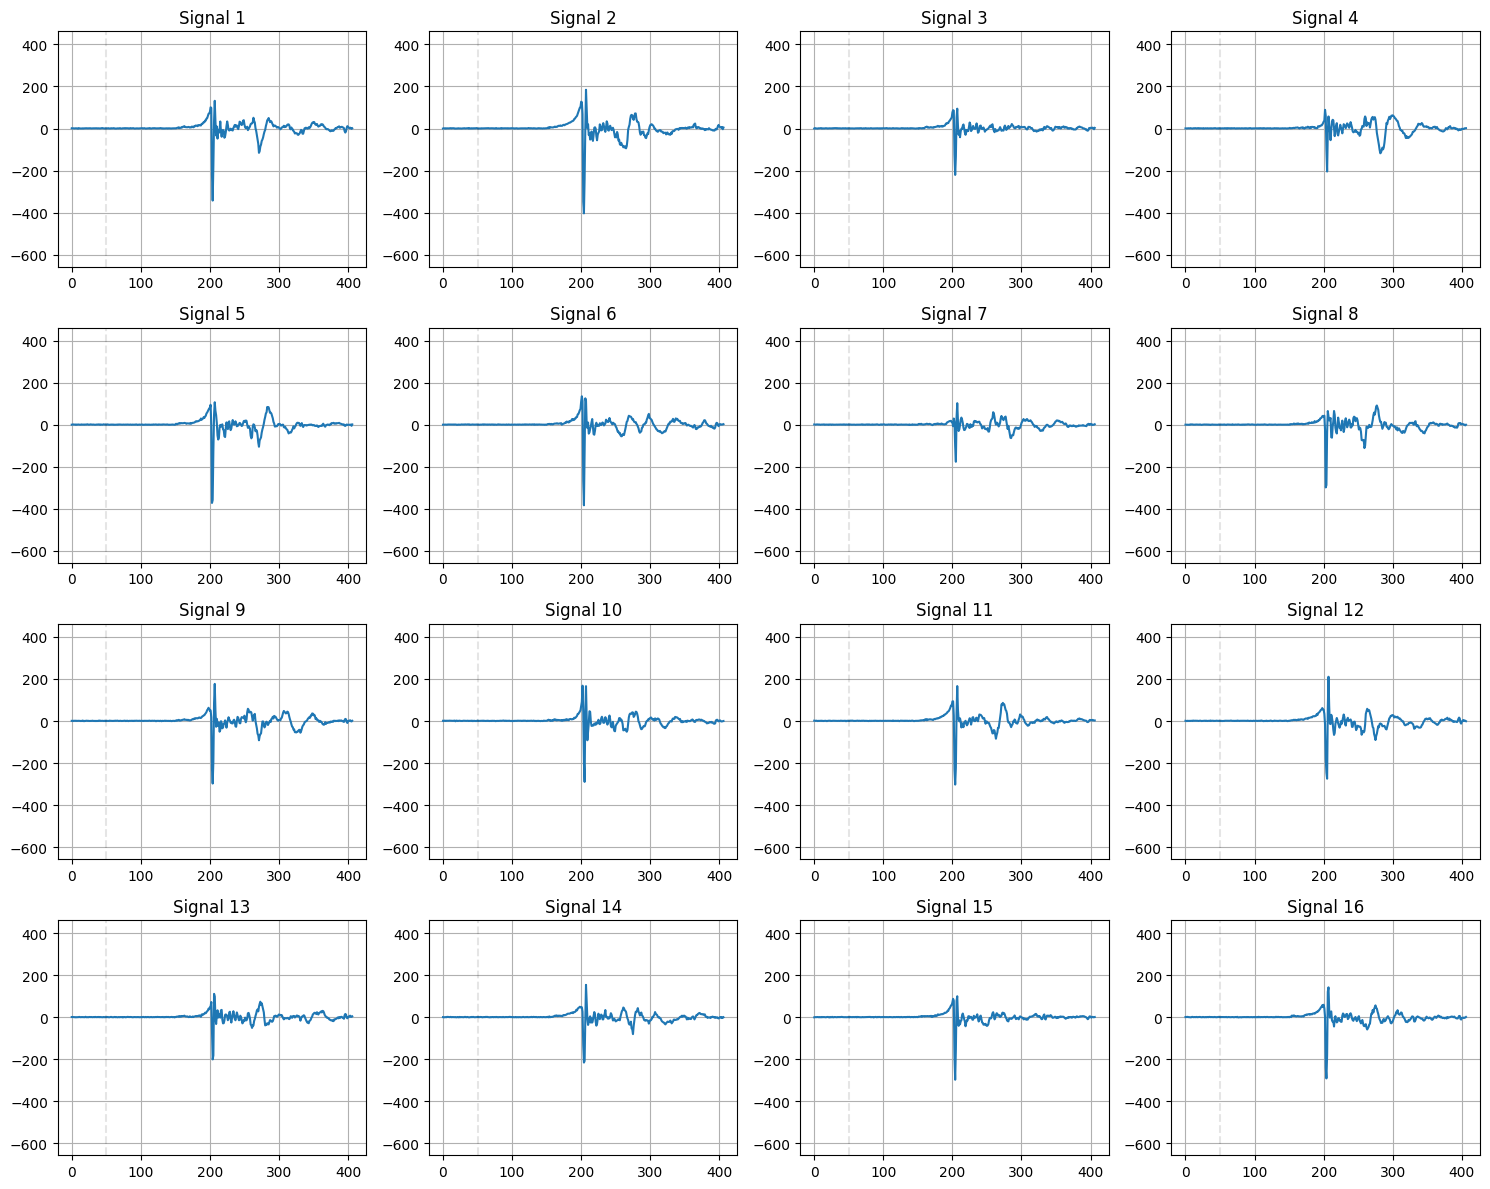

[25/32][0/188]	Loss_D: 0.6951	Loss_G: 1.8487	D(x): 0.8787	D(G(z)): 0.3020 / 0.2286
[25/32][50/188]	Loss_D: 0.6529	Loss_G: 1.6674	D(x): 0.8456	D(G(z)): 0.2686 / 0.2401
[25/32][100/188]	Loss_D: 0.6651	Loss_G: 1.6875	D(x): 0.8924	D(G(z)): 0.2680 / 0.2595
[25/32][150/188]	Loss_D: 0.7321	Loss_G: 2.2944	D(x): 0.8270	D(G(z)): 0.1993 / 0.1691
Epoch 25: SGD Discriminator lr 0.0000122 -> 0.0000119
Epoch 25: SGD Generator lr 0.0000122 -> 0.0000119


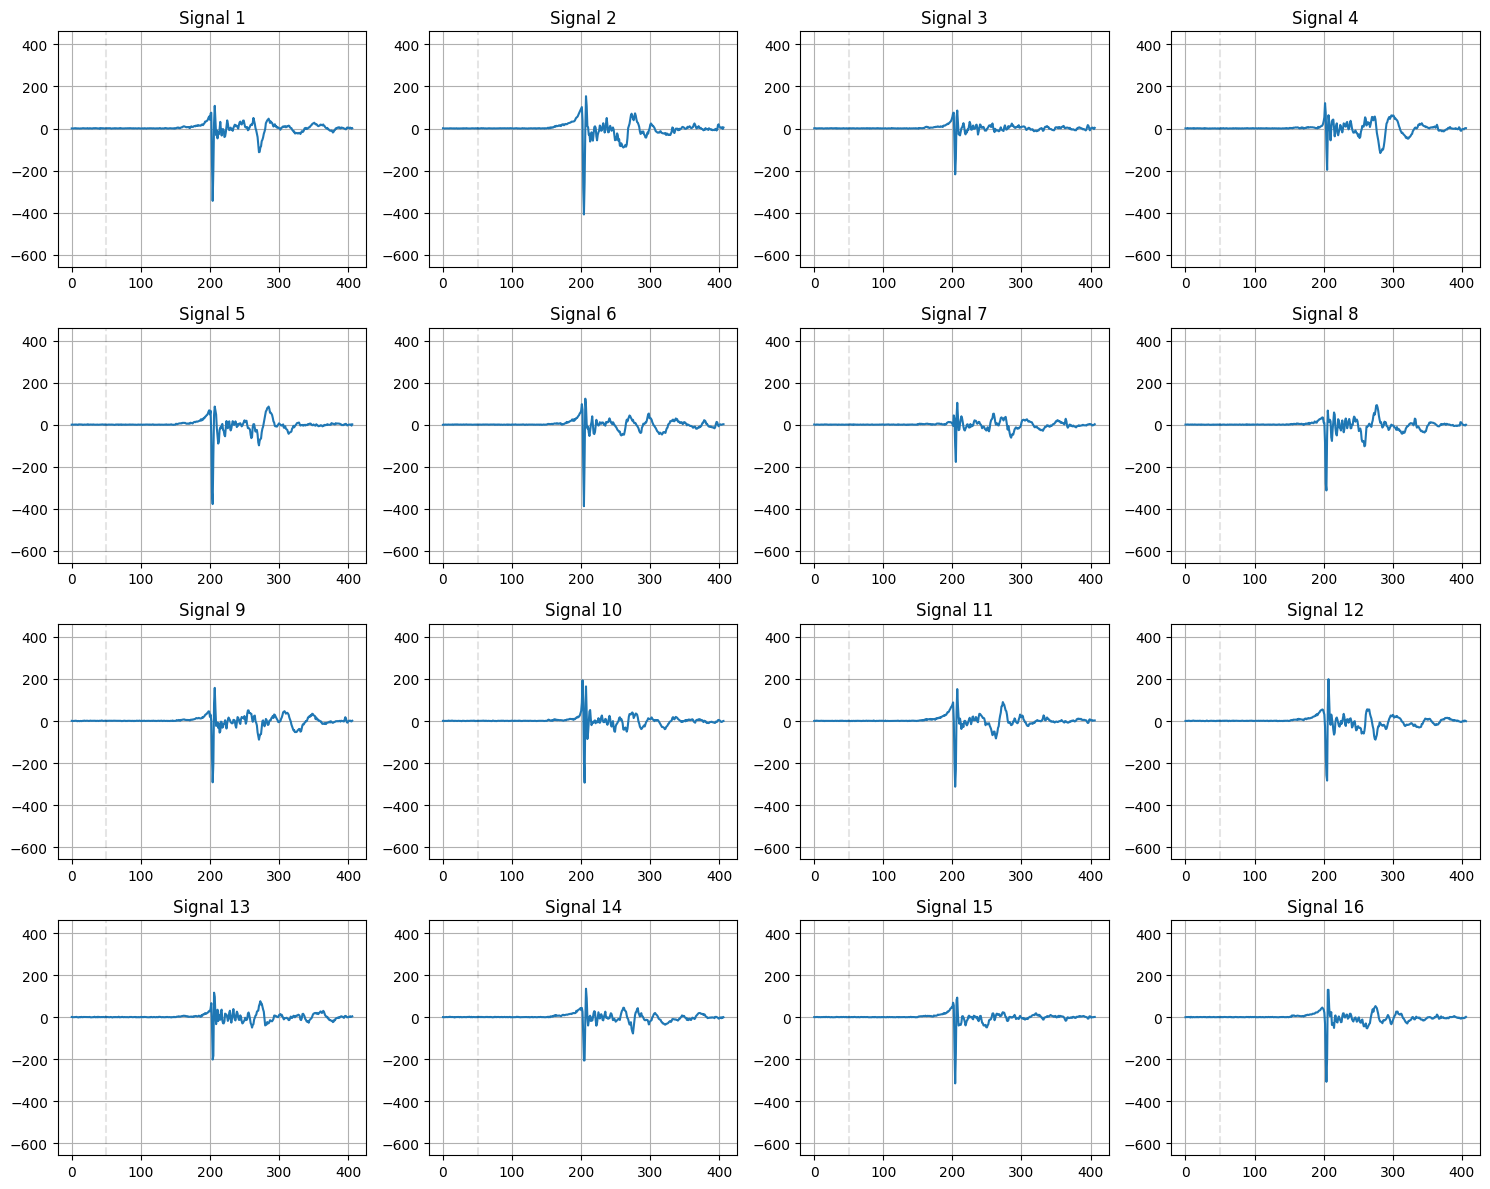

[26/32][0/188]	Loss_D: 0.6337	Loss_G: 1.8058	D(x): 0.8865	D(G(z)): 0.1861 / 0.2707
[26/32][50/188]	Loss_D: 0.7087	Loss_G: 1.8719	D(x): 0.8385	D(G(z)): 0.2205 / 0.2235
[26/32][100/188]	Loss_D: 0.6643	Loss_G: 1.7358	D(x): 0.9204	D(G(z)): 0.3048 / 0.2779
[26/32][150/188]	Loss_D: 0.7868	Loss_G: 2.3476	D(x): 0.8093	D(G(z)): 0.1998 / 0.1689
Epoch 26: SGD Discriminator lr 0.0000119 -> 0.0000116
Epoch 26: SGD Generator lr 0.0000119 -> 0.0000116


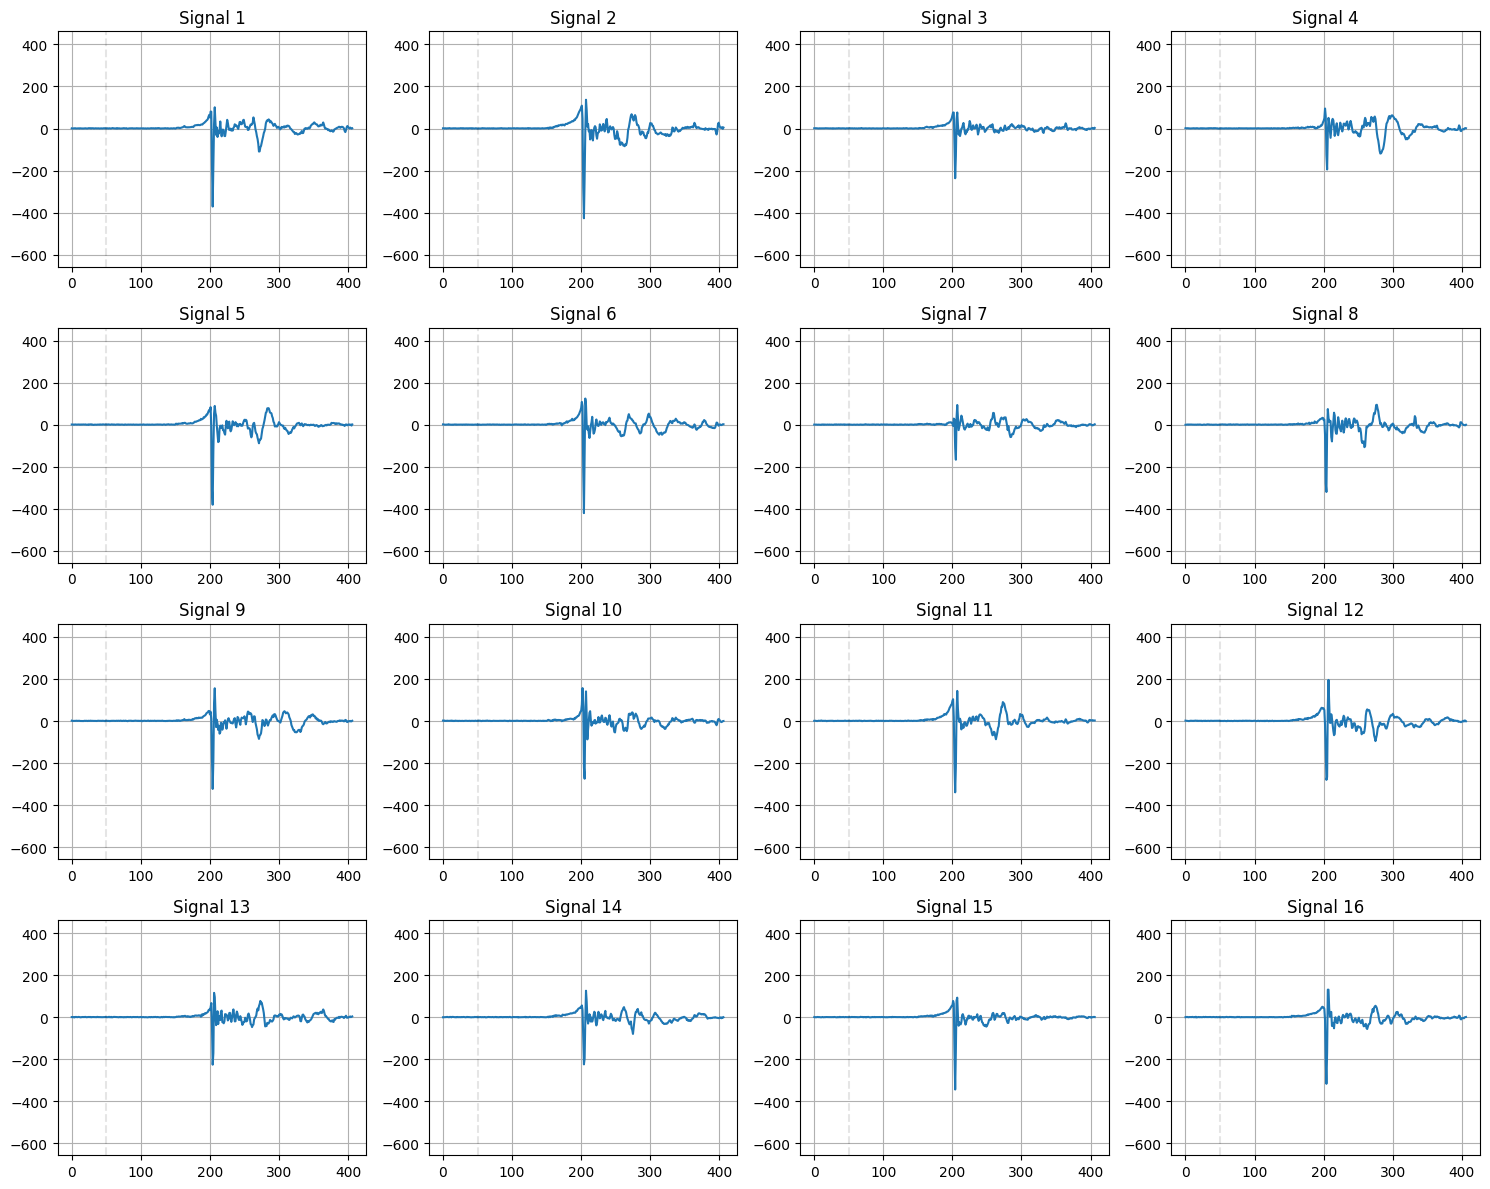

[27/32][0/188]	Loss_D: 0.6829	Loss_G: 1.9435	D(x): 0.8724	D(G(z)): 0.2751 / 0.2355
[27/32][50/188]	Loss_D: 0.7179	Loss_G: 1.8323	D(x): 0.8193	D(G(z)): 0.2074 / 0.2614
[27/32][100/188]	Loss_D: 0.7650	Loss_G: 1.3233	D(x): 0.8003	D(G(z)): 0.2570 / 0.3604
[27/32][150/188]	Loss_D: 0.7394	Loss_G: 1.5015	D(x): 0.8521	D(G(z)): 0.3158 / 0.3026
Epoch 27: SGD Discriminator lr 0.0000116 -> 0.0000112
Epoch 27: SGD Generator lr 0.0000116 -> 0.0000112


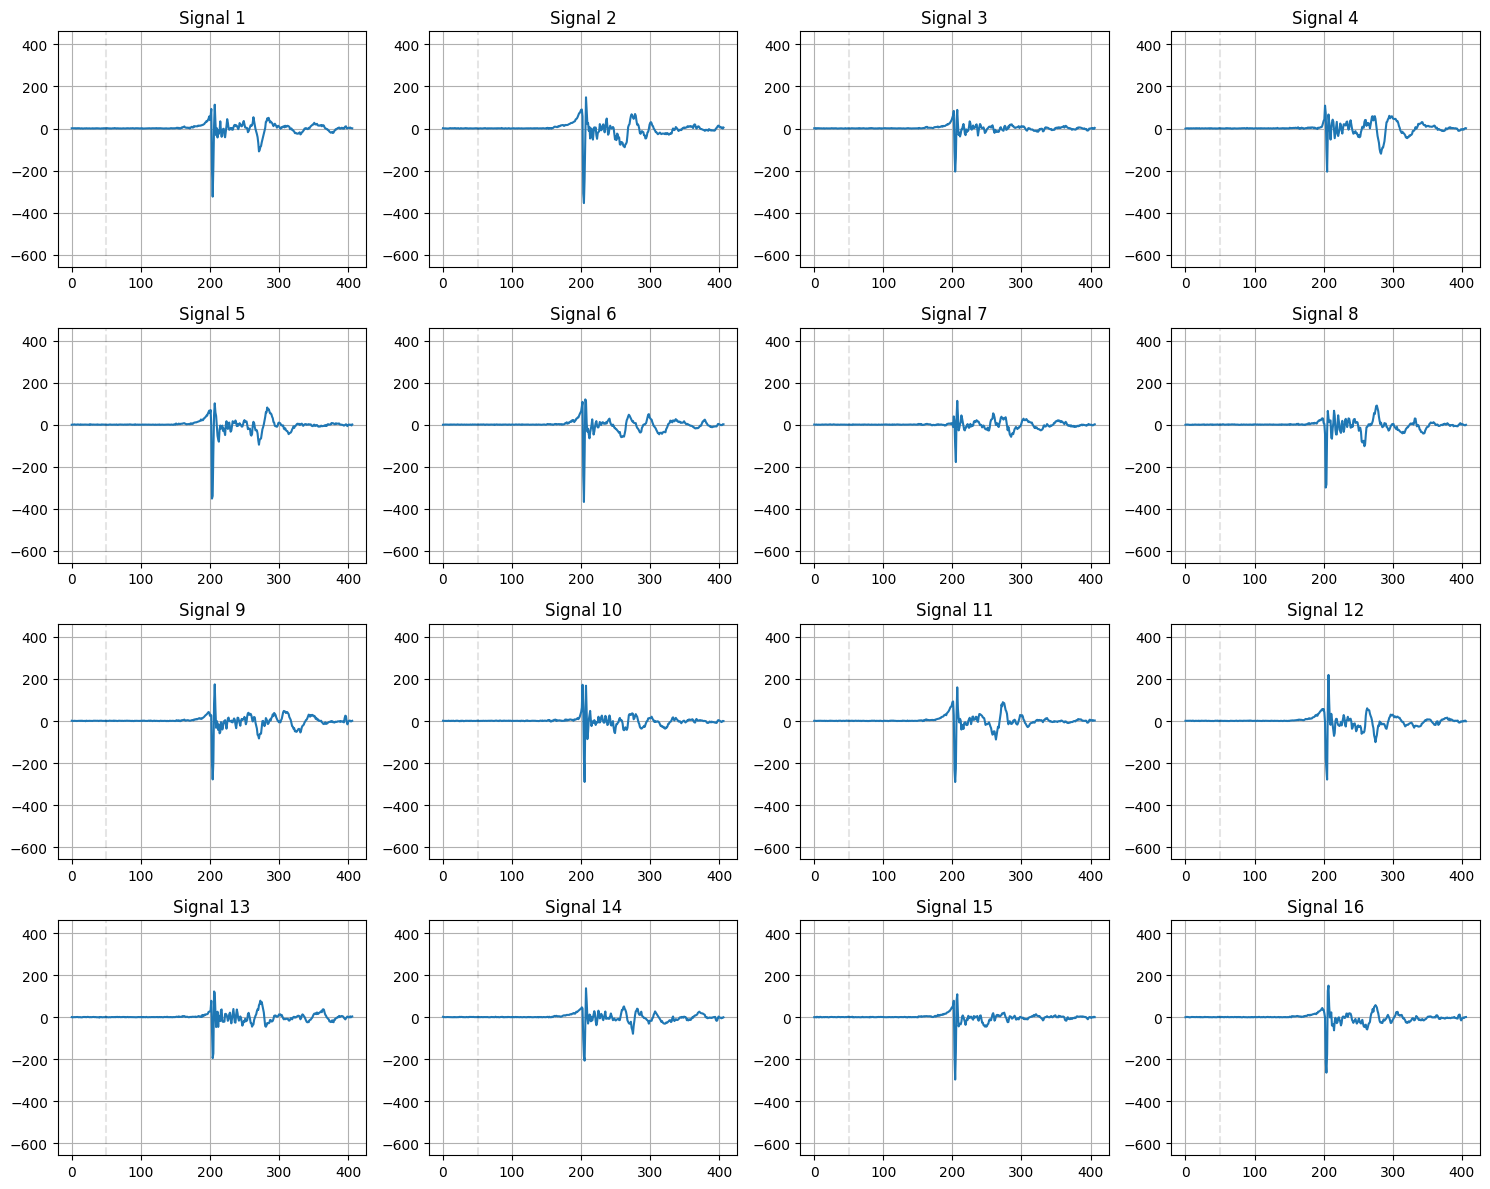

[28/32][0/188]	Loss_D: 0.5860	Loss_G: 2.3593	D(x): 0.8646	D(G(z)): 0.0924 / 0.1646
[28/32][50/188]	Loss_D: 0.7399	Loss_G: 1.9588	D(x): 0.8138	D(G(z)): 0.2916 / 0.2211
[28/32][100/188]	Loss_D: 0.6245	Loss_G: 1.8126	D(x): 0.9012	D(G(z)): 0.2364 / 0.2399
[28/32][150/188]	Loss_D: 0.8075	Loss_G: 1.8112	D(x): 0.8125	D(G(z)): 0.3290 / 0.2639
Epoch 28: SGD Discriminator lr 0.0000112 -> 0.0000109
Epoch 28: SGD Generator lr 0.0000112 -> 0.0000109


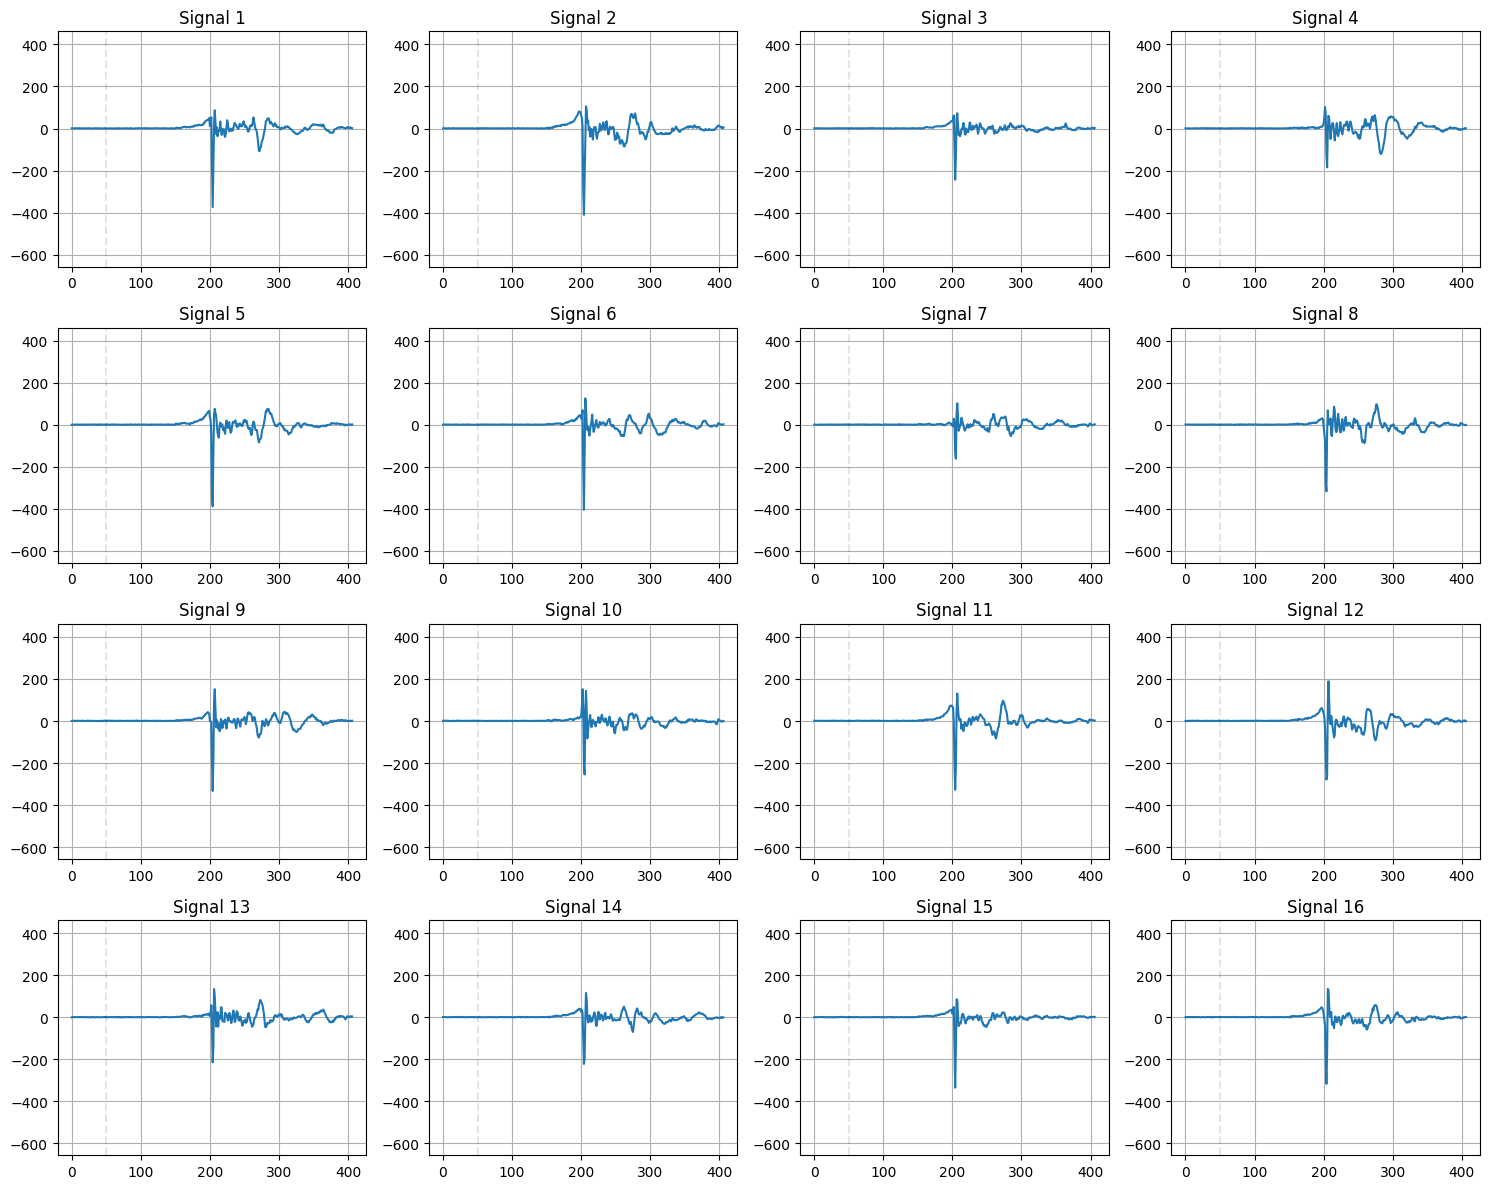

[29/32][0/188]	Loss_D: 0.7219	Loss_G: 1.5771	D(x): 0.8423	D(G(z)): 0.2502 / 0.2869
[29/32][50/188]	Loss_D: 0.8172	Loss_G: 1.7095	D(x): 0.7534	D(G(z)): 0.2866 / 0.2730
[29/32][100/188]	Loss_D: 0.6516	Loss_G: 1.8887	D(x): 0.8873	D(G(z)): 0.2428 / 0.2205
[29/32][150/188]	Loss_D: 0.6604	Loss_G: 1.7823	D(x): 0.8866	D(G(z)): 0.2332 / 0.2635
Epoch 29: SGD Discriminator lr 0.0000109 -> 0.0000106
Epoch 29: SGD Generator lr 0.0000109 -> 0.0000106


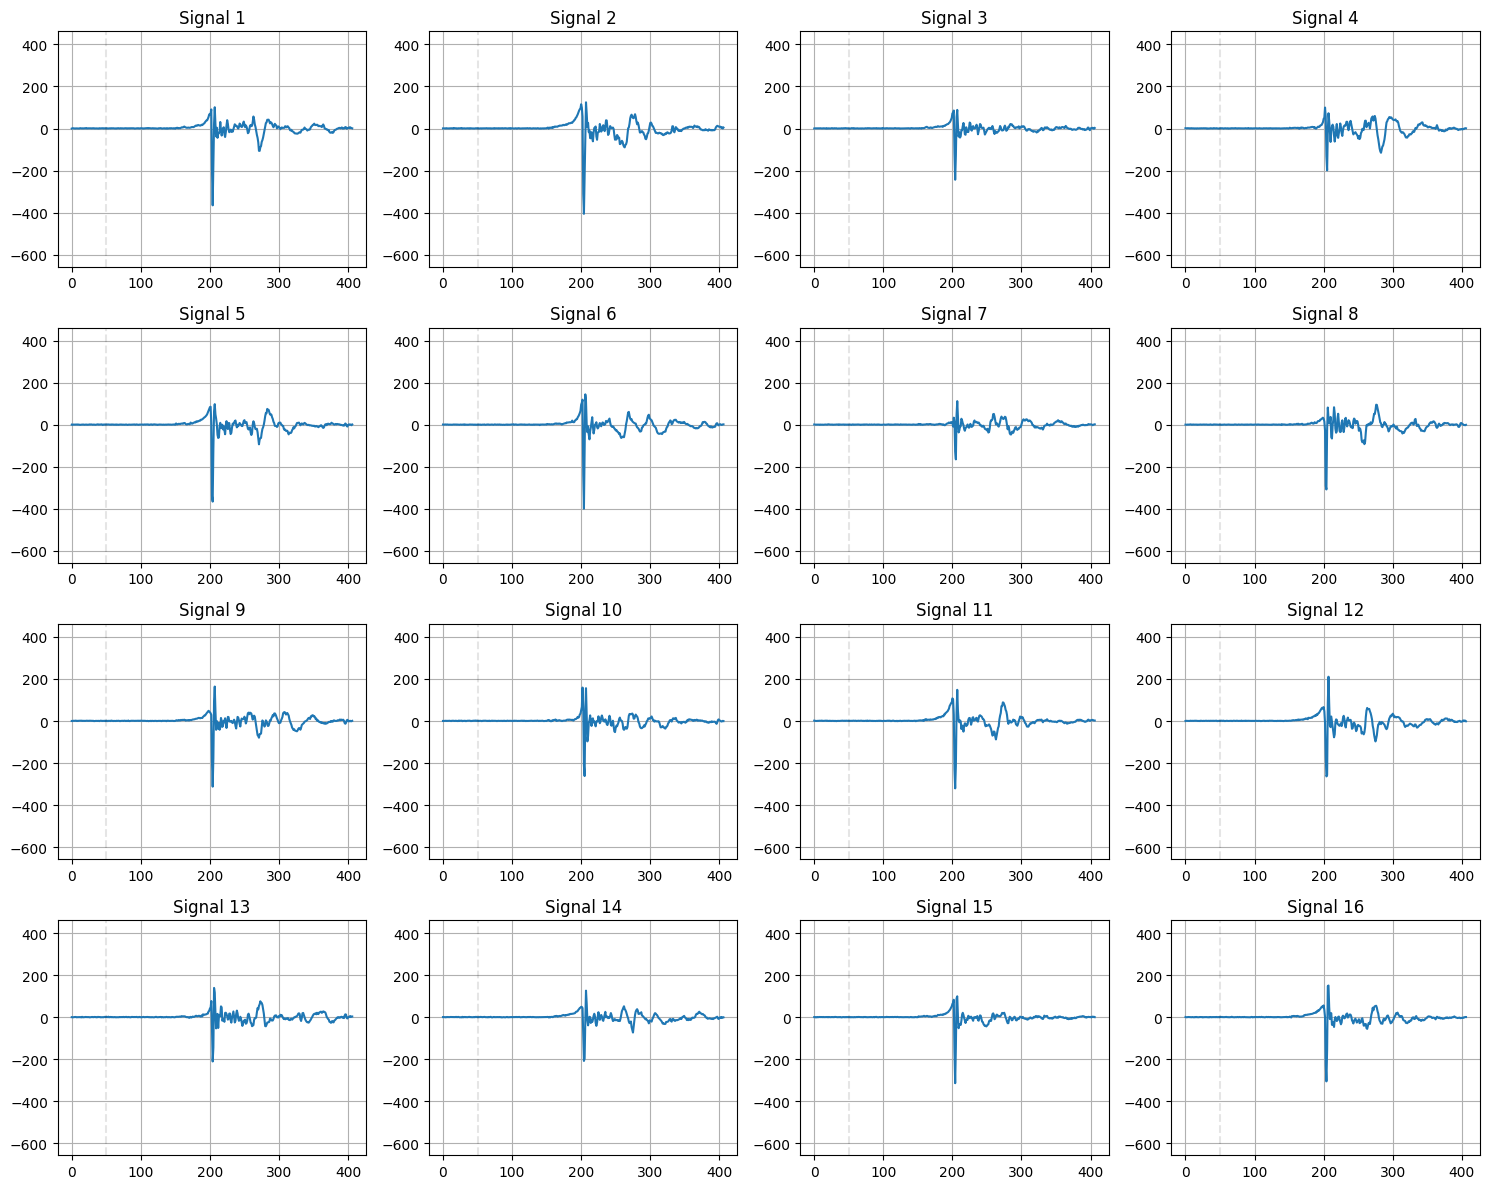

[30/32][0/188]	Loss_D: 0.6798	Loss_G: 2.5949	D(x): 0.8678	D(G(z)): 0.2465 / 0.1299
[30/32][50/188]	Loss_D: 0.6265	Loss_G: 1.8461	D(x): 0.9147	D(G(z)): 0.2010 / 0.2502
[30/32][100/188]	Loss_D: 0.6155	Loss_G: 1.8758	D(x): 0.8961	D(G(z)): 0.2655 / 0.2117
[30/32][150/188]	Loss_D: 0.6364	Loss_G: 1.6741	D(x): 0.8544	D(G(z)): 0.2001 / 0.2489
Epoch 30: SGD Discriminator lr 0.0000106 -> 0.0000103
Epoch 30: SGD Generator lr 0.0000106 -> 0.0000103


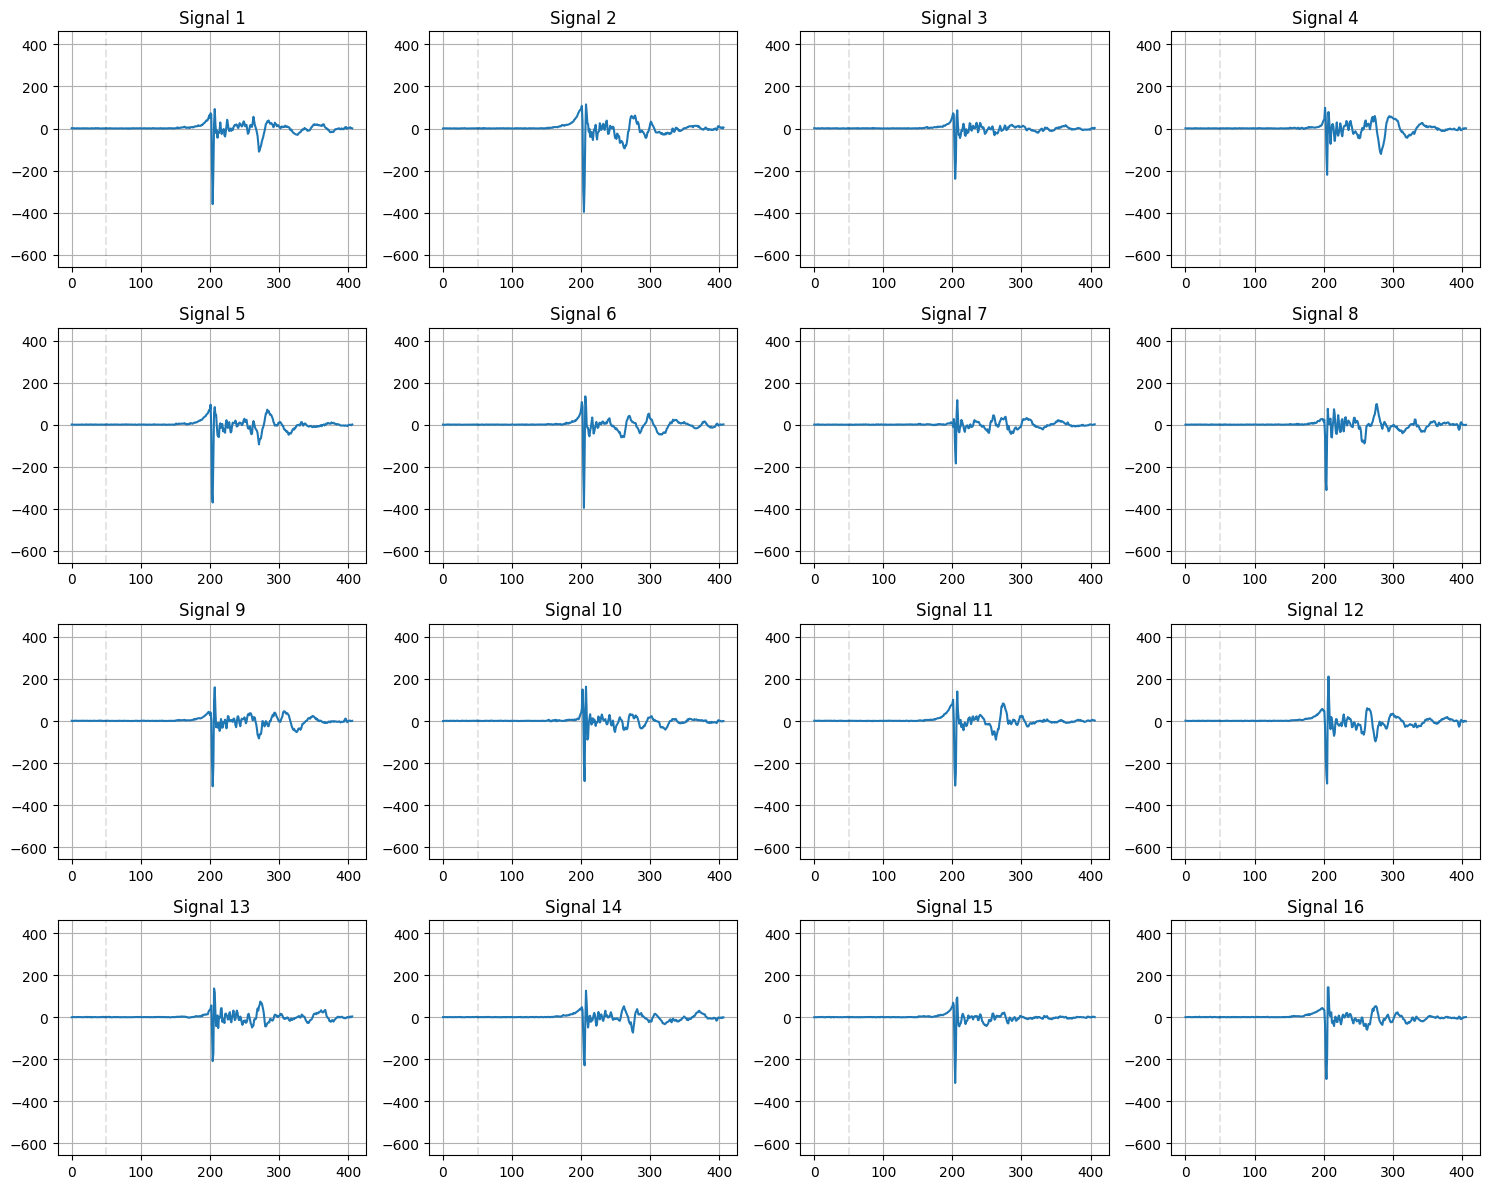

[31/32][0/188]	Loss_D: 0.6421	Loss_G: 1.6632	D(x): 0.8896	D(G(z)): 0.2698 / 0.2841
[31/32][50/188]	Loss_D: 0.7452	Loss_G: 2.0341	D(x): 0.8472	D(G(z)): 0.2636 / 0.2301
[31/32][100/188]	Loss_D: 0.5923	Loss_G: 2.1877	D(x): 0.9045	D(G(z)): 0.1971 / 0.1983
[31/32][150/188]	Loss_D: 0.5802	Loss_G: 2.0599	D(x): 0.9121	D(G(z)): 0.2442 / 0.1885
Epoch 31: SGD Discriminator lr 0.0000103 -> 0.0000100
Epoch 31: SGD Generator lr 0.0000103 -> 0.0000100


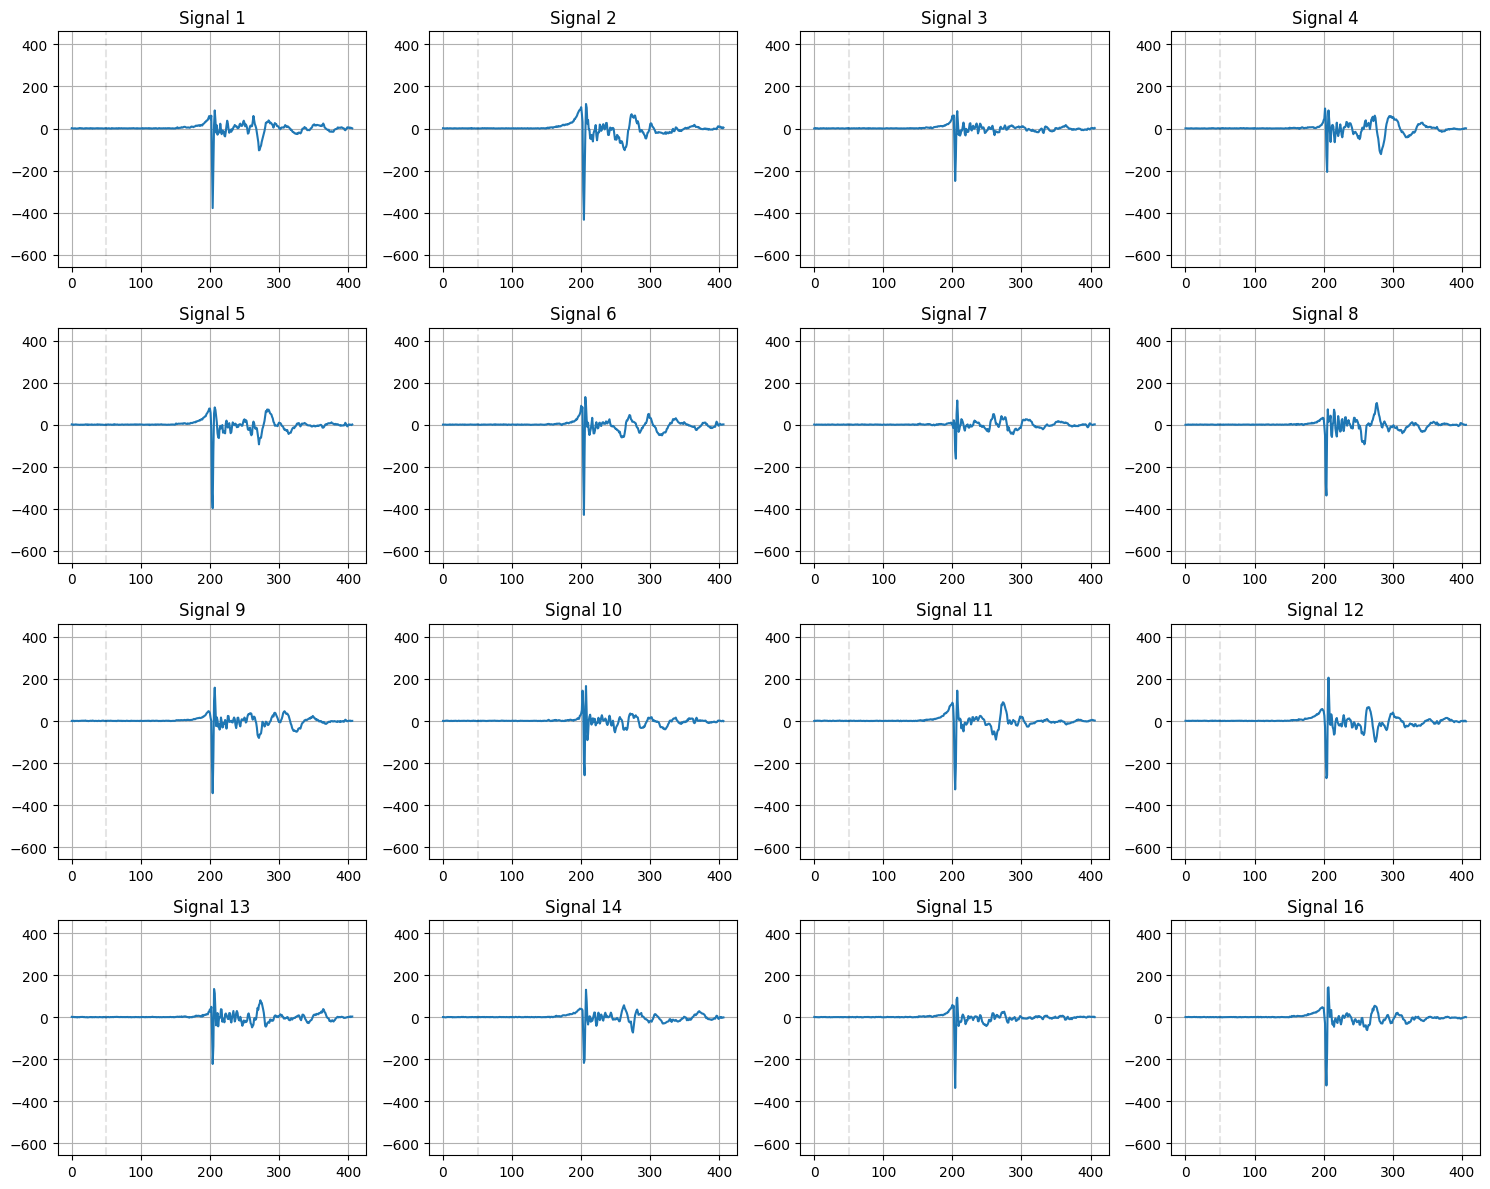

In [1028]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

if (gans_type == 'dcgans' or gans_type == 'gans'):
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_gpu = data[0].to(device)
            real_parameters_gpu = data[1].to(device)
            b_size = real_gpu.size(0)
            label_real = torch.FloatTensor(b_size).uniform_(1.0, 1.0).to(device)
            # Forward pass real batch through D
            output = netD(real_gpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label_real)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, device=device)
            # Generate fake signal batch with G
            fake = netG(noise)
            label_fake = torch.FloatTensor(b_size).uniform_(0.0, 0.25).to(device)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label_fake)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
            # Calculate gradients of discriminator parameters
            D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label_real = torch.FloatTensor(b_size).uniform_(1.0, 1.0).to(device)
            # label_real = 1.0 - label_fake
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label_real)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            # Calculate gradients of generator parameters
            G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1 
        
        # learning-rate decay
        before_lr = optimizerD.param_groups[0]["lr"]
        schedulerD.step()
        after_lr = optimizerD.param_groups[0]["lr"]
        print("Epoch %d: SGD Discriminator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

        before_lr = optimizerG.param_groups[0]["lr"]
        schedulerG.step()
        after_lr = optimizerG.param_groups[0]["lr"]
        print("Epoch %d: SGD Generator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))
        
        with torch.no_grad():
            fake_signals = netG(fixed_noise).detach().cpu()
            fig, axes = plt.subplots(4, 4, figsize=(15, 12))

            axes = axes.flatten()

            # plot each signal on a separate subplot
            for i, ax in enumerate(axes):
                x = np.arange(407)
                y = fake_signals[i, :, :].flatten()
                y = y * dataset.scaling_factor
                y = y * dataset.std + dataset.mean
                background_noise_generated = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int(407-256))
                y = np.concatenate((background_noise_generated, y))
                
                ax.plot(x, y)

                ax.axvline(x=50, color='black', linestyle='--', alpha=0.1)
                ax.set_title(f'Signal {i+1}')
                ax.grid(True)
                ax.set_ylim(common_ylim_signal)

            for i in range(407, 8*4):
                fig.delaxes(axes[i])

            plt.tight_layout()
            # plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_non_augment_%d.png' % (epoch + 1))
            plt.show()
        
        signal_list.append(fake_signals)

### Gradients

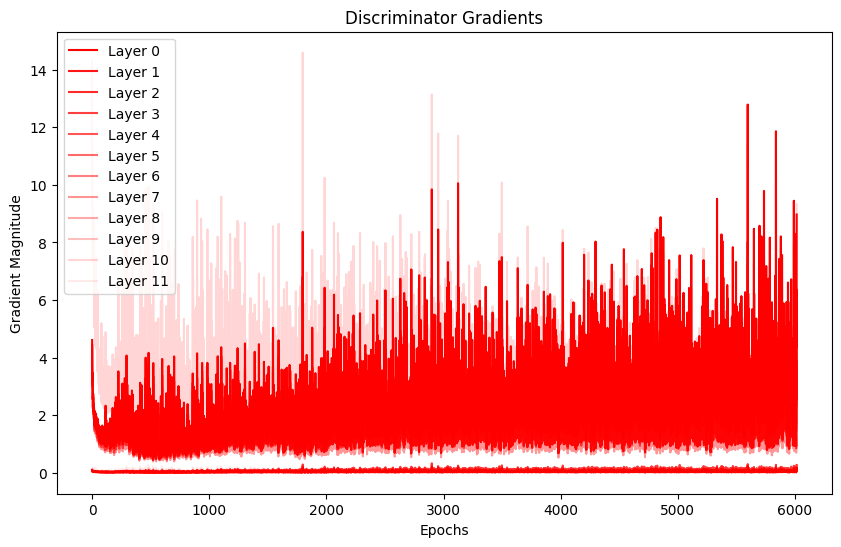

In [1029]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

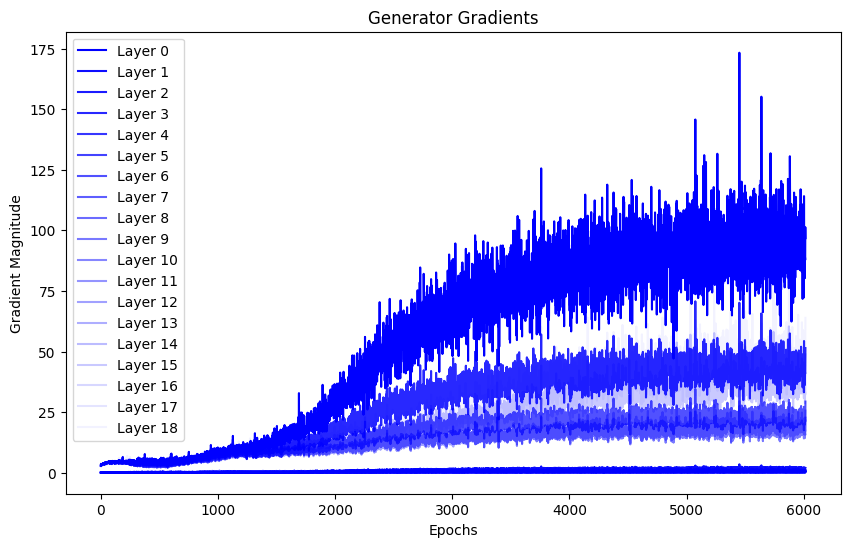

In [1030]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

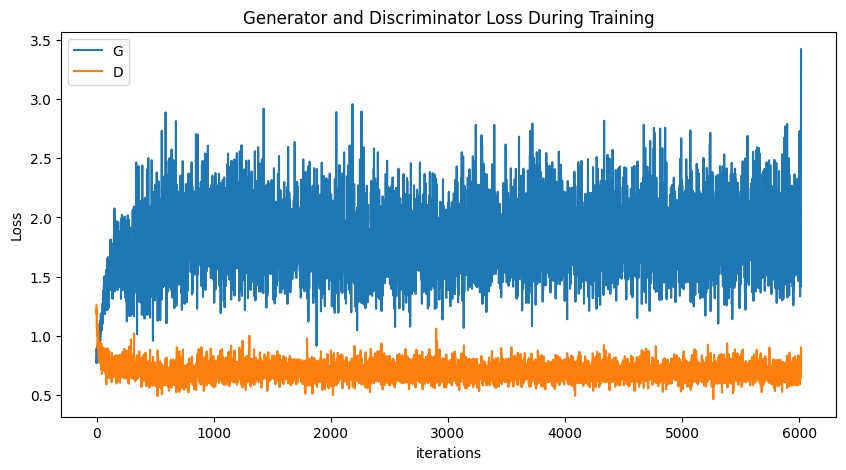

In [1031]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../plots/gw_dcgans_train_losses.png")
plt.show()

### Generated Signals

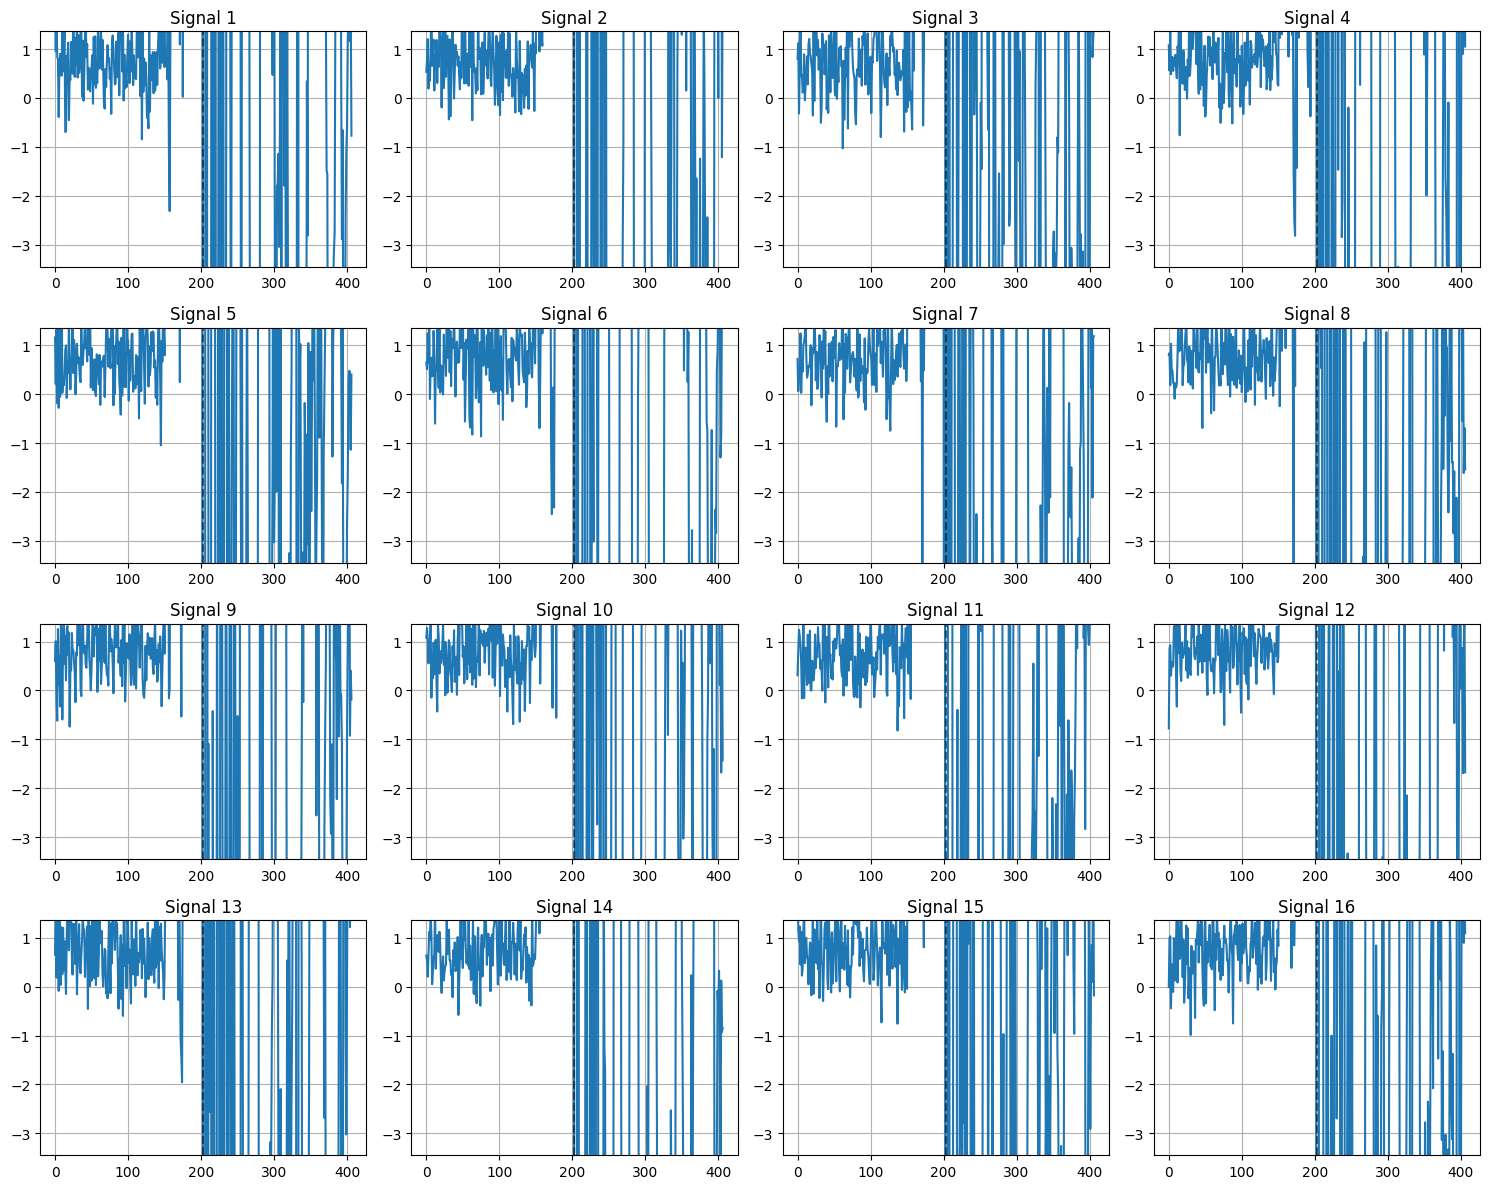

In [1032]:
batch = signal_list[19]

fig, axes = plt.subplots(4, 4, figsize=(15, 12))
axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(407)
    y = batch[i, :, :].flatten()
    y = y * dataset.scaling_factor
    y = y * dataset.std + dataset.mean
    background_noise_generated = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int(407-256))
    y = np.concatenate((background_noise_generated, y))
    ax.plot(x, y)

    ax.axvline(x=203, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(407, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()